# Optimization of TM model for ABA 2019 synphys data

In [133]:
from numba import jit, float64, int64

In [134]:
import pygmo as pg

### load MATLAB mat (=hdf) file with a structure

In [135]:
import numpy as np
import pandas as pd
import scipy.io

# function to load table variable from MAT-file
def loadtablefrommat(matfilename, tablevarname, columnnamesvarname):
    """
    read a struct-ified table variable (and column names) from a MAT-file
    and return pandas.DataFrame object.
    """

    # load file
    mat = scipy.io.loadmat(matfilename)

    # get table (struct) variable
    tvar = mat.get(tablevarname)
    data_desc = mat.get(columnnamesvarname)
    types = tvar.dtype
    fieldnames = types.names

    # extract data (from table struct)
    data = None
    for idx in range(len(fieldnames)):
        if fieldnames[idx] == 'data':
            data = tvar[0][0][idx]
            break;

    # get number of columns and rows
    numcols = data.shape[1]
    numrows = data[0, 0].shape[0]

    # and get column headers as a list (array)
    data_cols = []
    for idx in range(numcols):
        data_cols.append(data_desc[0, idx][0])

    # create dict out of original table
    table_dict = {}
    for colidx in range(numcols):
        rowvals = []
        for rowidx in range(numrows):
            rowval = data[0,colidx][rowidx]
            if type(rowval[0]) == np.ndarray and rowval.size > 0:
                rowvals.append(rowval[0])
            else:
                rowvals.append(rowval)
        table_dict[data_cols[colidx]] = rowvals
    return pd.DataFrame(table_dict)

In [136]:
do_normed_data= 1
if do_normed_data==0:
    df = loadtablefrommat('STP_cortex_exc_UDF3_struct.mat', 'table_struct', 'table_columns')
else:
    #df = loadtablefrommat('STP_cortex_exc_UDF3_struct_2.mat', 'table_struct', 'table_columns')
    #df = loadtablefrommat('STP_cortex_exc_UDF3_struct_3.mat', 'table_struct', 'table_columns') # fitted pulses medians for each cell
    df = loadtablefrommat('STP_cortex_exc_UDF4_struct.mat', 'table_struct', 'table_columns') # fitted pulses medians for each cell

df = df.iloc[1:,:]
df.head()

name      area  synapse_type  \
1    [aba_2019_synphys_pair_145; vip L5; sst L5]  [L5; L5]    [vip; sst]   
2    [aba_2019_synphys_pair_153; sst L5; vip L5]  [L5; L5]    [sst; vip]   
3  [aba_2019_synphys_pair_209; tlx3 L5; tlx3 L5]  [L5; L5]  [tlx3; tlx3]   
4    [aba_2019_synphys_pair_225; sst L5; vip L5]  [L5; L5]    [sst; vip]   
5    [aba_2019_synphys_pair_243; sst L5; vip L5]  [L5; L5]    [sst; vip]   

       synapse_type_2                                          stp_freq  \
1    [vip L5; sst L5]  [50.0 x 8_An/A1, 3.95 x 1_An/A1, 50.0 x 4_An/A1]   
2    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
3  [tlx3 L5; tlx3 L5]  [10.0 x 8_An/A1, 3.95 x 1_An/A1, 10.0 x 4_An/A1]   
4    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
5    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   

                                          stp_mean_1 stp_sigma  \
1  [[[[-0.000203732631684148, -0.0004491755786023...   [[nan]]   
2  [[[[-2.89382960161328e-12, -3.82155796554926e-...   [[nan]]   
3  [[[[7.99765683439207e-12, 5.43728979662922e-12...   [[nan]]   
4  [[[[-3.71118131444336e-12, -8.1103432630279e-1...   [[nan]]   
5  [[[[-2.16692842509031e-12, -4.253601440662e-12...   [[nan]]   

                                            comments  \
1  [         1               1               1   ...   
2  [         1               1               1   ...   
3  [         1               1               1   ...   
4  [           1                1                ...   
5  [1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  ...   

                                           comments1  \
1  [0    50   100   150   200   250   300   350  ...   
2  [0    50   100   150   200   250   300   350  ...   
3  [0    50   100   150   200   250   300   350  ...   
4  [0    50   100   150   200   250   300   350  ...   
5  [0    50   100   150   200   250   300   350  ...   

                                 numbers_of_currents references  \
1  [24    0    0    4    0    5    0    5    0   ...         []   
2  [24    0    0    4    0    4    0    5    0   ...         []   
3  [25   25    0    5    5    5    5    5    5   ...         []   
4  [21    0    0    5    0    5    0    3    4   ...         []   
5  [10    0    0    3    2    1    2    2    0   ...         []   

                                  stp_mean_bootstrap  \
1  [2.74222534339343, 0.7382247571157633, 2.51743...   
2  [1.3347983550875044, -0.02716199265129635, 0.0...   
3  [1.859150136902722, 1.1979946017670278, -0.248...   
4  [-4.607307659199178, -1.8230922244411998, 3.07...   
5  [-2.927761175820929, -1.8292296373475438, 9.24...   

                                 stp_sigma_bootstrap  \
1  [1.1196772108156001, 0.5265105524388533, 1.668...   
2  [0.7125426449878994, 1.7386049470972242, 1.534...   
3  [0.5030106009773302, 0.3418700105140623, 1.007...   
4  [6.56221503628237, 2.9051157000286754, 1.64852...   
5  [8.744698216803155, 2.864338380289494, 7.94276...   

                              stp_mean_fit_bootstrap  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [1.2895353570909072, 1.0703691566796072, 0.804...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                             stp_sigma_fit_bootstrap  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.19470798120505872, 0.18691180962200024, 0.2...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [137]:
df2 = pd.read_excel('aba_synapses_2.xlsx')
df2.head()

Unnamed: 0                       name    area area2 synapse_type  \
0           0  aba_2019_synphys_pair_145  L5; L5  VisP     vip; sst   
1           1                        NaN     NaN   NaN          NaN   
2           2                        NaN     NaN   NaN          NaN   
3           3                        NaN     NaN   NaN          NaN   
4           4                        NaN     NaN   NaN          NaN   

    synapse_type2                                        stp_freq  \
0  vip L5; sst L5  50.0 x 8_An/A1, 3.95 x 1_An/A1, 50.0 x 4_An/A1   
1             NaN  50.0 x 8_An/A1, 1.99 x 1_An/A1, 50.0 x 4_An/A1   
2             NaN   50.0 x 8_An/A1, 1.0 x 1_An/A1, 50.0 x 4_An/A1   
3             NaN   50.0 x 8_An/A1, 0.5 x 1_An/A1, 50.0 x 4_An/A1   
4             NaN  50.0 x 8_An/A1, 0.25 x 1_An/A1, 50.0 x 4_An/A1   

                                            stp_mean  \
0  [-0.000203732631684148, -0.000449175578602308,...   
1  [0.000114019576011995, 2.62525029842559e-05, -...   
2  [-0.000382587328071303, 0.00017161344709269, -...   
3  [5.21454895203305e-06, -0.000190441939224441, ...   
4  [-3.47852044778676e-05, -0.000511557342581702,...   

                                        stp_mean_fit  stp_sigma  ...  \
0  [None, None, None, None, None, None, None, Non...        NaN  ...   
1  [None, None, None, None, None, None, None, Non...        NaN  ...   
2  [None, None, None, None, None, None, None, Non...        NaN  ...   
3  [None, None, None, None, None, None, None, Non...        NaN  ...   
4  [None, None, None, None, None, None, None, Non...        NaN  ...   

          acsf         internal target_temperature clamp_mode clamp_mode2  \
0  2mM Ca & Mg  Standard K-Gluc               32.0         vc          ic   
1          NaN              NaN                NaN         vc          ic   
2          NaN              NaN                NaN         vc          ic   
3          NaN              NaN                NaN         vc          ic   
4          NaN              NaN                NaN         vc          ic   

   n_spikes baseline_potential baseline_rms_noise  synapse_type3  references  
0       0.0          -0.058342           0.001242             in         NaN  
1       0.0          -0.051315           0.000885            NaN         NaN  
2       0.0          -0.054662           0.001379            NaN         NaN  
3       0.0          -0.054936           0.000809            NaN         NaN  
4       0.0          -0.054722           0.001131            NaN         NaN  

[5 rows x 23 columns]

In [138]:
df2.columns

Index(['Unnamed: 0', 'name', 'area', 'area2', 'synapse_type', 'synapse_type2',
       'stp_freq', 'stp_mean', 'stp_mean_fit', 'stp_sigma', 'comments',
       'position', 'stp_freq_vector', 'acsf', 'internal', 'target_temperature',
       'clamp_mode', 'clamp_mode2', 'n_spikes', 'baseline_potential',
       'baseline_rms_noise', 'synapse_type3', 'references'],
      dtype='object')

In [139]:
df2.shape

(46730, 23)

In [140]:
df.shape

(1319, 15)

In [141]:
def  STP_sim(x, T, init_state=None, model_type='tm5' ):
    # transform labels from TM to An:A1
    #f = 20 # Hz
    #N = 3
    #T = np.arange(N)*1000/f

    N    = len(T)
    #nc   = ge_data.shape[0]

    #x_lower = np.array([1,       0.01,    1,      0.1,     1])
    #x_upper = np.array([10000,   1,      10000,    10,     1])
    

    #stp_ns =          ['tF',    'p0',    'tD',   'dp/p0', 'A']
    #for jj in range(len(stp_ns)):
    #    nsj = stp_ns[jj]
    #    ge_data.loc[:,nsj] = np.maximum(ge_data.loc[:,nsj].values,x_lower[jj])
    #    ge_data.loc[:,nsj] = np.minimum(ge_data.loc[:,nsj].values,x_upper[jj])
    #    if nsj=='dp/p0':
    #        p0   = ge_data.loc[:,'p0'].values
    #        dpp0 = ge_data.loc[:,'dp/p0'].values
    #        dp = p0*dpp0
    #        dp = np.minimum(dp,1)
    #        ge_data.loc[:,nsj] = dp/(p0 +np.finfo(float).eps)

    #dpp0 = ge_data.loc[:,'dp/p0'].values
    #p0   = ge_data.loc[:,'p0'].values
    #tF   = ge_data.loc[:,'tF'].values
    #tD   = ge_data.loc[:,'tD'].values
    #A    = ge_data.loc[:,'A'].values
        
    
    tF      = x[0].astype(float)
    p00     = x[1]
    tD      = x[2].astype(float)
    dp      = x[3]
    A       = x[4]
    
    #breakpoint()
    mod_fdr2=False
    if model_type=='tm5_fdr2':  # should be :check freq. dependent recovery
        tDmin     = x[5]
        dd        = x[6]
        t_FDR     = x[7]
        mod_fdr2=True
        tDmax  = tD
        itDmin = 1/tDmin
        itDmax = 1/tDmax
        #breakpoint()
        
    mod_smr=False
    if model_type=='tm5_smr':  # should be :check freq. dependent recovery
        t_SMR   = x[8]
        dp0     = x[9]
        mod_smr = True
        #p00  = p00


    #As = np.zeros((nc,N))
    #n = np.zeros((nc,))
    #p = np.zeros((nc,))
    #ns2 = np.zeros((nc,N))
    #ps2 = np.zeros((nc,N))
    As = np.zeros((N,))
    #n = np.zeros((1,))
    #p = np.zeros((1,))
    state = np.zeros((N,4))
    #ps2 = np.zeros((N,))
    #ds2 = np.zeros((N,))

   
    if init_state is None :
        n = 1
        p0=p00
        p = p0
        d = 0
    else:
        n = init_state[0]
        p = init_state[1]
        d = init_state[2]
        p0= init_state[3]

    #ns2[i]=n
    #ps2[i]=p
    #ds2[i]=d
    
    for i in range(0,N):
        if i==0:
            Dt = T[i]
        else:
            Dt = T[i]-T[i-1]
        #n = 1 - (1 - (n -p*n))*np.exp((-Dt/tD).astype(float))
        #p=p0 -(p0-(p + dpp0*p0*(1-p)))*np.exp((-Dt/tF).astype(float))
        
        if mod_fdr2:
            d0=d
            d = d*np.exp(-Dt/t_FDR) 
            n = 1 - (1 - n )*np.exp(-Dt*itDmax -(itDmin -itDmax)*t_FDR*(d0-d))
        else:
            n = 1 - (1 - n )*np.exp(-Dt/tD )
            
        if mod_smr:
            p01=p0
            p0=p00 + (p0 -p00)*np.exp(-Dt/t_SMR)
            p=p0 +(p -p01)*np.exp(-Dt/tF)
        else:
            p=p0 +(p -p0)*np.exp(-Dt/tF)
            
        
        #tD = 1/(itDmax + (itDmin -itDmax)*d)
        #n = 1 - (1 - (n -p*n))*np.exp((-Dt/tD))
        #p=p0 +(p + dp*(1-p)-p0)*np.exp((-Dt/tF))

        As[i]=A*n*p
       
        n = n*(1-p)
        p = p + dp*(1-p)
        if mod_fdr2:
            d  = d + dd*(1-d) 
        if mod_smr:
            p0  = p0 - dp0*p0    
        
        #ns2[i]=n
        #ps2[i]=p
        #ds2[i]=d 
        state[i] = [n,p,d,p0]
        #breakpoint()


    #aa = [As, ns2, ps2]
    
    #breakpoint()
    #return As, ns2, ps2, dpp0, p0, tF, tD, A
    return As, state

In [142]:
x = [1.00000000e+01, 4.00000000e-01, 1.00000000e+02, 4.00000000e-01,
 4.59968078e+00, 1.00000000e+01,
 5.00000000e-04, 1.00000000e+02]
x = np.array(x)
T  = np.arange(8)*50
As, st = STP_sim(x, T, init_state=None )
As

array([1.83987231, 1.39913031, 1.23467709, 1.17497776, 1.15331081,
       1.14544715, 1.14259317, 1.14155736])

In [143]:
st[:,0]

array([0.6       , 0.45320786, 0.39992711, 0.38058972, 0.37357153,
       0.3710244 , 0.37009996, 0.36976444])

In [144]:
st[:,1]

array([0.64      , 0.64097026, 0.64097419, 0.6409742 , 0.6409742 ,
       0.6409742 , 0.6409742 , 0.6409742 ])

In [145]:
st[:,2]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [146]:
st[:,3]

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [147]:
def Q_TM_aba_synphys(x, amps,sig,Ts,DT0,model_type='tm5'):
    #Q, A, A3 =  QA_TM_aba_synphys(x, amps,sig,Ts)
    Q, A =  QA_TM_aba_synphys(x, amps,sig,Ts,DT0,model_type)
    return Q    

In [148]:
def QA_TM_aba_synphys(x, amps,sig,Ts,DT0,model_type='tm5'):
    #amps=args[0] 
    #sig=args[1] 
    #Ts=args[2]
    
    
    fl=0
    if fl==0:
        ams = x[4:7]
        #breakpoint()
        if len(x)>7:
            if model_type=='tm5_fdr2':
                x2=np.copy(np.delete(x,[5,6]))
            if model_type=='tm5_smr':
                x2=np.copy(np.delete(x,[5,6]))    
            
            #x2[5:] = x[7:]
        else:
            x2=np.copy(x[0:5])
    
    n  = [0, 32, 44]
    t2 = [6, 1,  1]
    #T2  =[125, 250, 500, 1000, 2000, 4000]
    eps = np.finfo(float).eps
    z4 = np.arange(4)
    z8 = np.arange(8)
    A = np.zeros((amps.shape[0],))
    #A3 = np.ones((amps.shape[0],))
    #S3 = np.zeros((amps.shape[0],))
    Q=0
    for ii in range(3):
        vv = z8 + n[ii]
        A1e = amps[vv]  
        S1e = sig[vv]
        if fl==0:
            x2[4] = ams[ii] # independent amplitudes for each stimulation frequency - to account for rundown etc.
        
        #vv_nonz = np.nonzero(np.abs(A1e[:])>eps*1e3)[0]
        vv_z = np.abs(A1e[:])<eps*1e3
        #print(vv_nonz)
        #if len(vv_nonz)>0:
        if sum(vv_z)!=len(A1e):
            # preconditioning:
            A1, states = STP_sim(x2, Ts[vv],model_type=model_type ) 
            np0 = states[-1]
            
            # first 8 stimuli responces:
            #A1, states = STP_sim(x2, Ts[vv]+DT0, init_state=np0, model_type=model_type ) 
            #breakpoint()
            A1[vv_z] = 0
            A[vv] = A1
            
            #Q = Q + np.sum((A1e[vv_nonz]-A1[vv_nonz])**2/(S1e[vv_nonz]**2 + eps))
            Q = Q + np.sum((A1e-A1)**2/(S1e**2 + eps))
            # recovery responces
            #np0 = [n12[-1], p12[-1], d12[-1]]
            np0 = states[-1]
            for i3 in range(t2[ii]):
                vv2 = vv[-1]+1+z4+4*i3
                A2e = amps[vv2] 
                S2e = sig[vv2] 
                ##A3[vv2] = np.median(A1e)
                #vv_nonz2 = np.nonzero(np.abs(A2e[:])>eps*1e3)[0]
                #print(vv_nonz2)
                vv_z2 = np.abs(A2e[:])<eps*1e3
                #if len(vv_nonz2)>0:
                if sum(vv_z2)!=len(A2e):
                    A2, states2 = STP_sim(x2, Ts[vv2], init_state=np0, model_type=model_type )
                    
                    A2[vv_z2] = 0
                    
                    A[vv2] = A2
                    
                    #breakpoint()
                    #A2 = A2/np.median(A1)
                    #A[vv2] = A2
                    #breakpoint()
                    
                    #Q = Q + np.sum((A2e[vv_nonz2]-A2[vv_nonz2])**2/(S2e[vv_nonz2]**2 + eps))
                    Q = Q + np.sum((A2e-A2)**2/(S2e**2 + eps))
    
    return Q, A #, A3

[   0.   50.  100.  150.  200.  250.  300.  350.  125.  175.  225.  275.
  250.  300.  350.  400.  500.  550.  600.  650. 1000. 1050. 1100. 1150.
 2000. 2050. 2100. 2150. 4000. 4050. 4100. 4150.    0.   20.   40.   60.
   80.  100.  120.  140.  250.  270.  290.  310.    0.  100.  200.  300.
  400.  500.  600.  700.  250.  350.  450.  550.]


array([1.83987231, 1.39913031, 1.23467709, 1.17497776, 1.15331081,
       1.14544715, 1.14259317, 1.14155736, 1.50765821, 1.27774067,
       1.19061951, 1.15898778, 1.74469041, 1.36435183, 1.22205447,
       1.17039658, 1.83205931, 1.39627552, 1.23364097, 1.17460171,
       1.83981967, 1.39911107, 1.23467011, 1.17497522, 1.83987231,
       1.39913031, 1.23467709, 1.17497776, 1.83987231, 1.39913031,
       1.23467709, 1.17497776, 1.83987231, 1.3378008 , 0.9881871 ,
       0.82021945, 0.74219759, 0.7061038 , 0.68941601, 0.68170118,
       1.71787705, 1.27300575, 0.95789675, 0.80620368, 1.83987231,
       1.56917458, 1.50940675, 1.49621457, 1.49330275, 1.49266004,
       1.49251818, 1.49248686, 1.76234953, 1.55206269, 1.50562975,
       1.4953809 ])

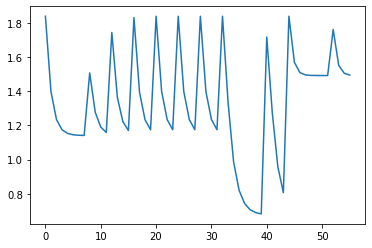

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
x = [1.00000000e+01, 4.00000000e-01, 1.00000000e+02, 4.00000000e-01,
 4.59968078e+00, 4.59968078e+00,4.59968078e+00, 1.00000000e+01,
 5.00000000e-04, 1.00000000e+02]

Ts = df.loc[1,'comments1']
Ts = np.array(Ts[0][:].strip().split()).astype(float)
print(Ts)

vv=np.arange(len(As))
npar=56
amps = np.ones(npar)
amps[vv]=As*1.05
sig = amps/5
DT0=2500000
model_type = 'tm5'
Q2,As2 = QA_TM_aba_synphys(x[0:7], amps,sig,Ts,DT0,model_type )
plt.plot(As2)
As2

In [150]:
#i=1
def fit_TM_cell(i,df,par):
    #breakpoint()
    aba_case=False
    if 'aba_case' in par:
        aba_case = par['aba_case']
        
    model_type='tm5'
    if 'model_type' in par:
        model_type = par['model_type']   
        
    dont_plot=0
    if 'dont_plot' in par:
        dont_plot = par['dont_plot'] 
    
    if par['fited_pulses']==True:
        ampsa = df.loc[i,'stp_mean_fit_bootstrap']
        siga = df.loc[i,'stp_sigma_fit_bootstrap']  
        #if abs(ampsa[0])<1e-14:
            #ampsa = df.loc[i,'stp_mean_bootstrap']
            #siga = df.loc[i,'stp_sigma_bootstrap']
    else:
        ampsa = df.loc[i,'stp_mean_bootstrap']
        siga = df.loc[i,'stp_sigma_bootstrap']
        
    do_sade=False
    if 'do_sade' in par:
        do_sade = par['do_sade']
        
    Ts = df.loc[i,'comments1']
    Ts = np.array(Ts[0][:].strip().split()).astype(float)
    
    #breakpoint()

    #A3 = df.loc[i,'comments']
    #A3i = np.array(A3[0][:].strip().split()).astype(float)
    #A4 = np.ones((len(A3),len(A3i)))
    #for ia3 in range(len(A3)):
    #    A3i = np.array(A3[ia3][:].strip().split()).astype(float)
    #    A4[ia3,:] = A3i
    ##A4.shape 
    
    
    ibs  = par['ibs']
    npar = 56
    #amps = ampsa[ibs*npar + np.arange(npar)]
    ampsa1 = ampsa.reshape((-1,npar))
    amps = ampsa1[ibs,:].ravel()
    
    if aba_case:
        # sig  = siga #[(ibs-1)*npar + np.arange(npar)]
        #A3e  = A4[:,ibs ].ravel()

        siga1 = siga.reshape((-1,npar))
        sig = siga1[ibs,:].ravel()
    else:
        #sig = np.std(ampsa1,axis=0).ravel() # reestimate sigma
        sig=pd.DataFrame(ampsa1).std(axis=0).values
        
    DT0 = 25000
    #breakpoint()
    # restrict set of fited data
    vv = par['amplitudes_selected_for_TM_training']
    #vv = np.arange(8)    # A 1:8
    #vv = np.arange(npar) # all
    #vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
    
    amps0 = amps
    amps = np.zeros(amps.shape)
    amps[vv] = amps0[vv]

         #  tF   p0     tD  dp         A            A1           A2      tDmin  dd   t_FDR t_SMR dp0 
    x0 = [ 100,  0.1,  100, 0.1, amps[0]/0.1, amps[0]/0.1,  amps[0]/0.1, 10,   0.05, 100,  100,  0.02 ]
    
    x0 = np.array(x0)
    
    #dxx = np.array([1e3, 20, 1e3, 1e2,  20, 20, 20,  1e1, 20, 1e2 ])
    dxx = np.array([1e3,  10, 1e3, 10,  20, 20, 20,  1e3, 20, 1e3, 1e3, 50 ])
    
    #breakpoint()
    if model_type=='tm5':
        x0 = x0[0:7]
        dxx = dxx[0:7]
        
    if model_type=='tm4':
        x0 = x0[0:7]
        dxx = dxx[0:7]
        
    if model_type=='tm5_fdr2':
        x0 = x0[0:10]
        dxx = dxx[0:10]
        
    if model_type=='tm5_smr':
        x0 = x0    
        dxx = dxx
    #print(x0)
    Q0, A0 = QA_TM_aba_synphys(x0, amps, sig, Ts,DT0,model_type)
    #print(x0)
    print('initial Q: ',str(Q0))

    #           tF      p0    tD        dp           A                A1                  A2              tDmin   dd   tD2
    #xlower = [  0.1,   0.01,   0.1,     0.0001,     amps[0]/1*1e-1,   amps[0]/1*1e-1,     amps[0]/1*1e-1,  1,     1e-3, 1]
    xlower = x0/dxx
    xlower = np.array(xlower)
    #xupper = [  1e5,   1,      1e5,     1,          amps[0]/0.01*1e1, amps[0]/0.01*1e1,   amps[0]/0.01*1e1, 100,  1,    1e4]
    #xupper = np.array(xupper)
    xupper = x0*dxx
    bounds = [] #np.zeros(len(xlower))
    for ibo in range(len(xlower)):
        bounds = bounds + [(xlower[ibo],xupper[ibo])]
    tt=[]
    #import time
    #import scipy.optimize as opt
    t1 = time.time()
    
    #print(x0)
    #print(A0)
    #breakpoint()
    
    do_this=0
    if do_this==1:
        res1 = opt.shgo(Q_TM_aba_synphys, bounds , args=((amps, sig, Ts,DT0,model_type)), constraints=None, n=10,
                            iters=1, callback=None, minimizer_kwargs=None, options=None, sampling_method='simplicial')
        x_shgo = res1.x
    else:
        x_shgo = x0
    
    t2 = time.time()
    tt = tt + [t2-t1]
    print('shgo : elapsed time '+str(t2-t1)+'s ')

    t1 = time.time()
    do_good=True
    if do_good:
        popsize = 65 # best
        maxiter=1000
        tol=0.01
    else:
        popsize = 5  # fast
        maxiter=10
        tol=0.1
        
    #breakpoint()    
    do_this=1 # Apply differential_evolution
    if do_this==1:
        res2 = opt.differential_evolution(Q_TM_aba_synphys, bounds , args=((amps, sig, Ts,DT0,model_type)), strategy='best1bin',
                           maxiter=maxiter, popsize=popsize, tol=tol, mutation=(0.5, 1), recombination=0.7, seed=None,
                           callback=None, disp=False, polish=True, init='latinhypercube', atol=0,
                           updating='immediate', workers=1)
        x_de = res2.x
    else:
        x_de = x0  
        
    t2 = time.time()
    tt = tt + [t2-t1]
    print('differential_evolution: elapsed time '+str(t2-t1)+'s ')

    t1 = time.time() # Apply dual_annealing
    do_good=False
    if do_good:
        maxiter=1000 # good
        accept=-5.0 
        maxfun=10000000.0
    else:
        maxiter=10 # fast
        maxfun=10.0
        accept=-1.0
    fl=0  
    
    do_this=1
    if do_this==1:
        res3 = opt.dual_annealing(Q_TM_aba_synphys, bounds , args=((amps, sig, Ts,DT0,model_type)), maxiter=1000, 
                              local_search_options={},
                              initial_temp=5230.0,restart_temp_ratio=2e-05, visit=2.62, 
                              accept=accept, maxfun=maxfun, seed=None,
                              no_local_search=False, callback=None, x0=None)
        x_da = res3.x
    else:
        x_da = x0 
        
    t2 = time.time()
    Q, A = QA_TM_aba_synphys(x_da, amps, sig, Ts,DT0,model_type)
    A_da=A
    tt = tt + [t2-t1]
    print('dual_annealing: elapsed time '+str(t2-t1)+'s ')

    t1 = time.time()
    do_this=0 # Apply basinhopping
    if do_this==1:
        res4 = opt.basinhopping(Q_TM_aba_synphys, x0 , niter=1, T=1.0, stepsize=1.0,
                            minimizer_kwargs={'method':"L-BFGS-B", 'args':(amps, sig, Ts,DT0,model_type)}, 
                            take_step=None, accept_test=None, callback=None, interval=50, disp=False,
                           niter_success=None, seed=None)
        x_bh = res4.x
    else:
        x_bh = x0 
        
    t2 = time.time()
    tt = tt + [t2-t1]
    print('basinhopping: elapsed time '+str(t2-t1)+'s ')
    #t1 = time.time()
    #res4 = opt.basinhopping(Q_TM_aba_synphys, x0 , niter=100, T=1.0, stepsize=1.0,
    #                        minimizer_kwargs={'method':"L-BFGS-B", 'args':(amps, sig, Ts,DT0)}, 
    #                        take_step=None, accept_test=None, callback=None, interval=50, disp=False,
    #                        niter_success=None, seed=None)
    t1 = time.time()
    #do_sade
    if do_sade:
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,
                                          np.array(xlower).reshape((-1,)),np.array(xupper).reshape((-1,))))
        #pop = pg.population(prob=prob, size = 1000)
        uda = pg.de1220(gen = 100, allowed_variants = [2,3,7,10,13,14,15,16], variant_adptv = 1, ftol = 1e-6, xtol = 1e-6, memory = False)
        algo = pg.algorithm(uda)
        archi = pg.archipelago(n=32,algo=algo, prob=prob, pop_size=150)
        
        #pop2 = algo.evolve(pop)
        archi.evolve() 
        archi.wait()
        
        qq=np.array(archi.get_champions_f())
        xx=np.array(archi.get_champions_x())
        
        x_sade = np.exp(xx[qq.argmin(),:])

    else:
        x_sade  = x0 
    
    t2 = time.time()
    Q, A = QA_TM_aba_synphys(x_sade, amps, sig, Ts,DT0,model_type)
    A_sade=A
    tt = tt + [t2-t1]
    print('self adaptive differential evolution: time ' + str(t2 - t1), '; Q ',str(Q)) 
    
    
    
    t1 = time.time()
    do_this=1 # Apply random starts
    if do_this==1:
        #res4 = opt.basinhopping(Q_TM_aba_synphys, x0 , niter=100, T=1.0, stepsize=1.0,
        #                        minimizer_kwargs={'method':"L-BFGS-B", 'args':(amps, sig, Ts,DT0)}, 
        #                        take_step=None, accept_test=None, callback=None, interval=50, disp=False,
        #                        niter_success=None, seed=None)
        #nst=50 # good
        nst = 10 #150 # better fit
        Qs =  np.zeros(nst)
        As =  np.zeros((nst,npar))
        #vx = np.arange(5)  # fit 1 amplitude
        vx = np.arange(len(x0)) # fit separate amplitude for each frequency
        nx = len(x0)
        xs =  np.zeros((nst,len(x0[vx]) ))
        for ist in range(nst):

            #x0i = np.exp(np.log(xlower) + np.random.rand(len(xlower))*(np.log(xupper)-np.log(xlower)))
            x0i = x0*np.exp( 2*(np.random.rand(len(xlower))-0.5)*np.log(dxx)  )
            x0i = x0i[vx]
            #x0i[4:7] = x0i[4]
            fl=1
            #breakpoint()
            resi=opt.minimize(Q_TM_aba_synphys, x0i, args=((amps, sig, Ts,DT0,model_type)), method=None, jac=None,
                      hess=None, hessp=None, bounds=bounds[0:nx],
                      constraints=(), tol=None, callback=None, 
                      options=None)
            x=resi.x
            Q,A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            As[ist,:] = A
            xs[ist,:] = x
            Qs[ist] = Q

            
            Q_rs = np.min(Qs)
            ia = np.nonzero(Q_rs==Qs)[0]
            x_rs=xs[ia,:].ravel()
            A_rs = As[ia,:].ravel()
    else: 
        x_rs=x0
        Q_rs = 1e5
        A_rs = np.zeros((npar,))
            
    t2=time.time()
    tt = tt + [t2-t1]
    print('random_start: elapsed time '+str(t2-t1)+'s ')
    Q2 = []
    algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping', 'self ajusting differential evolution',  'random_starts' ]
    colors = ['y',   'm',                           'c',          'y',          'r',                                 'g' ]
        
    if dont_plot==0:
        #%matplotlib
        #import matplotlib.pyplot as plt
        A3e=1
        
        plt.errorbar(np.arange(len(amps)), amps*A3e, yerr=sig*A3e, fmt =  'bo')
        #plt.hold(True)


        ii=0
        x = x_shgo #res1.x
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        Q2 = Q2 + [Q]
        #plt.plot(np.arange(len(amps)), A, 'o-' ,color=colors[ii])
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])



        ii=1
        x = x_de #res2.x
        x2=x
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        Q2 = Q2 + [Q]
        #plt.plot(np.arange(len(amps)), A, 'd-' ,color=colors[ii])
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])
        ii=2
        x = x_da #res3.x
        #x3=x
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        Q2 = Q2 + [Q]
        #plt.plot(np.arange(len(amps)), A, 'x--',color=colors[ii] )
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])
        ii=3
        x = x_bh #res4.x
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        Q2 = Q2 + [Q]
        
        #plt.plot(np.arange(len(amps)), A, '.--',color=colors[ii] )
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])

        ii=4

        x = x_sade #res4.x
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        Q2 = Q2 + [Q]
        plt.plot(np.arange(len(amps)), A, '.-',color='r')
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])

        ii=5


        #Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0)
        Q=Q_rs 
        Q2 = Q2 + [Q]
        #plt.plot(np.arange(len(amps)), A_rs, '.--',color=colors[ii] )
        print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])

        #algs_short = ['differential_evolution',  'random_starts' ]
        algs_short = ['random_starts' ]
        #plt.legend(algs)
        plt.legend(algs_short)

        #fig = plt.gcf()
        #set_position(plt.gca, [10, 10, 100, 500], which='both')
        plt.xlim((min(vv)-1,max(vv)+2)) 
        #thismanager = plt.get_current_fig_manager()
        #thismanager.window.SetPosition((500, 0))
        #plt.hold(False)
        plt.pause(0.5) 
    
    #fig = plt.gcf()
    AA = [A_sade,A_da,A_rs]
    xx = [x_sade,x_da,x_rs]
    #print(len(tt),len(Q2))
    return Q2, tt, xx, algs, colors, AA

## STOP!!! - This will Fit all cells STP

In [16]:
%matplotlib
import matplotlib.pyplot as plt
import time
import scipy.optimize as opt
#from pylab import *


t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
vv = np.arange(8)    # A 1:8 20Hz
#vv = np.arange(npar) # all
#vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv}


for i in range(len(df.index)): #range(len(df.index)):
    print('\n\n'+str(i)+'\n')
    Ts = df.loc[i+1,'comments1']
    ampsa = df.loc[i+1,'stp_mean_fit_bootstrap']
    is_fited_pulses = (abs(ampsa[0])>1e-14)
    if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):
    #try:
        #par['fited_pulses']=True
        Q2, tt, x, algs, colors = fit_TM_cell(i+1,df,par)
        nalg = len(tt)
    #except:
    else:
        print(Ts)
        Q2 = (10*np.zeros(nalg)).tolist()
        tt = (0*np.zeros(nalg)).tolist()
        x = (0*np.zeros(nalg)).tolist()
        
    Q3 = Q3 + [Q2]
    TT = TT + [tt]
    X = X + [x]
    
Q3 = pd.DataFrame(Q3)  
TT = pd.DataFrame(TT) 
t10 = time.time()
print('time : '+ str(t10-t00))

Using matplotlib backend: MacOSX


0

['0    50   100   150   200   250   300   350   125   175   225   275   250   300   350   400   500   550   600   650  1000  1050  1100  1150  2000  2050  2100  2150  4000  4050  4100  4150     0    20    40    60    80   100   120   140   250   270   290   310     0   100   200   300   400   500   600   700   250   350   450   550']


1

['0    50   100   150   200   250   300   350   125   175   225   275   250   300   350   400   500   550   600   650  1000  1050  1100  1150  2000  2050  2100  2150  4000  4050  4100  4150     0    20    40    60    80   100   120   140   250   270   290   310     0   100   200   300   400   500   600   700   250   350   450   550']


2



KeyError: 'ibs'

In [ ]:
Q3.columns = algs
algs2=algs
for ialg, alg in enumerate(algs2): 
    algs2[ialg] = alg + ' , time'
TT.columns = algs2
QT = pd.concat([Q3,TT],axis=1)

In [ ]:
X3 = pd.DataFrame(X)
X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']

QTX = pd.concat([QT,X3],axis=1)

QTX.to_hdf('fit_aba_2019_A1_8_fited_pulses_results','data')

In [ ]:
QT2 = QT.iloc[:,0:5].min(axis=1)
QT3 = (QT.iloc[:,0:5].divide(QT2, axis=0)).astype(float).mean()
print('Q, % from the best')
QT3

In [14]:
print('Q, # wins')
(QT.iloc[:,0:5].divide(QT2, axis=0)==1).astype(float).sum()

Q, # wins


shgo                        0.0
differential_evolution    443.0
dual_annealing              0.0
basinhopping                0.0
random_starts             201.0
dtype: float64

In [15]:
print('time, % from the de')
QT2 = QT.iloc[:,6]
QT4 = (QT.iloc[:,5:].divide(QT2, axis=0)).mean(axis=0)
QT4

time, % from the de


shgo , time                      0.051341
differential_evolution , time    1.000000
dual_annealing , time            0.000472
basinhopping , time              0.019471
random_starts , time             1.915469
dtype: float64

In [16]:
QT.mean(axis=0)

shgo                              69.635632
differential_evolution             9.867053
dual_annealing                   119.842982
basinhopping                      90.056281
random_starts                     13.866717
shgo , time                        0.168121
differential_evolution , time      7.828420
dual_annealing , time              0.001580
basinhopping , time                0.074615
random_starts , time               6.926705
dtype: float64

In [64]:
QT2 = QT.iloc[:,0:5].min(axis=1)
QT3 = (QT.iloc[:,0:5].divide(QT2, axis=0)).astype(float).mean()
print('Q, % from the best')
QT3

Q, % from the best


shgo                      1.333906
differential_evolution    1.268057
dual_annealing            1.303613
basinhopping              1.928887
random_starts             1.191241
dtype: float64

In [65]:
print('Q, # wins')
(QT.iloc[:,0:5].divide(QT2, axis=0)==1).astype(float).sum()

Q, # wins


shgo                       3.0
differential_evolution     8.0
dual_annealing             5.0
basinhopping              11.0
random_starts              8.0
dtype: float64

In [66]:
print('time, % from the de')
QT2 = QT.iloc[:,6]
QT4 = (QT.iloc[:,5:].divide(QT2, axis=0)).mean(axis=0)
QT4

time, % from the de


shgo                      0.137188
differential_evolution    1.000000
dual_annealing            1.560755
basinhopping              0.979110
random_starts             1.204180
dtype: float64

In [67]:
QT.mean(axis=0)

shgo                      5.363848
differential_evolution    5.119038
dual_annealing            5.205071
basinhopping              6.524576
random_starts             4.629425
shgo                      0.179278
differential_evolution    2.616307
dual_annealing            2.089472
basinhopping              1.317180
random_starts             1.522397
dtype: float64

In [219]:
60*43*50/60/60

35.833333333333336

## START: fit STP for average synapse types

In [151]:
df.head()

name      area  synapse_type  \
1    [aba_2019_synphys_pair_145; vip L5; sst L5]  [L5; L5]    [vip; sst]   
2    [aba_2019_synphys_pair_153; sst L5; vip L5]  [L5; L5]    [sst; vip]   
3  [aba_2019_synphys_pair_209; tlx3 L5; tlx3 L5]  [L5; L5]  [tlx3; tlx3]   
4    [aba_2019_synphys_pair_225; sst L5; vip L5]  [L5; L5]    [sst; vip]   
5    [aba_2019_synphys_pair_243; sst L5; vip L5]  [L5; L5]    [sst; vip]   

       synapse_type_2                                          stp_freq  \
1    [vip L5; sst L5]  [50.0 x 8_An/A1, 3.95 x 1_An/A1, 50.0 x 4_An/A1]   
2    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
3  [tlx3 L5; tlx3 L5]  [10.0 x 8_An/A1, 3.95 x 1_An/A1, 10.0 x 4_An/A1]   
4    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
5    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   

                                          stp_mean_1 stp_sigma  \
1  [[[[-0.000203732631684148, -0.0004491755786023...   [[nan]]   
2  [[[[-2.89382960161328e-12, -3.82155796554926e-...   [[nan]]   
3  [[[[7.99765683439207e-12, 5.43728979662922e-12...   [[nan]]   
4  [[[[-3.71118131444336e-12, -8.1103432630279e-1...   [[nan]]   
5  [[[[-2.16692842509031e-12, -4.253601440662e-12...   [[nan]]   

                                            comments  \
1  [         1               1               1   ...   
2  [         1               1               1   ...   
3  [         1               1               1   ...   
4  [           1                1                ...   
5  [1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  ...   

                                           comments1  \
1  [0    50   100   150   200   250   300   350  ...   
2  [0    50   100   150   200   250   300   350  ...   
3  [0    50   100   150   200   250   300   350  ...   
4  [0    50   100   150   200   250   300   350  ...   
5  [0    50   100   150   200   250   300   350  ...   

                                 numbers_of_currents references  \
1  [24    0    0    4    0    5    0    5    0   ...         []   
2  [24    0    0    4    0    4    0    5    0   ...         []   
3  [25   25    0    5    5    5    5    5    5   ...         []   
4  [21    0    0    5    0    5    0    3    4   ...         []   
5  [10    0    0    3    2    1    2    2    0   ...         []   

                                  stp_mean_bootstrap  \
1  [2.74222534339343, 0.7382247571157633, 2.51743...   
2  [1.3347983550875044, -0.02716199265129635, 0.0...   
3  [1.859150136902722, 1.1979946017670278, -0.248...   
4  [-4.607307659199178, -1.8230922244411998, 3.07...   
5  [-2.927761175820929, -1.8292296373475438, 9.24...   

                                 stp_sigma_bootstrap  \
1  [1.1196772108156001, 0.5265105524388533, 1.668...   
2  [0.7125426449878994, 1.7386049470972242, 1.534...   
3  [0.5030106009773302, 0.3418700105140623, 1.007...   
4  [6.56221503628237, 2.9051157000286754, 1.64852...   
5  [8.744698216803155, 2.864338380289494, 7.94276...   

                              stp_mean_fit_bootstrap  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [1.2895353570909072, 1.0703691566796072, 0.804...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                             stp_sigma_fit_bootstrap  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.19470798120505872, 0.18691180962200024, 0.2...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [152]:
#df3.columns

In [153]:
alltypes = list(set(df.loc[:,'synapse_type_2'].astype(str)))
print(len(alltypes))
alltypes

154


["['pvalb L; nr5a1 L4']",
 "['sst L6; ntsr1 L']",
 "['unknown L5; sst L5']",
 "['nr5a1 L4; unknown L4']",
 "['unknown L2/3; sim1 L5']",
 "['sst L5; unknown L2/3']",
 "['sst L4; unknown L4']",
 "['vip L6; sst L6']",
 "['sim1 L5; unknown L5']",
 "['tlx3 L5; unknown L5']",
 "['pvalb L2/3; vip L2/3']",
 "['sst L6; ntsr1 L6']",
 "['tlx3 L5; vip L5']",
 "['pvalb L2/3; unknown L2/3']",
 "['unknown L4; unknown L4']",
 "['ntsr1 L6; sst L6']",
 "['vip L4; sst L6']",
 "['vip L6; vip L']",
 "['unknown L6; unknown L6']",
 "['sst L4; nr5a1 L4']",
 "['tlx3 L5; tlx3 L']",
 "['nr5a1 L4; vip L4']",
 "['pvalb L6; pvalb L6']",
 "['sim1 L5; vip L5']",
 "['sst L5; nr5a1 L4']",
 "['sst L2/3; sim1 L5']",
 "['tlx3 L5; tlx3 L5']",
 "['nr5a1 L4; pvalb L5']",
 "['pvalb L4; unknown L4']",
 "['pvalb L2/3; pvalb L4']",
 "['pvalb L2/3; sst L2/3']",
 "['pvalb L2/3; pvalb L2/3']",
 "['sst L5; vip L2/3']",
 "['unknown L4; rorb L4']",
 "['vip L2/3; pvalb L4']",
 "['vip L5; tlx3 L5']",
 "['cux2 L2/3; cux2 L2/3']",
 "['sst

In [154]:
df2

Unnamed: 0                          name        area area2  \
0               0     aba_2019_synphys_pair_145      L5; L5  VisP   
1               1                           NaN         NaN   NaN   
2               2                           NaN         NaN   NaN   
3               3                           NaN         NaN   NaN   
4               4                           NaN         NaN   NaN   
...           ...                           ...         ...   ...   
46725           0  aba_2019_synphys_pair_102416  L2/3; L2/3  VisP   
46726           1                           NaN         NaN   NaN   
46727           2                           NaN         NaN   NaN   
46728           3                           NaN         NaN   NaN   
46729           4                           NaN         NaN   NaN   

       synapse_type           synapse_type2  \
0          vip; sst          vip L5; sst L5   
1               NaN                     NaN   
2               NaN                     NaN   
3               NaN                     NaN   
4               NaN                     NaN   
...             ...                     ...   
46725  sst; unknown  sst L2/3; unknown L2/3   
46726           NaN                     NaN   
46727           NaN                     NaN   
46728           NaN                     NaN   
46729           NaN                     NaN   

                                             stp_freq  \
0      50.0 x 8_An/A1, 3.95 x 1_An/A1, 50.0 x 4_An/A1   
1      50.0 x 8_An/A1, 1.99 x 1_An/A1, 50.0 x 4_An/A1   
2       50.0 x 8_An/A1, 1.0 x 1_An/A1, 50.0 x 4_An/A1   
3       50.0 x 8_An/A1, 0.5 x 1_An/A1, 50.0 x 4_An/A1   
4      50.0 x 8_An/A1, 0.25 x 1_An/A1, 50.0 x 4_An/A1   
...                                               ...   
46725  20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1   
46726  20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1   
46727  20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1   
46728  20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1   
46729  20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1   

                                                stp_mean  \
0      [-0.000203732631684148, -0.000449175578602308,...   
1      [0.000114019576011995, 2.62525029842559e-05, -...   
2      [-0.000382587328071303, 0.00017161344709269, -...   
3      [5.21454895203305e-06, -0.000190441939224441, ...   
4      [-3.47852044778676e-05, -0.000511557342581702,...   
...                                                  ...   
46725  [-5.66577906143751e-12, -8.20133856253796e-12,...   
46726  [-7.02906229431954e-12, -4.571949831176e-12, -...   
46727  [-7.83940224320666e-12, -3.90873573269754e-12,...   
46728  [-5.32466055524243e-12, -9.02512542691571e-13,...   
46729  [-1.08149840353984e-11, -8.86082987051504e-12,...   

                                            stp_mean_fit  stp_sigma  ...  \
0      [None, None, None, None, None, None, None, Non...        NaN  ...   
1      [None, None, None, None, None, None, None, Non...        NaN  ...   
2      [None, None, None, None, None, None, None, Non...        NaN  ...   
3      [None, None, None, None, None, None, None, Non...        NaN  ...   
4      [None, None, None, None, None, None, None, Non...        NaN  ...   
...                                                  ...        ...  ...   
46725  [None, None, None, None, None, None, None, Non...        NaN  ...   
46726  [None, None, None, None, None, None, None, Non...        NaN  ...   
46727  [None, None, None, None, None, None, None, Non...        NaN  ...   
46728  [None, None, None, None, None, None, None, Non...        NaN  ...   
46729  [None, None, None, None, None, None, None, Non...        NaN  ...   

                    acsf         internal target_temperature clamp_mode  \
0            2mM Ca & Mg  Standard K-Gluc               32.0         vc   
1                    NaN              NaN                NaN         vc   
2                    NaN              NaN                NaN         

In [155]:
df2.columns

Index(['Unnamed: 0', 'name', 'area', 'area2', 'synapse_type', 'synapse_type2',
       'stp_freq', 'stp_mean', 'stp_mean_fit', 'stp_sigma', 'comments',
       'position', 'stp_freq_vector', 'acsf', 'internal', 'target_temperature',
       'clamp_mode', 'clamp_mode2', 'n_spikes', 'baseline_potential',
       'baseline_rms_noise', 'synapse_type3', 'references'],
      dtype='object')

In [156]:
# needed for old pandas ???
old_pandas=True
if old_pandas:
    df2 = df2.set_index('Unnamed: 0')
    df3 = df2.loc[0,:]
    df3.head()
else:    
    df3 = df2.loc[0,:]
    df3.head()

In [157]:
df.head()

name      area  synapse_type  \
1    [aba_2019_synphys_pair_145; vip L5; sst L5]  [L5; L5]    [vip; sst]   
2    [aba_2019_synphys_pair_153; sst L5; vip L5]  [L5; L5]    [sst; vip]   
3  [aba_2019_synphys_pair_209; tlx3 L5; tlx3 L5]  [L5; L5]  [tlx3; tlx3]   
4    [aba_2019_synphys_pair_225; sst L5; vip L5]  [L5; L5]    [sst; vip]   
5    [aba_2019_synphys_pair_243; sst L5; vip L5]  [L5; L5]    [sst; vip]   

       synapse_type_2                                          stp_freq  \
1    [vip L5; sst L5]  [50.0 x 8_An/A1, 3.95 x 1_An/A1, 50.0 x 4_An/A1]   
2    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
3  [tlx3 L5; tlx3 L5]  [10.0 x 8_An/A1, 3.95 x 1_An/A1, 10.0 x 4_An/A1]   
4    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
5    [sst L5; vip L5]  [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   

                                          stp_mean_1 stp_sigma  \
1  [[[[-0.000203732631684148, -0.0004491755786023...   [[nan]]   
2  [[[[-2.89382960161328e-12, -3.82155796554926e-...   [[nan]]   
3  [[[[7.99765683439207e-12, 5.43728979662922e-12...   [[nan]]   
4  [[[[-3.71118131444336e-12, -8.1103432630279e-1...   [[nan]]   
5  [[[[-2.16692842509031e-12, -4.253601440662e-12...   [[nan]]   

                                            comments  \
1  [         1               1               1   ...   
2  [         1               1               1   ...   
3  [         1               1               1   ...   
4  [           1                1                ...   
5  [1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  ...   

                                           comments1  \
1  [0    50   100   150   200   250   300   350  ...   
2  [0    50   100   150   200   250   300   350  ...   
3  [0    50   100   150   200   250   300   350  ...   
4  [0    50   100   150   200   250   300   350  ...   
5  [0    50   100   150   200   250   300   350  ...   

                                 numbers_of_currents references  \
1  [24    0    0    4    0    5    0    5    0   ...         []   
2  [24    0    0    4    0    4    0    5    0   ...         []   
3  [25   25    0    5    5    5    5    5    5   ...         []   
4  [21    0    0    5    0    5    0    3    4   ...         []   
5  [10    0    0    3    2    1    2    2    0   ...         []   

                                  stp_mean_bootstrap  \
1  [2.74222534339343, 0.7382247571157633, 2.51743...   
2  [1.3347983550875044, -0.02716199265129635, 0.0...   
3  [1.859150136902722, 1.1979946017670278, -0.248...   
4  [-4.607307659199178, -1.8230922244411998, 3.07...   
5  [-2.927761175820929, -1.8292296373475438, 9.24...   

                                 stp_sigma_bootstrap  \
1  [1.1196772108156001, 0.5265105524388533, 1.668...   
2  [0.7125426449878994, 1.7386049470972242, 1.534...   
3  [0.5030106009773302, 0.3418700105140623, 1.007...   
4  [6.56221503628237, 2.9051157000286754, 1.64852...   
5  [8.744698216803155, 2.864338380289494, 7.94276...   

                              stp_mean_fit_bootstrap  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [1.2895353570909072, 1.0703691566796072, 0.804...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                             stp_sigma_fit_bootstrap  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.19470798120505872, 0.18691180962200024, 0.2...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [158]:
print(df.index)
df3.index

RangeIndex(start=1, stop=1320, step=1)


Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name='Unnamed: 0', length=1319)

In [159]:
df3.index = df.index
print(df3.shape)

(1319, 22)


In [160]:
for i in df.index:
    st2 = df.loc[i,'synapse_type'][0]
    df.loc[i,'synapse_type'] = st2
    #st2 = df.loc[i,'synapse_type_2'][0]

In [161]:
for i in df.index:
    st2 = df.loc[i,'synapse_type_2'][0]
    df.loc[i,'synapse_type_2'] = st2
    #st2 = df.loc[i,'synapse_type_2'][0]

In [162]:
import re
syntype4 = df.loc[:,'synapse_type_2']
sel=np.ones(len(df.index))
for i in df.index:
    #st2 = df.loc[i,'synapse_type_2'][0]
    #df.loc[i,'synapse_type_2'] = st2
    st2 = df.loc[i,'synapse_type_2']
    
    #st3 = df.loc[i,'synapse_type'][0]
    #df.loc[i,'synapse_type'] = st3
    
    st3 = df3.loc[i,'synapse_type3']
    st21=re.split('\;',st2)
    st22=re.split('unknown',st2)
    if len(st22)>1:
        if (st22[0]=='')&(st3=='ex'):
            sel[i-1]=2
        else:
            sel[i-1]=0

In [163]:
print(np.sum(sel==1))
print(np.sum(sel==2))
sel.shape

962
161


(1319,)

In [164]:
df4 = df.loc[sel!=0,:]

In [165]:
alltypes2 = list(set(df4.loc[:,'synapse_type_2'].astype(str)))
print(df4.shape)
print(len(alltypes2))
alltypes2

(1123, 15)
128


['unknown L5; tlx3 L5',
 'pvalb L5; nr5a1 L4',
 'unknown L2/3; unknown L2/3',
 'pvalb,sst L5; pvalb L5',
 'vip L2/3; pvalb L2/3',
 'sst L6; ntsr1 L6',
 'sst L2/3; sst L2/3',
 'unknown L; unknown L2/3',
 'unknown L2/3; pvalb L2/3',
 'sst L5; sst L5',
 'unknown L5; sst L5',
 'slc17a8 L5; slc17a8 L5',
 'sim1 L5; pvalb L5',
 'vip L2/3; vip L5',
 'pvalb L4; pvalb L5',
 'unknown L5; unknown L5',
 'nr5a1 L4; nr5a1 L4',
 'sst L5; sim1 L5',
 'pvalb L2/3; pvalb L4',
 'vip L6; vip L',
 'vip L2/3; sst L2/3',
 'pvalb L2/3; sst L2/3',
 'pvalb L4; nr5a1 L5',
 'sim1 L5; sim1 L5',
 'pvalb L4; nr5a1 L4',
 'pvalb L4; pvalb L4',
 'sst L5; vip L5',
 'sst L6; pvalb L5',
 'vip L5; vip L5',
 'unknown L6; unknown L6',
 'sst L6; vip L',
 'pvalb L5; vip L5',
 'unknown L6; sst L6',
 'sst L5; pvalb L5',
 'sst L2/3; pvalb L2/3',
 'pvalb L4; vip L4',
 'vip L4; vip L5',
 'vip L5; sst L6',
 'vip L2/3; vip L4',
 'sst L6; ntsr1 L',
 'cux2 L2/3; cux2 L2/3',
 'sst L2/3; vip L2/3',
 'vip L4; sst L4',
 'vip L6; sst L6',
 'u

In [166]:
#df5 = df4.set_index(['synapse_type','synapse_type_2']).sort_values('synapse_type')
df5 = df4.set_index(['synapse_type']).sort_values('synapse_type_2')
print(df5.shape)

(1123, 14)


In [167]:
df5.head(10)

name          area  \
synapse_type                                                                    
cux2; cux2    [aba_2019_synphys_pair_32637; cux2 L2/3; cux2 ...  [L2/3; L2/3]   
cux2; cux2    [aba_2019_synphys_pair_32511; cux2 L2/3; cux2 ...  [L2/3; L2/3]   
cux2; cux2      [aba_2019_synphys_pair_32363; cux2 L5; cux2 L5]      [L5; L5]   
nr5a1; nr5a1  [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...  [L2/3; L2/3]   
nr5a1; nr5a1  [aba_2019_synphys_pair_77882; nr5a1 L2/3; nr5a...  [L2/3; L2/3]   
nr5a1; nr5a1  [aba_2019_synphys_pair_77876; nr5a1 L2/3; nr5a...  [L2/3; L2/3]   
nr5a1; nr5a1  [aba_2019_synphys_pair_52795; nr5a1 L4; nr5a1 L4]      [L4; L4]   
nr5a1; nr5a1  [aba_2019_synphys_pair_74280; nr5a1 L4; nr5a1 L4]      [L4; L4]   
nr5a1; nr5a1  [aba_2019_synphys_pair_52704; nr5a1 L4; nr5a1 L4]      [L4; L4]   
nr5a1; nr5a1  [aba_2019_synphys_pair_51351; nr5a1 L4; nr5a1 L4]      [L4; L4]   

                      synapse_type_2  \
synapse_type                           
cux2; cux2      cux2 L2/3; cux2 L2/3   
cux2; cux2      cux2 L2/3; cux2 L2/3   
cux2; cux2          cux2 L5; cux2 L5   
nr5a1; nr5a1  nr5a1 L2/3; nr5a1 L2/3   
nr5a1; nr5a1  nr5a1 L2/3; nr5a1 L2/3   
nr5a1; nr5a1  nr5a1 L2/3; nr5a1 L2/3   
nr5a1; nr5a1      nr5a1 L4; nr5a1 L4   
nr5a1; nr5a1      nr5a1 L4; nr5a1 L4   
nr5a1; nr5a1      nr5a1 L4; nr5a1 L4   
nr5a1; nr5a1      nr5a1 L4; nr5a1 L4   

                                                       stp_freq  \
synapse_type                                                      
cux2; cux2     [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
cux2; cux2     [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
cux2; cux2     [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1  [22.73 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1; nr5a1   [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   

                                                     stp_mean_1 stp_sigma  \
synapse_type                                                                
cux2; cux2    [[[[4.58924979678919e-12, 2.44189315136972e-12...   [[nan]]   
cux2; cux2    [[[[5.54676773624649e-12, 9.25654231817265e-12...   [[nan]]   
cux2; cux2    [[[[4.76673449352494e-12, 5.68865683489656e-12...   [[nan]]   
nr5a1; nr5a1  [[[[5.20272884859949e-12, 7.02658480543716e-12...   [[nan]]   
nr5a1; nr5a1  [[[[5.98697806559321e-12, 4.39685700013638e-12...   [[nan]]   
nr5a1; nr5a1  [[[[1.93659219071003e-11, 1.17955338206926e-11...   [[nan]]   
nr5a1; nr5a1  [[[[1.51608588595464e-12, 5.28978254059969e-12...   [[nan]]   
nr5a1; nr5a1  [[[[6.56529237102006e-12, 3.4161225589354e-13,...   [[nan]]   
nr5a1; nr5a1  [[[[4.21892855305474e-12, 4.95676034845375e-12...   [[nan]]   
nr5a1; nr5a1  [[[[3.21349818121296e-12, 2.84103240955913e-12...   [[nan]]   

                                                       comments  \
synapse_type                                                      
cux2; cux2    [         1               1               1   ...   
cux2; cux2    [        1              1              1      ...   
cux2; cux2    [        1              1              1      ...   
nr5a1; nr5a1  [         1               1               1   ...   
nr5a1; nr5a1  [         1               1               1   ...   
nr5a1; nr5a1  [         1               1               1   ...   
nr5a1; nr5a1  [        1              1              1      ...   
nr5a1; nr5a1  [        1              1              1      ...   
nr5a1; nr5a1  [         1               1               1   ...   
nr5a1; nr5a1  [      1             1             1          ...   

                                                      comments1  \
syn

In [168]:
df6 = df5.loc[:,'synapse_type_2'].value_counts()
#print(df6)
try:
    df6.to_excel('numbers_of_synaptic_types.xlsx')
except:
    print('ERROR: doesnt save dataframe!!!')
df6

pvalb L5; pvalb L5        125
sim1 L5; sim1 L5           87
pvalb L2/3; pvalb L2/3     65
pvalb L6; pvalb L6         53
tlx3 L5; tlx3 L5           43
                         ... 
unknown L5; unknown L       1
unknown L5; vip L5          1
vip L5; tlx3 L5             1
unknown L4; pvalb L         1
vip L4; sst L4              1
Name: synapse_type_2, Length: 128, dtype: int64

In [169]:
fits= df5.loc[:,'stp_mean_fit_bootstrap']
sel=np.ones(len(df5.index))
for i in range(df5.shape[0]):
    #st2 = df.loc[i,'synapse_type_2'][0]
    #df.loc[i,'synapse_type_2'] = st2
    #st2 = fits.iloc[i]
    if fits.iloc[i][0]==0:
        sel[i]=0
df7 = df5.loc[sel==1,:]        

In [170]:
df8 = df7.loc[:,'synapse_type_2'].value_counts()
try:
    df8.to_excel('numbers_of_synaptic_types_with_fited_pulses.xlsx')
except:
    print('ERROR: doesnt save dataframe!!!')


print((df8.loc[df8.loc[:]>4]).sum())
df8

437


pvalb L5; pvalb L5        61
sim1 L5; sim1 L5          51
pvalb L2/3; pvalb L2/3    37
pvalb L6; pvalb L6        24
pvalb L4; pvalb L4        23
                          ..
sst L6; sst L5             1
sst L2/3; sim1 L5          1
pvalb L6; sst L6           1
unknown L2/3; sst L5       1
tlx3 L5; vip L5            1
Name: synapse_type_2, Length: 100, dtype: int64

In [171]:
df7.columns

Index(['name', 'area', 'synapse_type_2', 'stp_freq', 'stp_mean_1', 'stp_sigma',
       'comments', 'comments1', 'numbers_of_currents', 'references',
       'stp_mean_bootstrap', 'stp_sigma_bootstrap', 'stp_mean_fit_bootstrap',
       'stp_sigma_fit_bootstrap'],
      dtype='object')

In [172]:
#df9 = df7.loc[:,['synapse_type_2', 'stp_mean_fit_bootstrap']]
#stp_types = df9.groupby('synapse_type_2').mean()

Text(0.5, 1.0, 'unknown L2/3; unknown L2/3 , n=16')

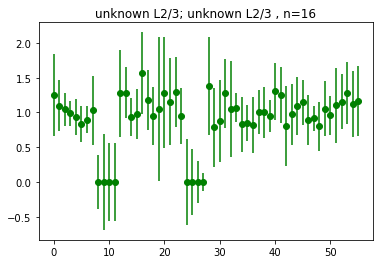

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt

df7.index  = df7.loc[:,'synapse_type_2']


types = list(set(df7.loc[:,'synapse_type_2']))
df7accum = pd.DataFrame()
i = 2

df7i = df7.loc[df7.loc[:,'synapse_type_2'].isin([types[i]]),:]
fits = df7i.loc[:,'stp_mean_fit_bootstrap'].values
fits = pd.DataFrame(np.stack(fits,axis=1)).replace(to_replace=0, value=np.nan).T
fits = fits.divide(fits.iloc[:,0:8].median(axis=1), axis=0)
fitsnan = np.isnan(fits).astype(float)

fitsnums = df7i.loc[:,'numbers_of_currents'].values
fitsnums = pd.DataFrame(np.stack(fitsnums,axis=1)).T #.replace(to_replace=0, value=np.nan).T


fitsm = pd.DataFrame(fits.median(axis=0)).T 
fitss = pd.DataFrame(fits.std(axis=0)).T 

fitsnanm = fitsnan.mean(axis=0)    # if less than 1/2 cells have some protocole - dont' use it
#fitsm1 = fitsm
fitsm.loc[0,fitsnanm>0.5] = 0 #np.nan
npar = 56

plt.errorbar(np.arange(npar), fitsm.loc[:,0:npar-1].values.ravel(), yerr=fitss.loc[:,0:npar-1].values.ravel(), fmt =  'go')
plt.gca().set_title(types[i] +' , n='+str(fits.shape[0]))    
#fitsnums = df7i.loc[:,'numbers_of_currents'].values
#fn1 = np.array(fitsnums.loc[0,:][0].split()).astype(int)
#fitsnums = pd.DataFrame(np.stack(fitsnums,axis=1)).T #.replace(to_replace=0, value=np.nan).T
    

In [174]:
# aggregate some synaptic types
fn1 = 'numbers_of_synaptic_types_with_fited_pulses_corrected.xlsx'
fn2 = 'numbers_of_synaptic_types_with_fited_pulses_corrected2.xlsx'
dfc1 = pd.read_excel(fn1)
dfc2 = pd.read_excel(fn2)
if old_pandas:
    dfc1=dfc1.set_index('Unnamed: 0')
    dfc2=dfc2.set_index('Unnamed: 0')

In [175]:
dfc2.head()

synapse_type_2  Unnamed: 2
Unnamed: 0                                        
pvalb L5; pvalb L5                  61         NaN
sim1 L5; sim1 L5                    51         NaN
pvalb L2/3; pvalb L2/3              37         NaN
pvalb L6; pvalb L6                  24         NaN
pvalb L4; pvalb L4                  23         NaN

In [176]:
dfc1.head()

synapse_type_2  Unnamed: 2  Unnamed: 3
Unnamed: 0                                                    
pvalb L5; pvalb L5                  61         NaN         NaN
sim1 L5; sim1 L5                    51         NaN         NaN
pvalb L2/3; pvalb L2/3              37         NaN         NaN
pvalb L6; pvalb L6                  24         NaN         NaN
pvalb L4; pvalb L4                  23         NaN         NaN

In [177]:
types0 = list(set(df7.loc[:,'synapse_type_2']))
types = []

if old_pandas:
    coln = 'Unnamed: 2'
else:  
    coln = 'Unnamed: 1'
    
for i in range(len(types0)):
    ty0 = types0[i]
    typesi = [ty0]
    
    dfc1i = np.nonzero((dfc1.index==ty0))[0] + 2
    if len(dfc1i)>0:
        dfc1i2 = dfc1.loc[:,coln ]==dfc1i[0]
        if sum(dfc1i2)>0:
            typesi = typesi + dfc1.index[dfc1i2].tolist()
        
    dfc2i = np.nonzero((dfc2.index==ty0))[0][0] + 2
    dfc2i2 = dfc2.loc[:,coln ]==dfc2i
    if sum(dfc2i2)>0:
        typesi = typesi + dfc2.index[dfc2i2].tolist()    
        
    types = types + [typesi]    

In [178]:
types

[['unknown L5; tlx3 L5'],
 ['pvalb L5; nr5a1 L4', 'pvalb L; nr5a1 L4', 'pvalb L4; nr5a1 L5'],
 ['unknown L2/3; unknown L2/3'],
 ['pvalb,sst L5; pvalb L5'],
 ['vip L2/3; pvalb L2/3'],
 ['sst L6; ntsr1 L6'],
 ['sst L2/3; sst L2/3', 'sst L4; sst L2/3', 'sst L4; sst L4'],
 ['unknown L; unknown L2/3'],
 ['unknown L2/3; pvalb L2/3'],
 ['sst L5; sst L5', 'sst L6; sst L5'],
 ['unknown L5; sst L5'],
 ['slc17a8 L5; slc17a8 L5'],
 ['sim1 L5; pvalb L5', 'sim1,pvalb L5; pvalb L5', 'unknown L5; pvalb L5'],
 ['pvalb L4; pvalb L5'],
 ['unknown L5; unknown L5',
  'unknown L5; sim1 L5',
  'tlx3 L5; fam84b L5',
  'unknown L5; tlx3 L5',
  'unknown L5; rorb L5',
  'unknown L5; unknown L'],
 ['nr5a1 L4; nr5a1 L4', 'nr5a1 L2/3; nr5a1 L2/3'],
 ['sst L5; sim1 L5', 'sst L2/3; sim1 L5'],
 ['pvalb L2/3; pvalb L4'],
 ['pvalb L4; nr5a1 L5'],
 ['vip L2/3; sst L2/3'],
 ['pvalb L2/3; sst L2/3', 'pvalb L5; sst L5', 'pvalb L6; sst L6'],
 ['vip L6; vip L'],
 ['sim1 L5; sim1 L5'],
 ['pvalb L4; nr5a1 L4'],
 ['pvalb L4; pva

In [179]:
#plt.plot(np.mean(fitss4.reshape((-1,npar)),axis=0  ))
#np.nonzero(fitss4.ravel()==0)[0]

1


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


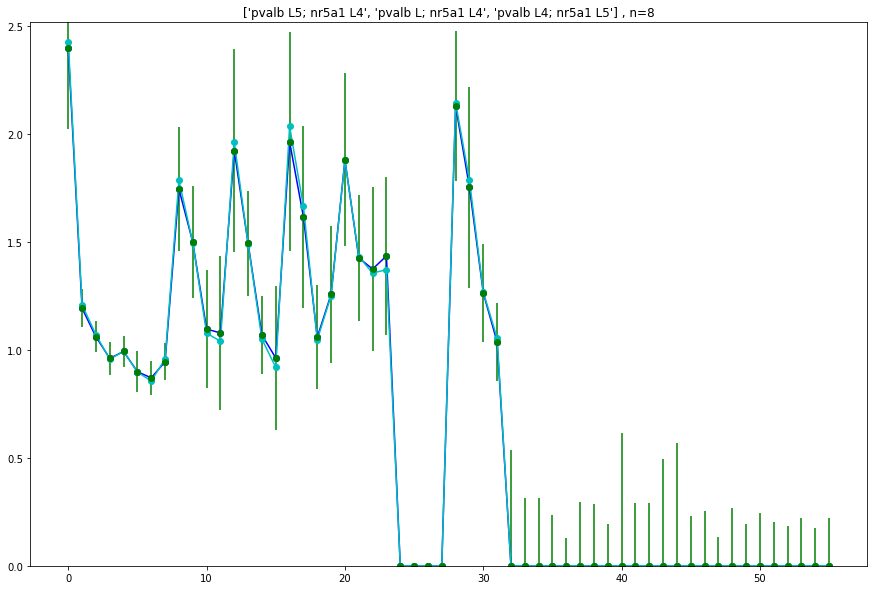

2


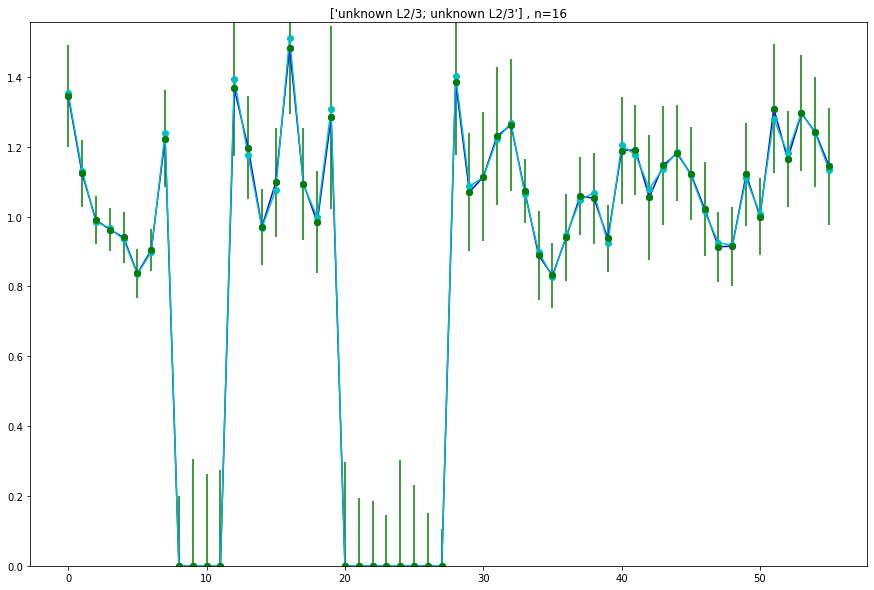

6


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


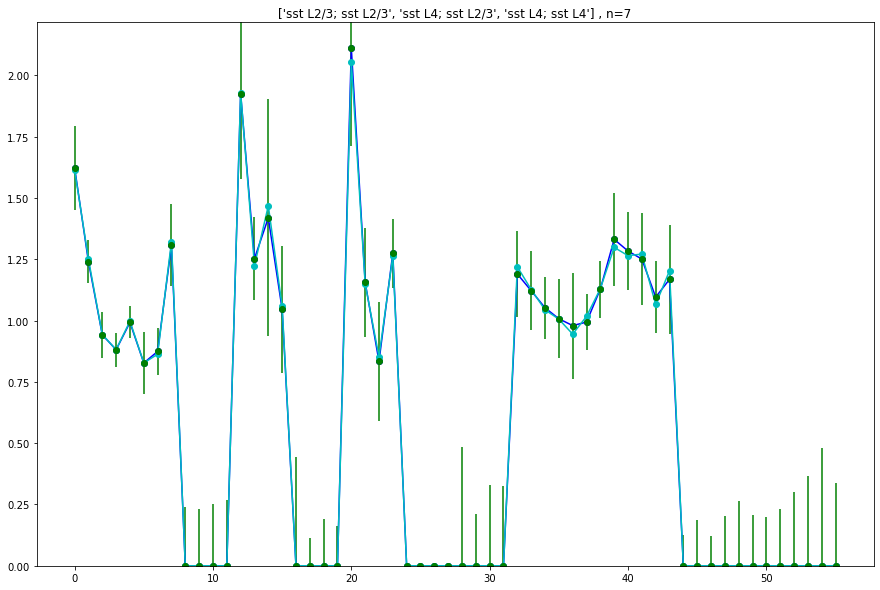

8


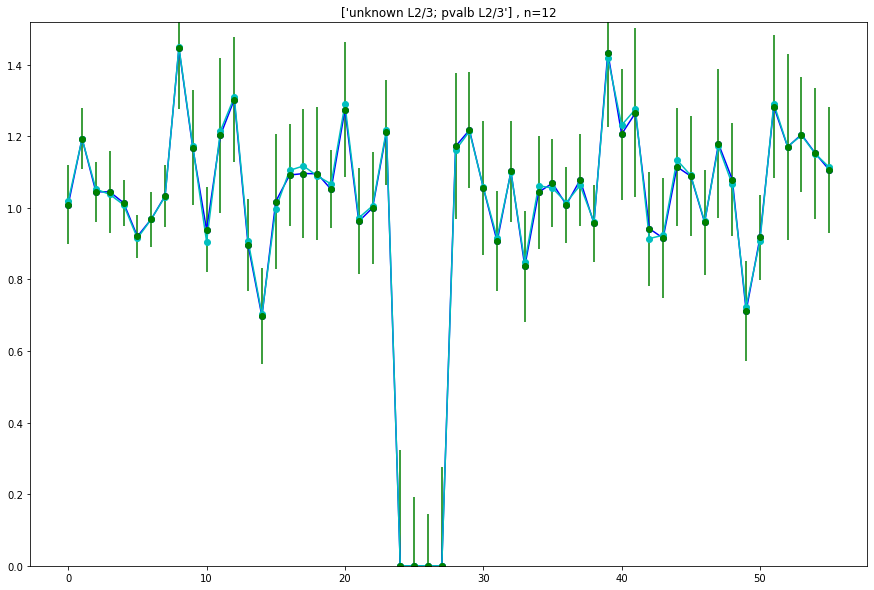

9


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


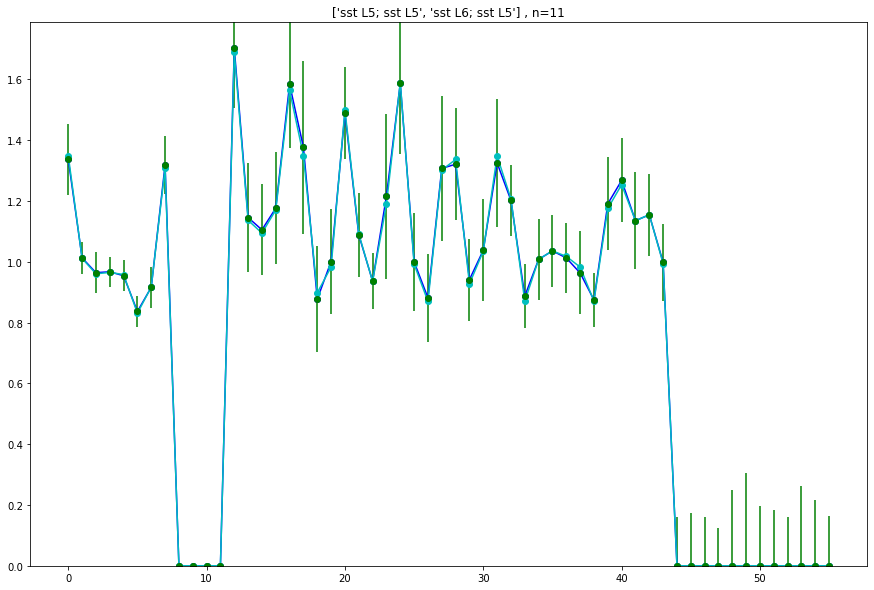

12


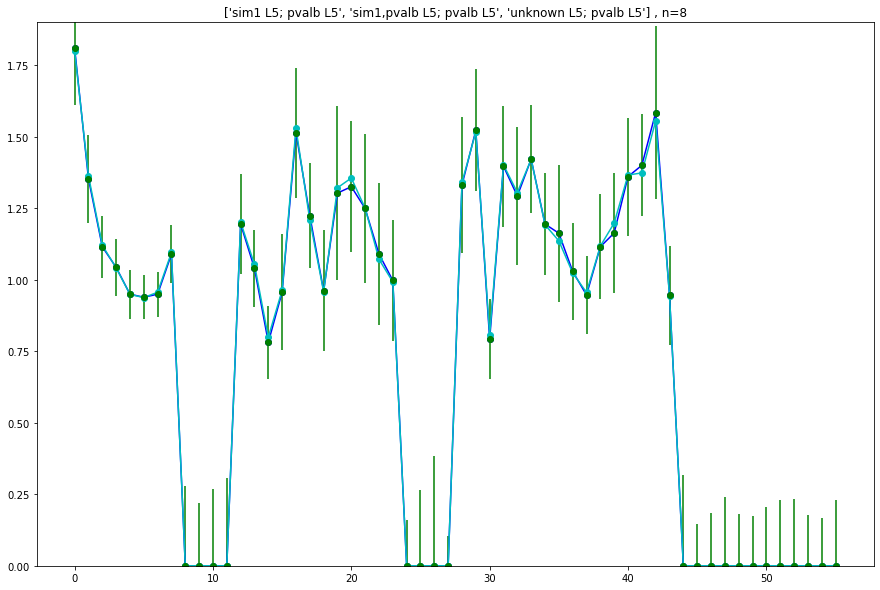

14


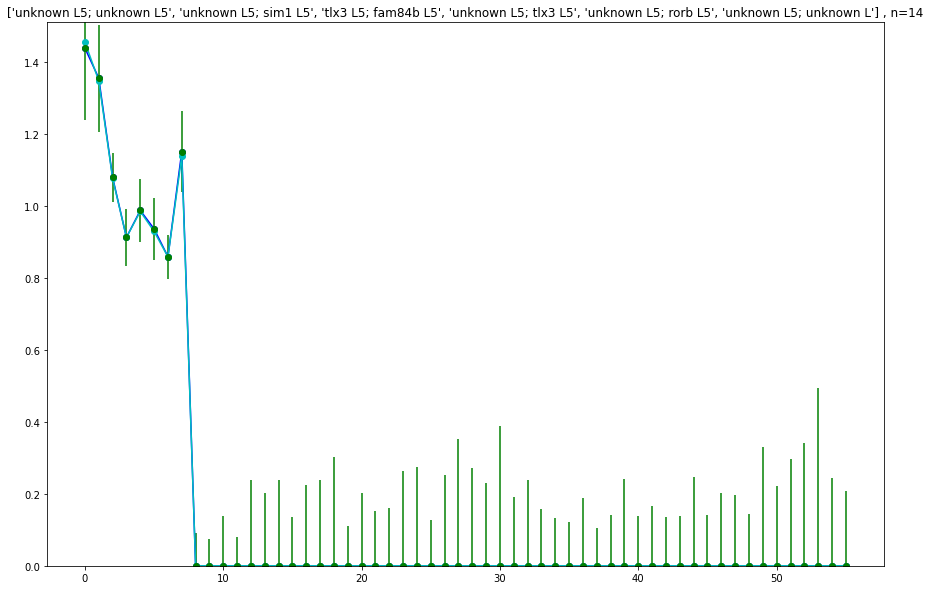

15


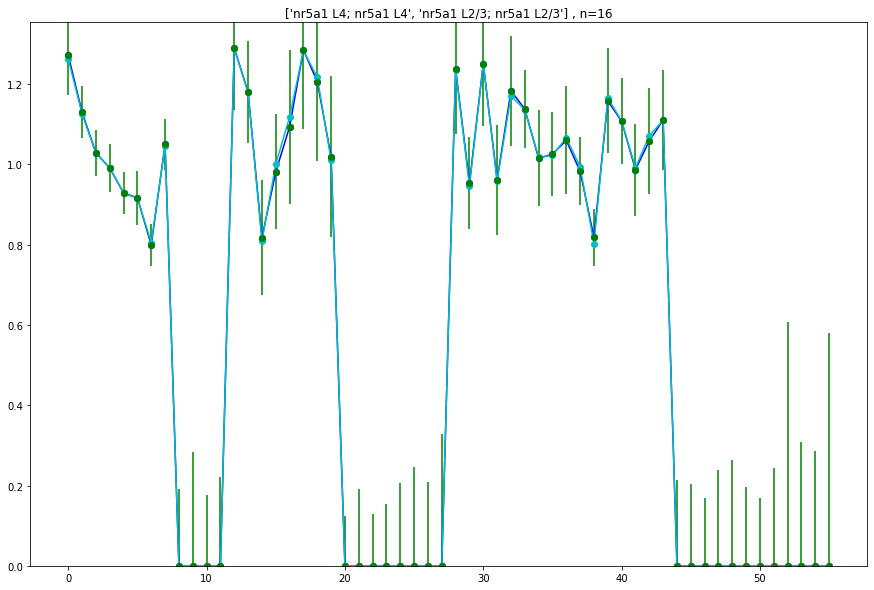

16


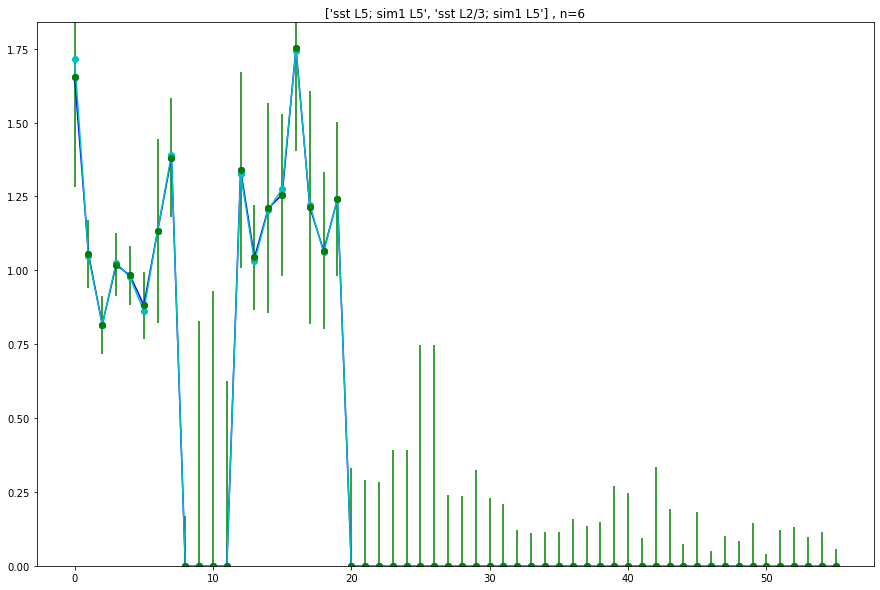

19


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


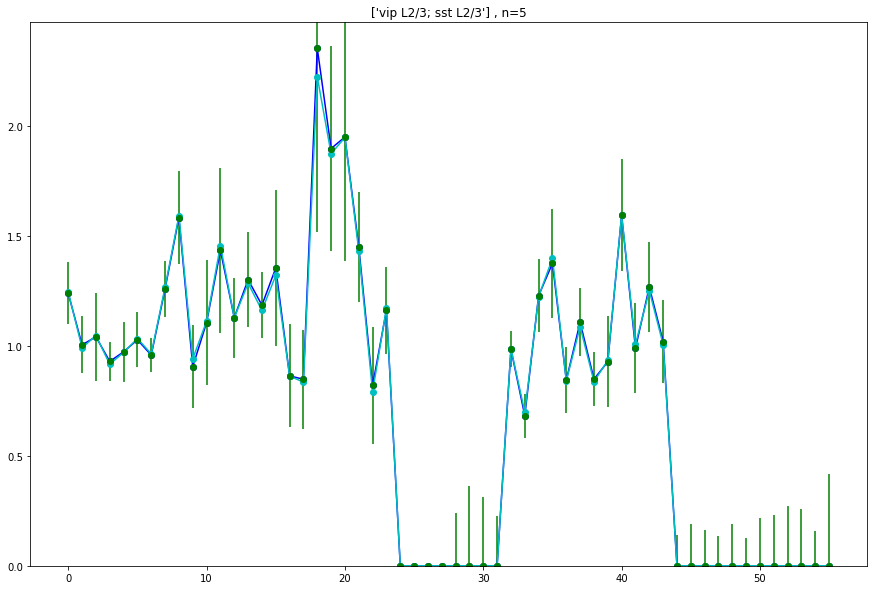

20


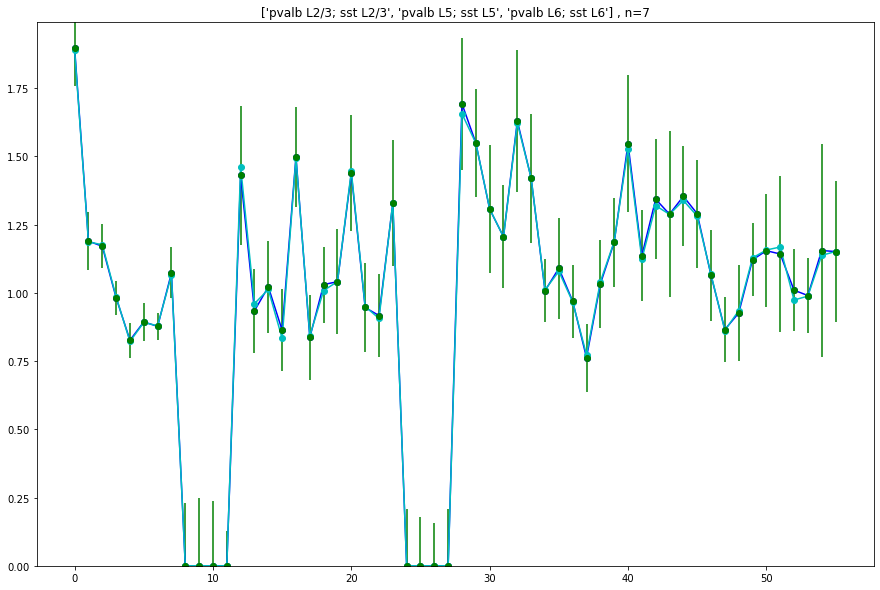

22


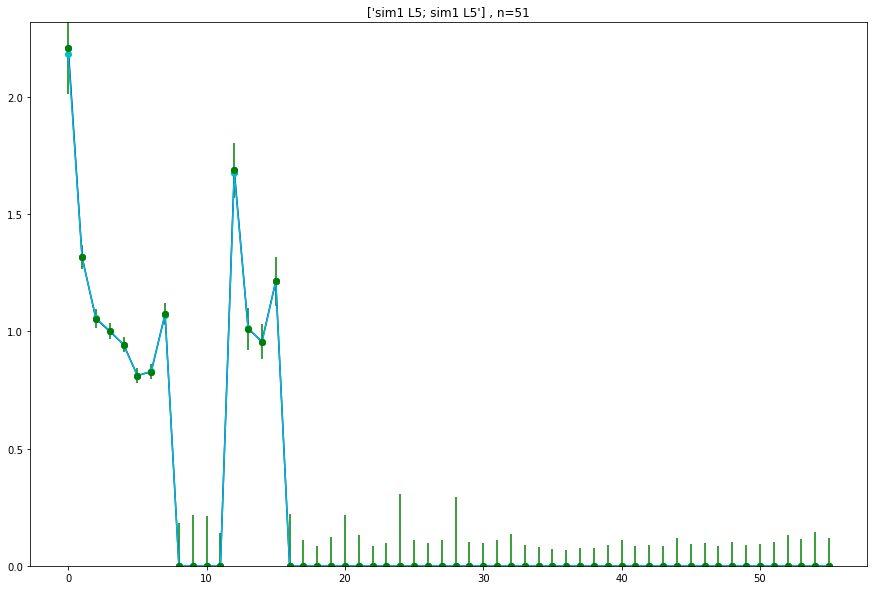

23


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


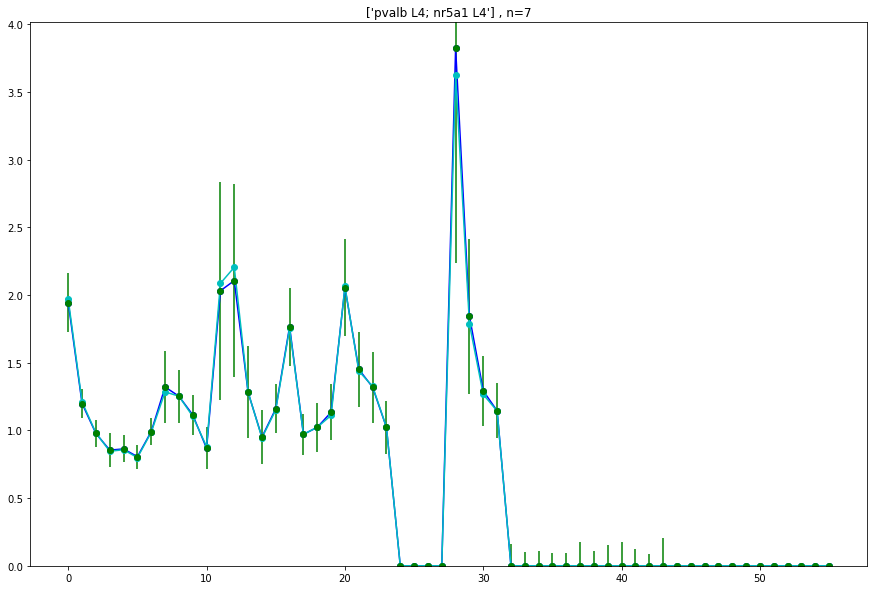

24


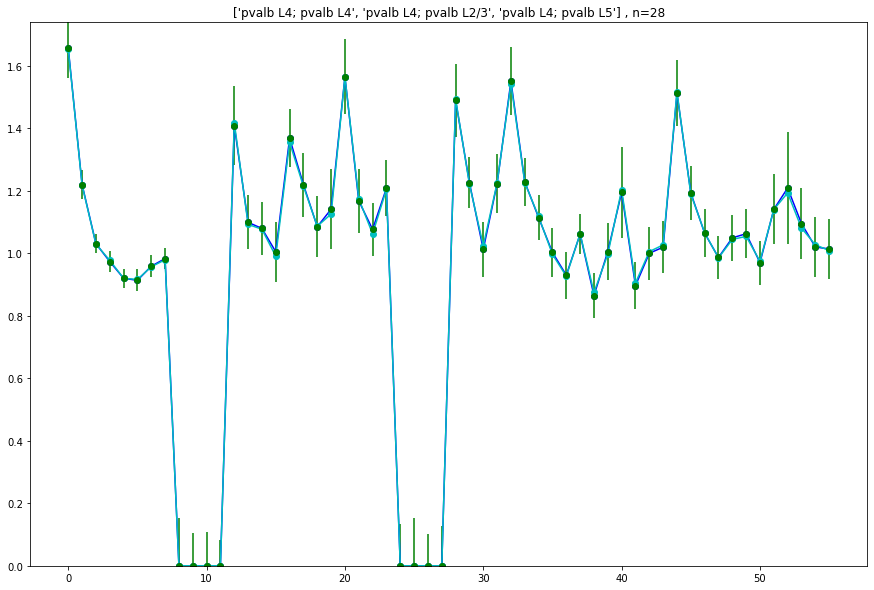

25


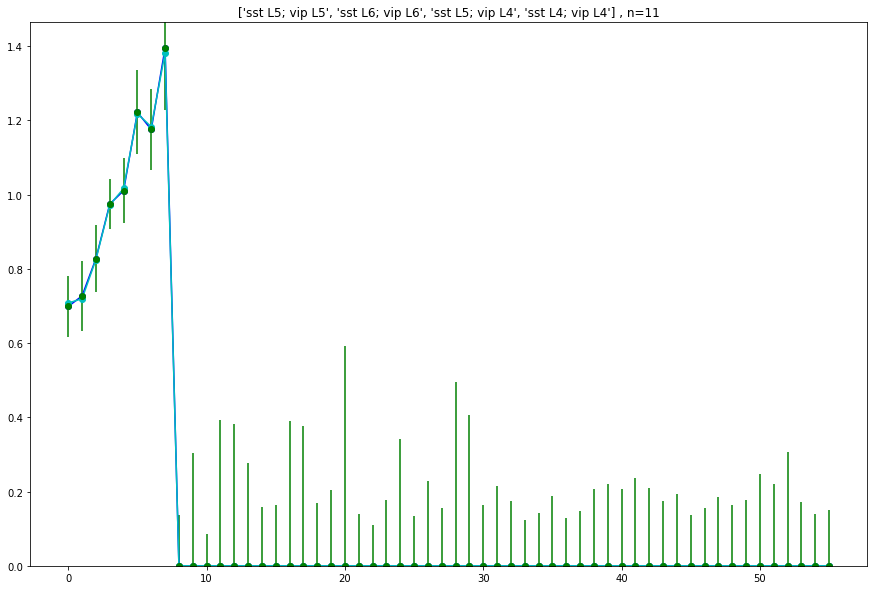

27


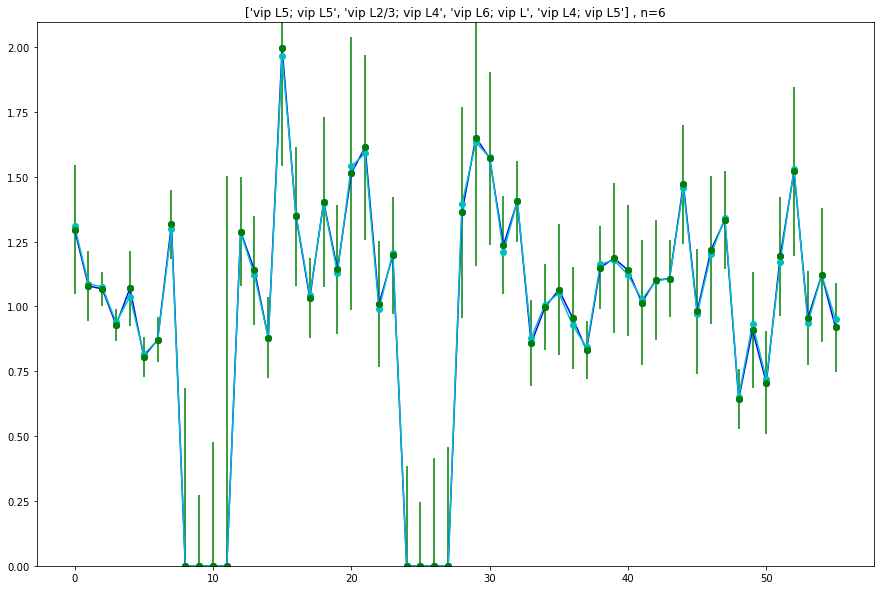

30


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


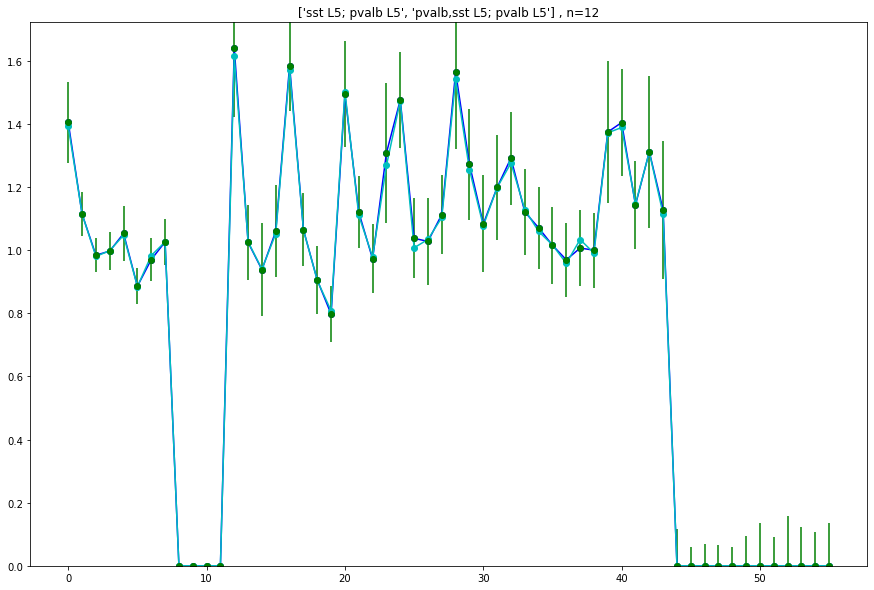

34


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


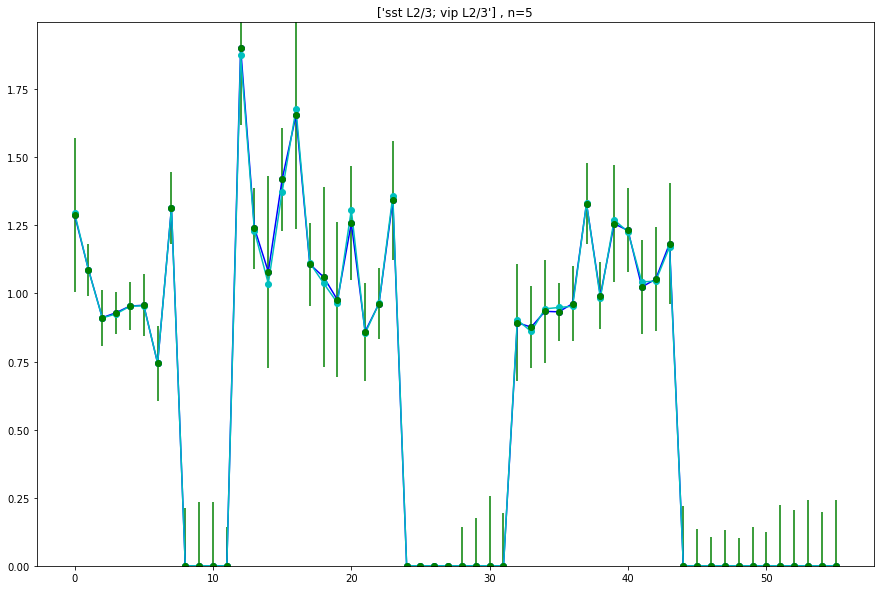

42


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


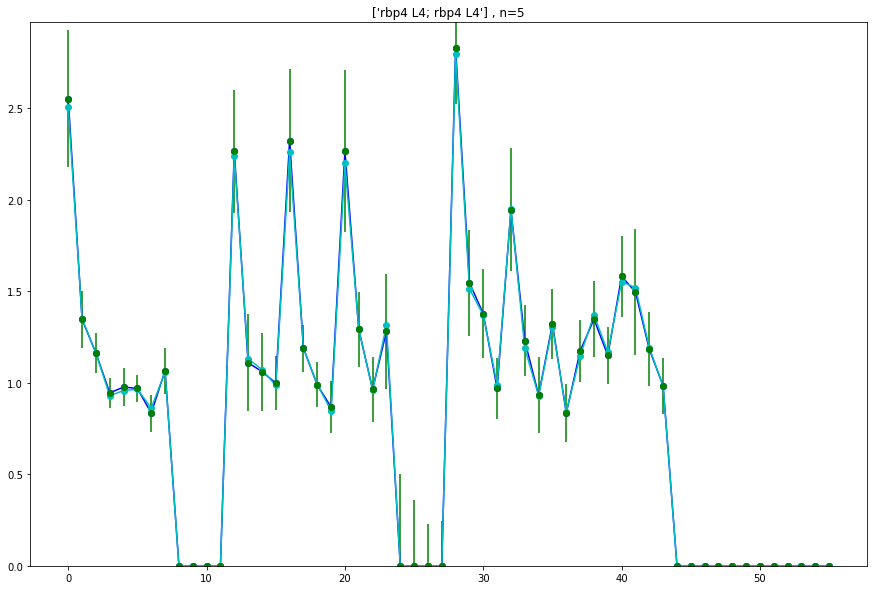

46


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


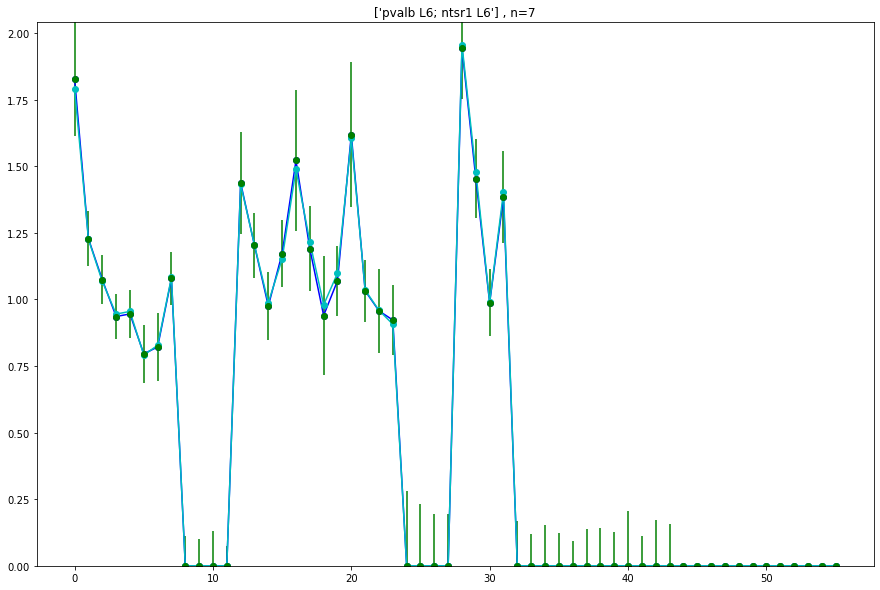

47


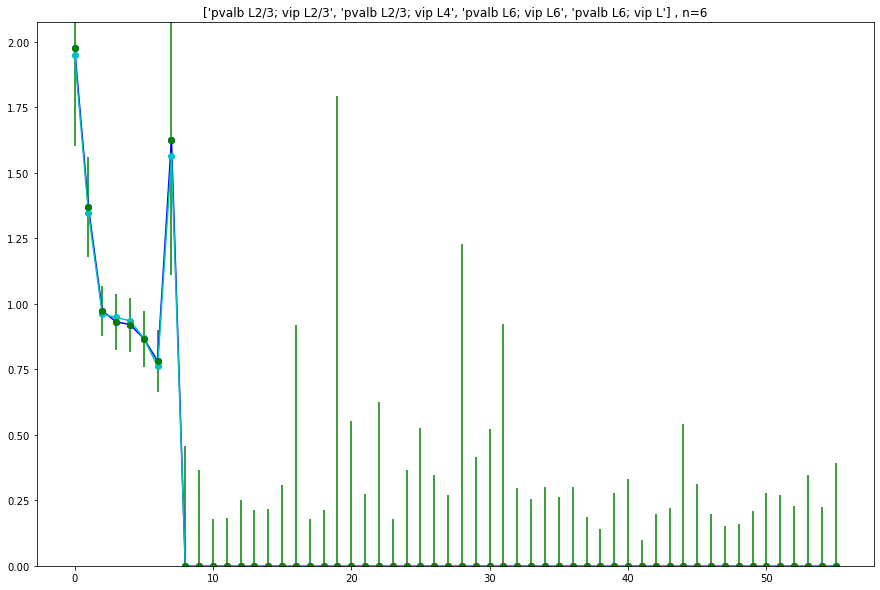

51


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


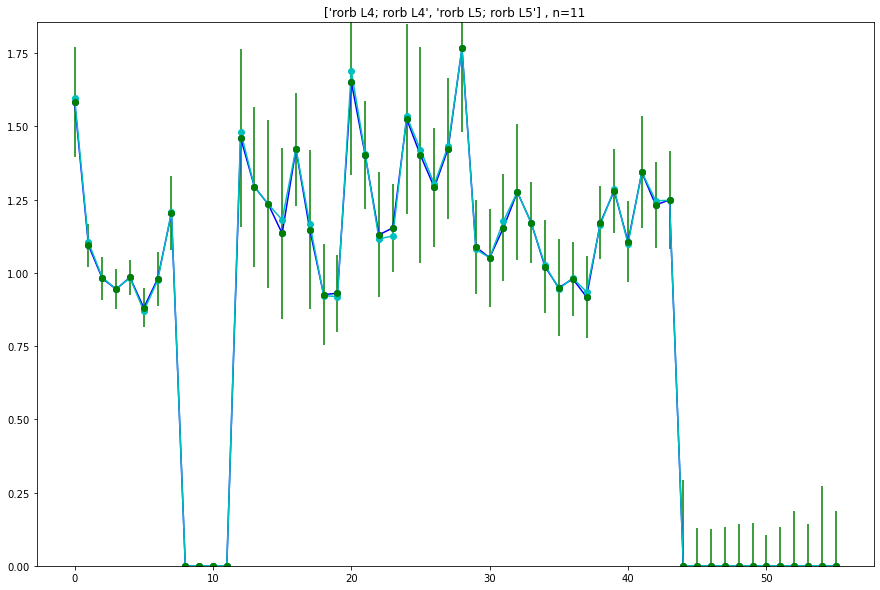

52


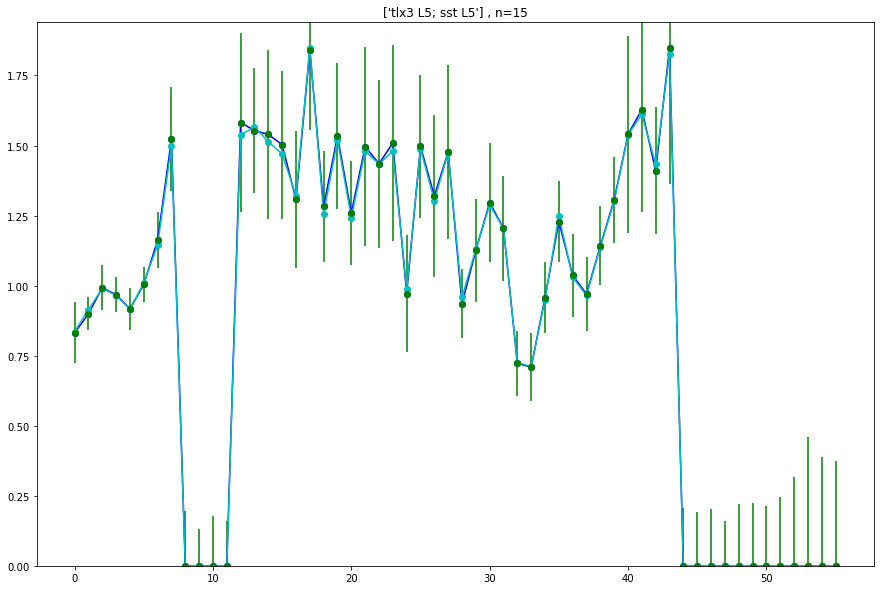

54


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


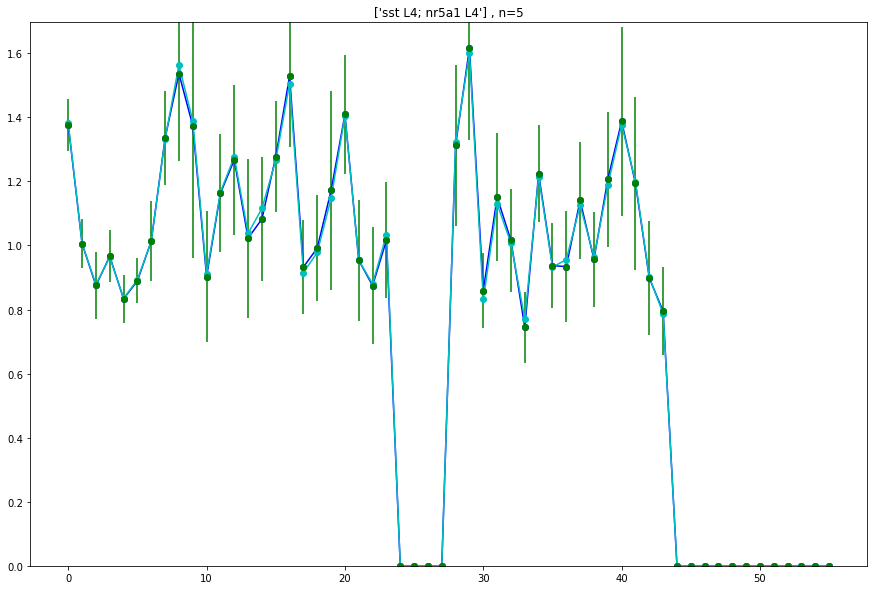

56


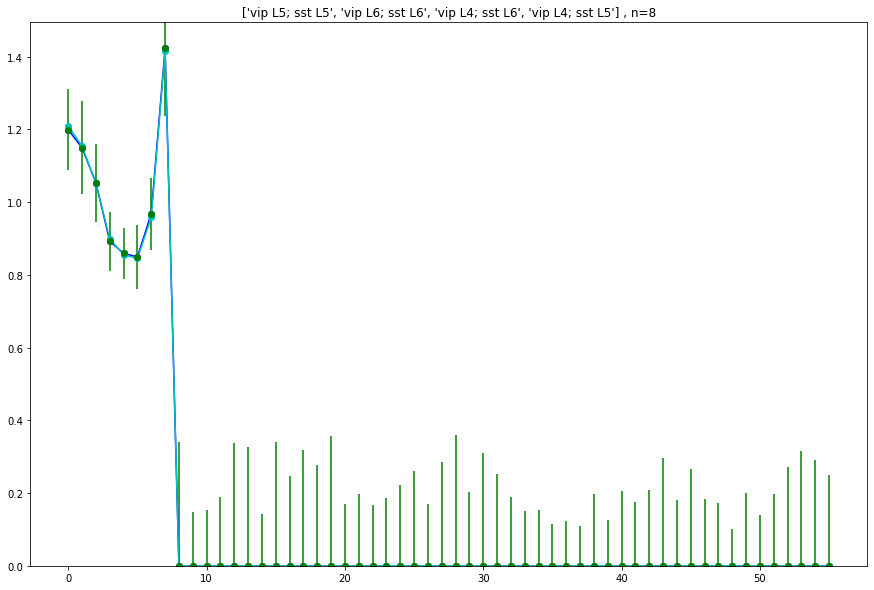

59


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


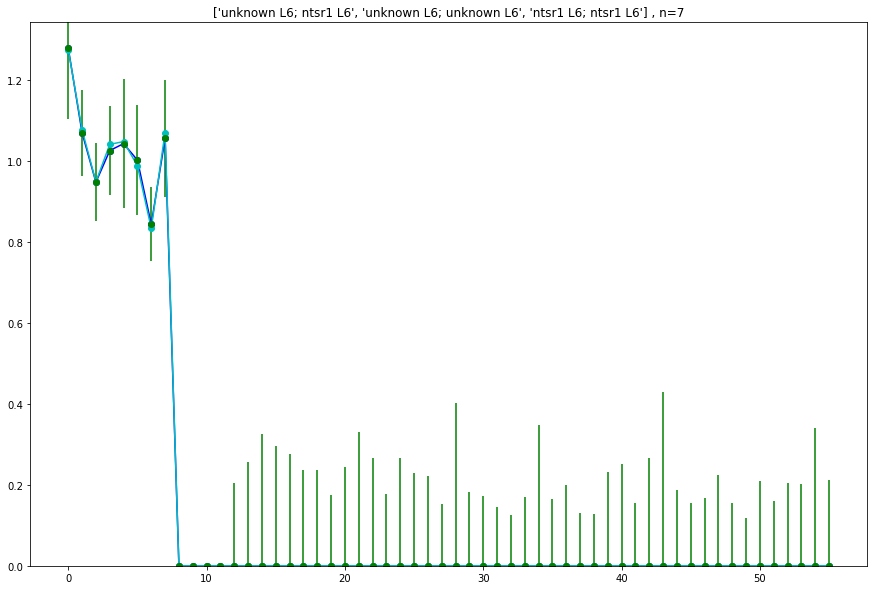

62


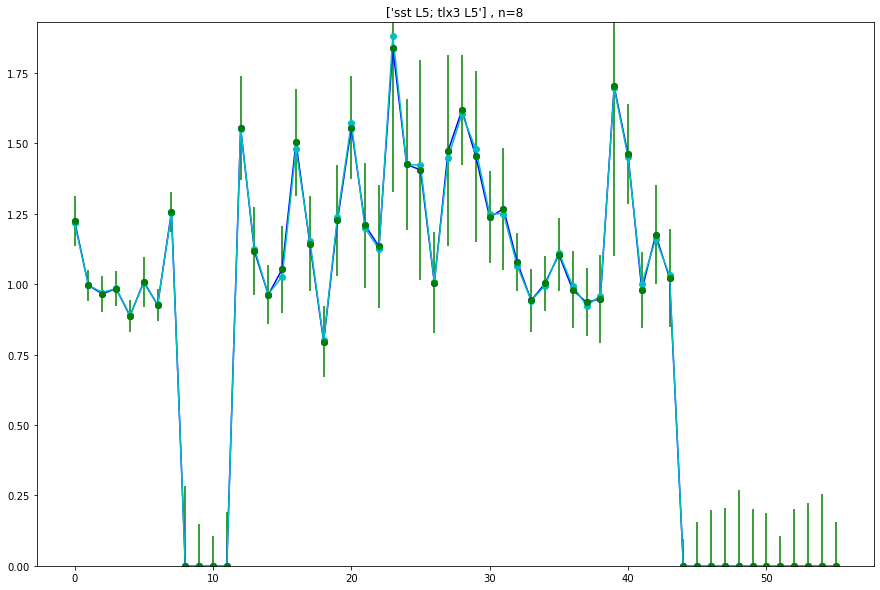

63


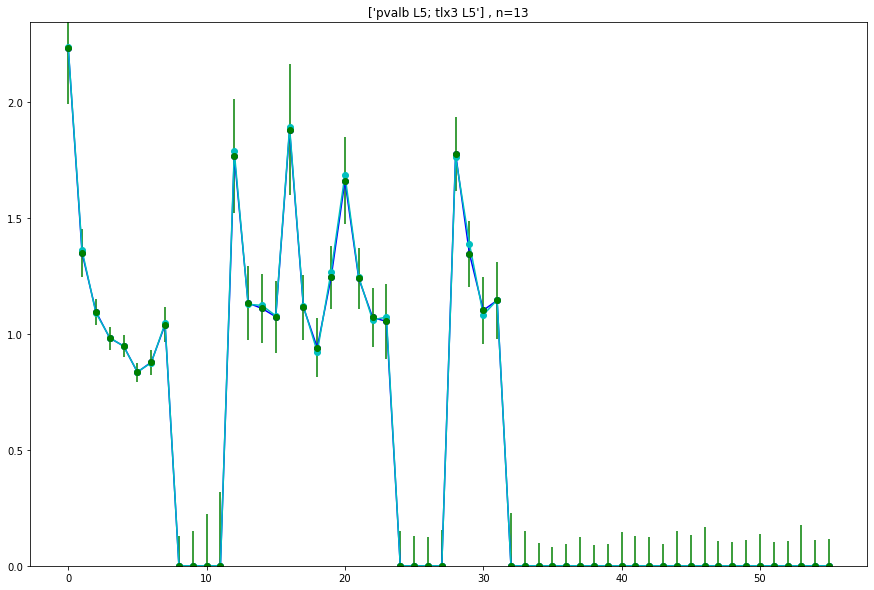

66


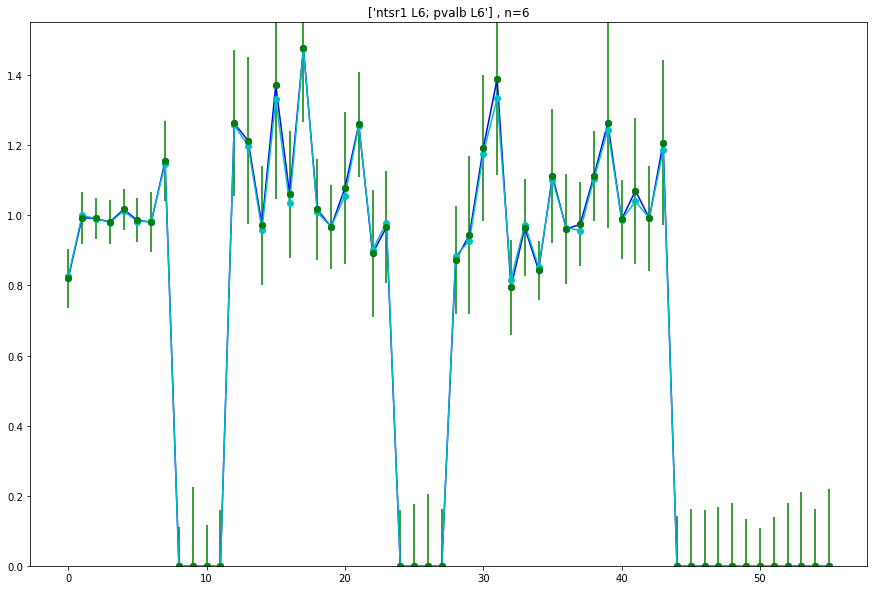

67


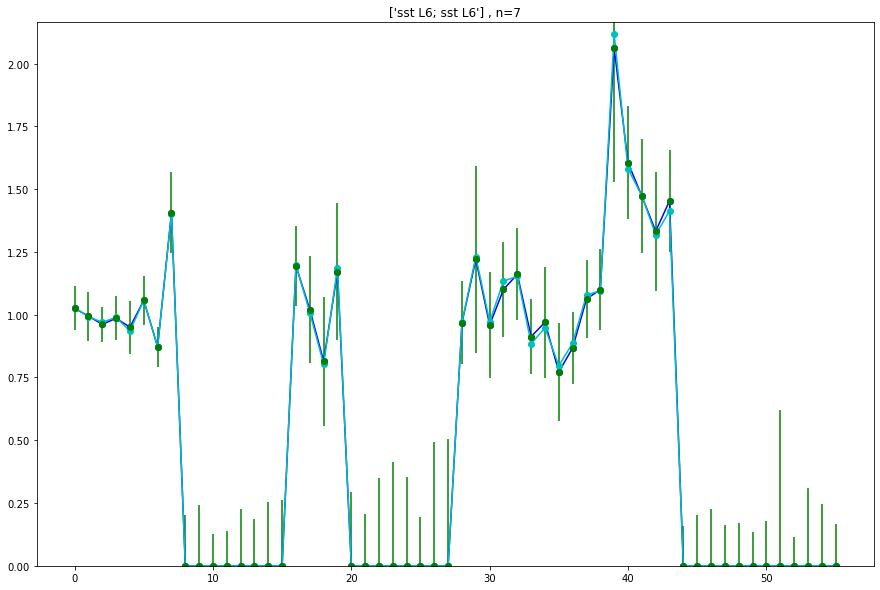

71


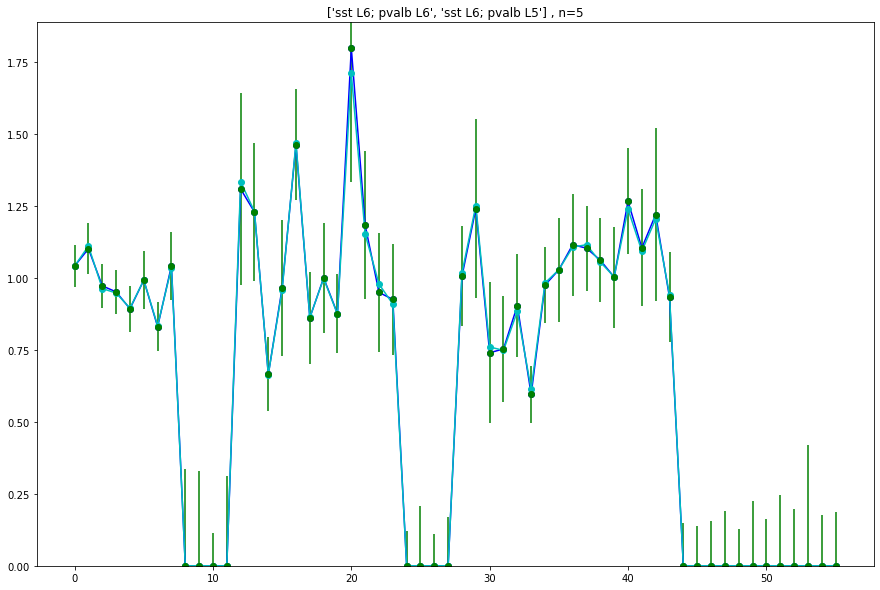

76


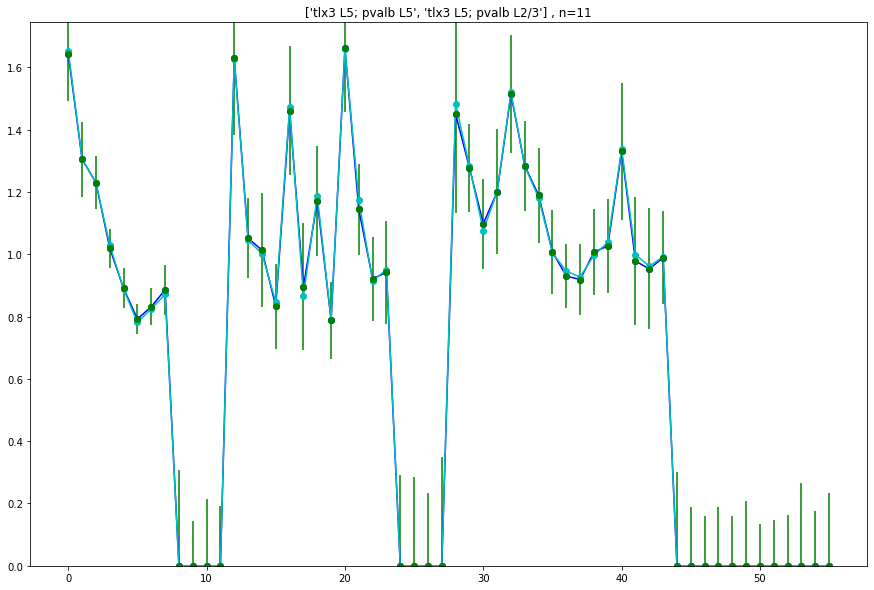

82


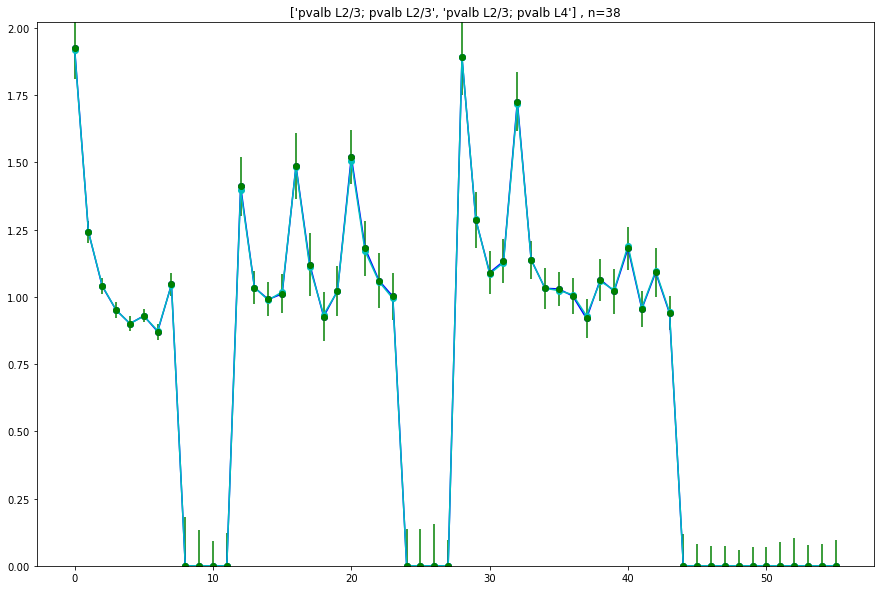

83


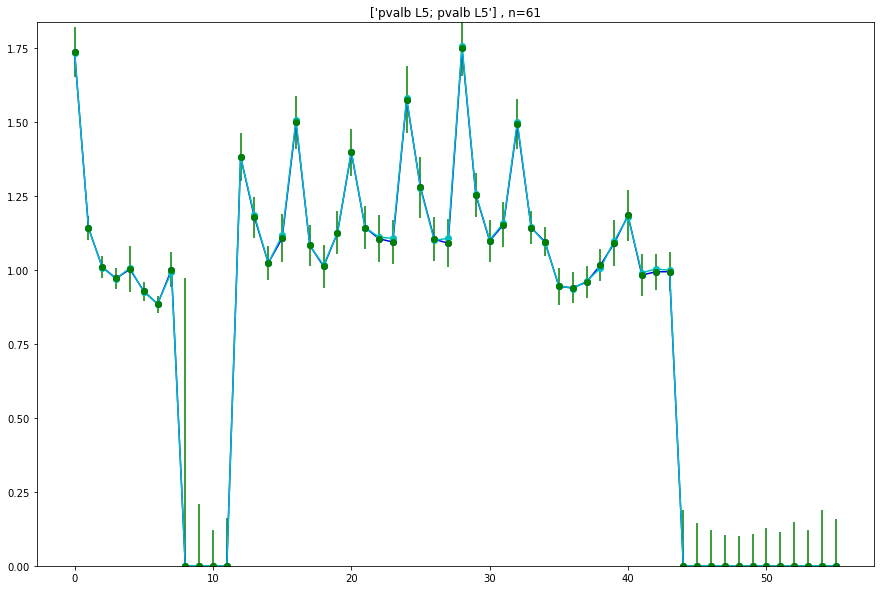

85


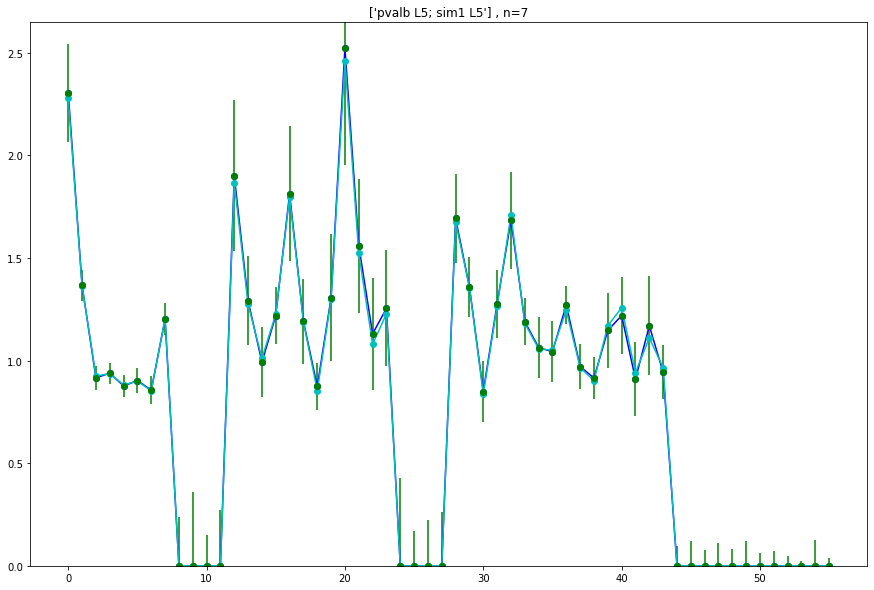

86


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


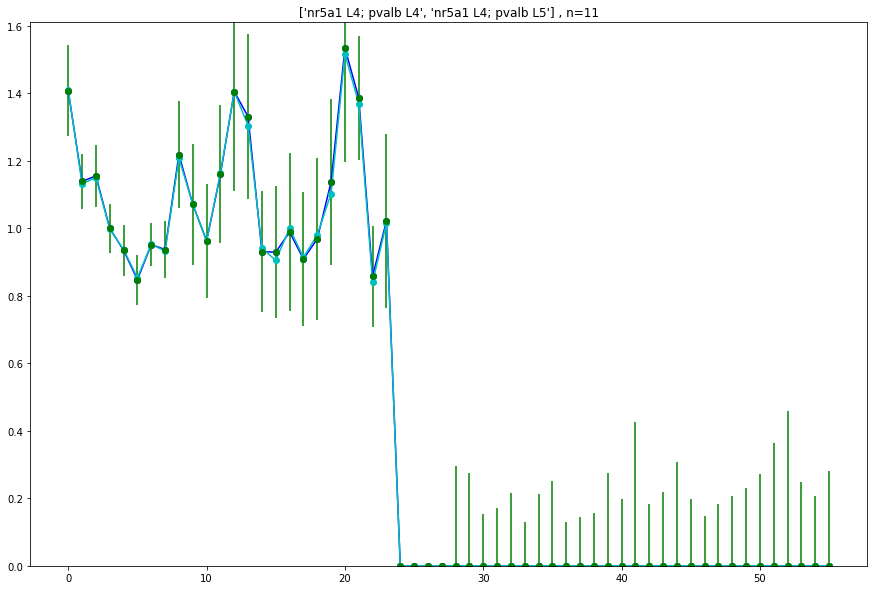

88


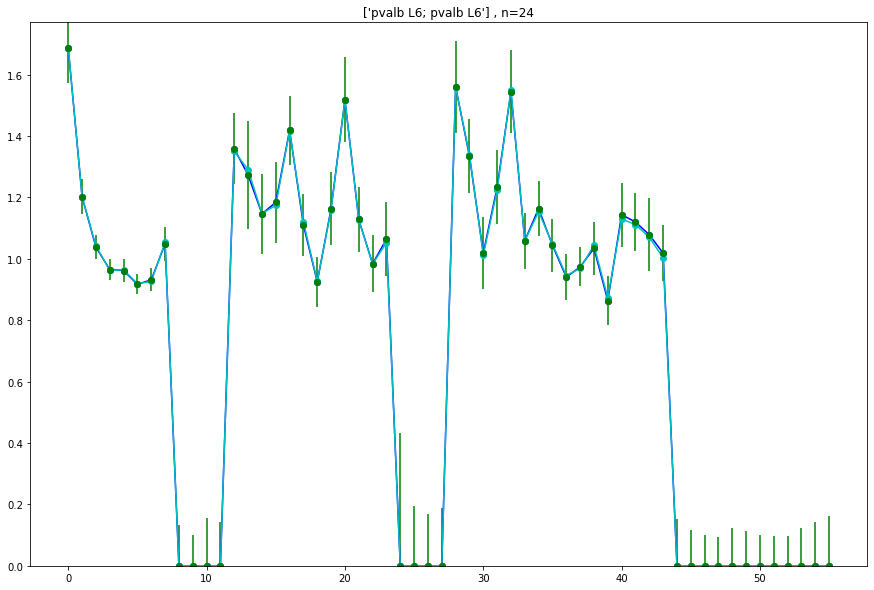

89


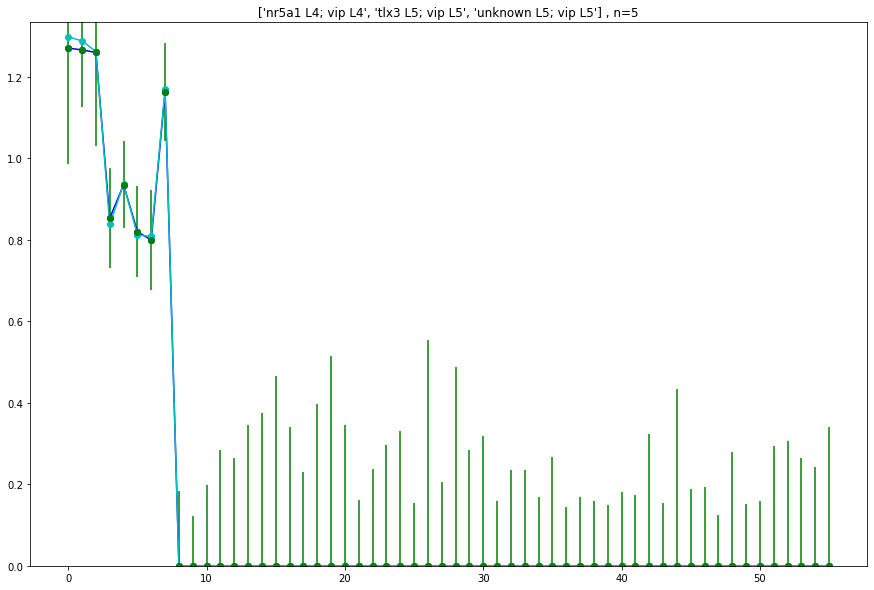

91


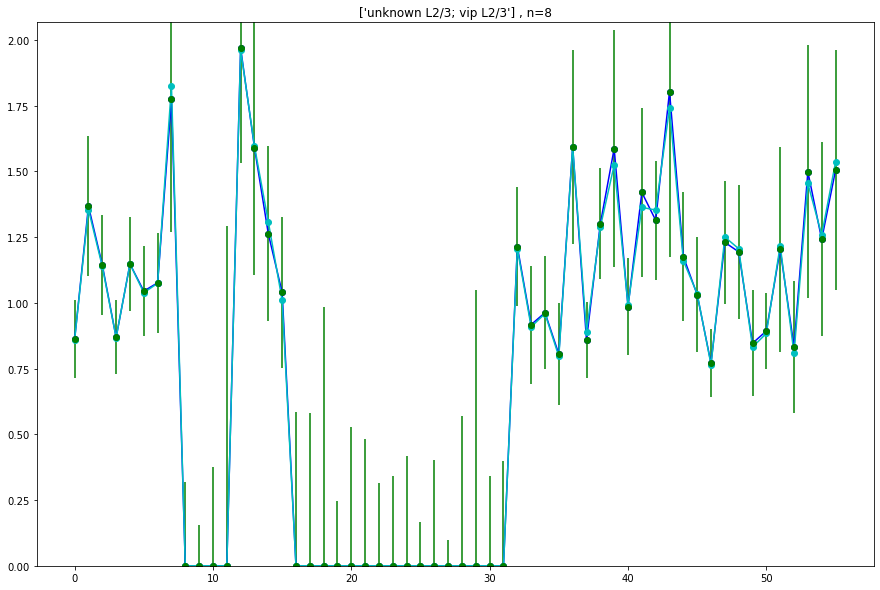

92


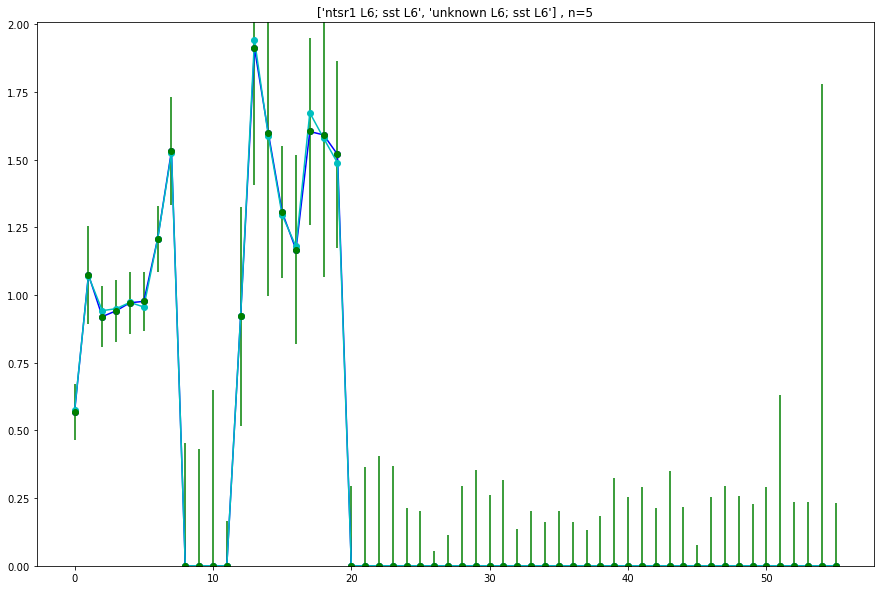

93


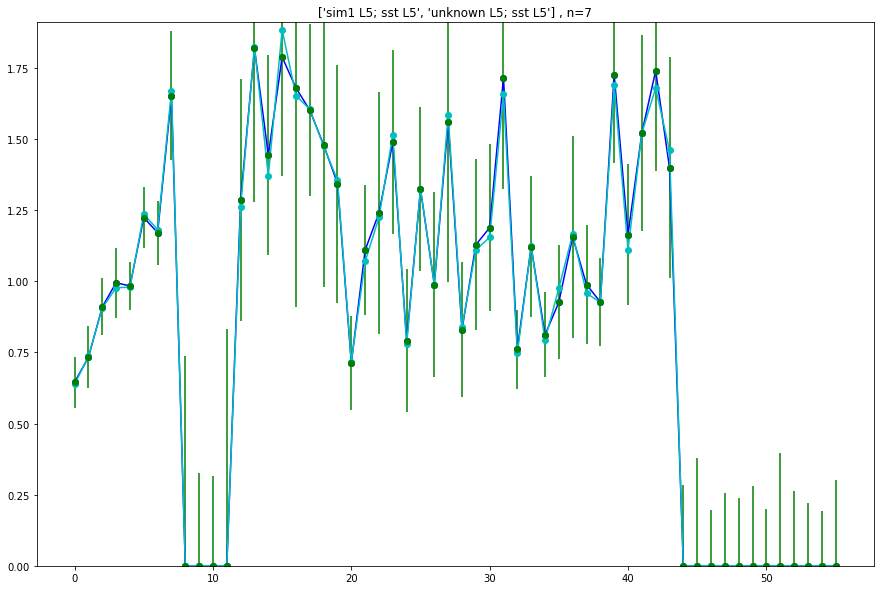

95


<ipython-input-180-65258fce9001>:42: RuntimeWarning: Mean of empty slice
  fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )


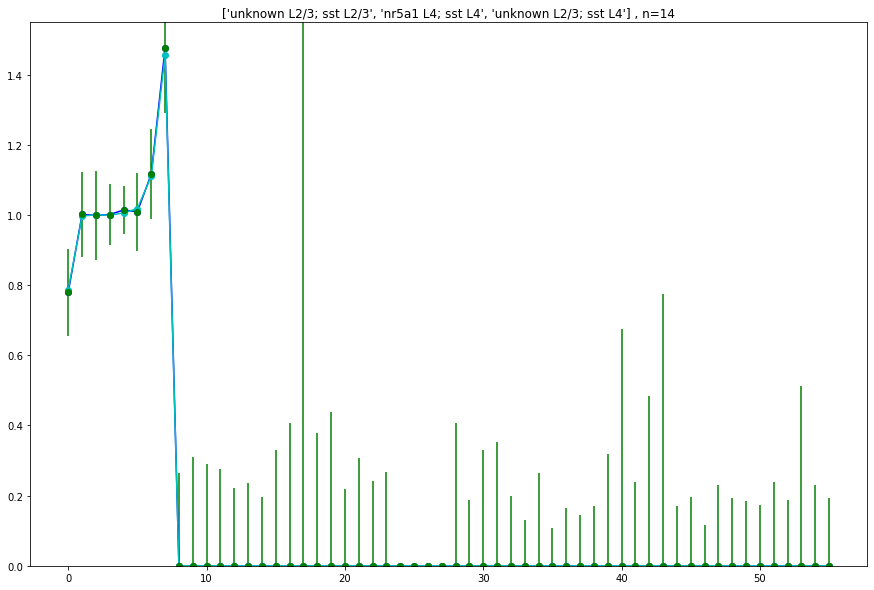

98


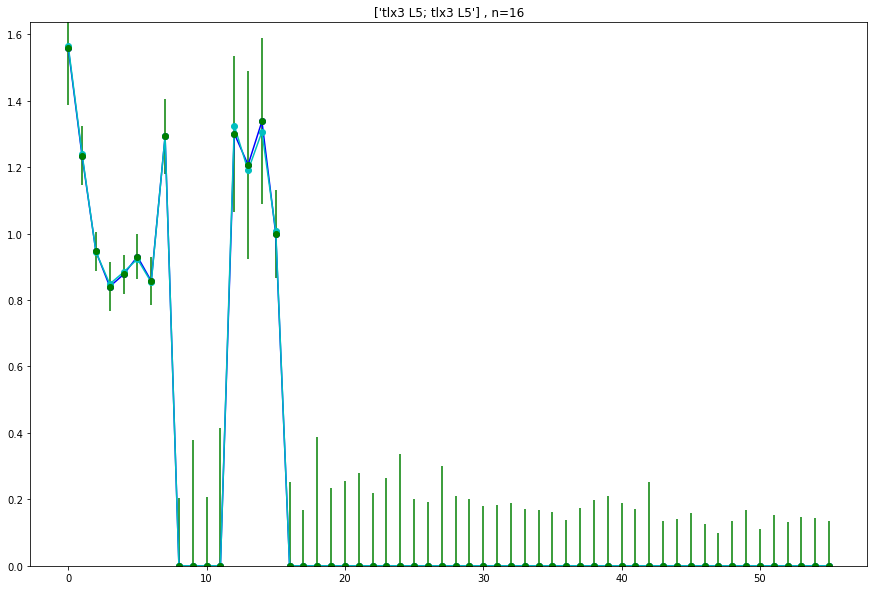

(43, 11210)

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

#types = list(set(df7.loc[:,'synapse_type_2']))
df7accum = pd.DataFrame()
Fitss2 = []
for i in  range(len(types)): #range(len(types)): #range(len(types)):
    df7i = df7.loc[df7.loc[:,'synapse_type_2'].isin(types[i]),:]
    fits = df7i.loc[:,'stp_mean_fit_bootstrap'].values
    fits = pd.DataFrame(np.stack(fits,axis=1)).replace(to_replace=0, value=np.nan).T
    ##fits = fits.divide(fits.iloc[:,0:8].median(axis=1), axis=0)
    fits = fits.divide(fits.iloc[:,0:8].median(axis=1), axis=0)

    if fits.shape[0]>=5:
        print(i)
        
        fitsnan = np.isnan(fits).astype(float)
        fitsnums = df7i.loc[:,'numbers_of_currents'].values
        fitsnums = pd.DataFrame(np.stack(fitsnums,axis=1)).T #.replace(to_replace=0, value=np.nan).T
                
        npar = 56
        
        do_bootstrap_here=1
        if do_bootstrap_here==1:
            nc = int(fits.shape[1]/npar)
            vv = np.arange(npar)
            fitsm1 = fits.copy()
            
            for c in range(1,nc):
                ibs = np.random.randint(0, high=fits.shape[0], size=fits.shape[0])
                cbs = np.random.randint(0, high=nc, size=fits.shape[0])
                for ib in range(len(ibs)):
                    
                    #fitsm.iloc[0,c*npar + vv ] = fits.iloc[ibs,c*npar + vv ].median(axis=0)
                    fitsm1.iloc[ib,c*npar + vv ] = fits.iloc[ibs[ib],cbs[ib]*npar + vv ].values #.median(axis=0)
            fitsm = pd.DataFrame(fitsm1.mean(axis=0)).T    
            fitss4 = pd.DataFrame(scipy.stats.sem(fitsm1.values, axis=0,  nan_policy='omit')).T
        else:
            fitsm = pd.DataFrame(fits.median(axis=0)).T 
         
        fitss5 = np.nanmean(fitss4.values.reshape((-1,npar)),axis=0  )
        fitss = pd.DataFrame(fits.std(axis=0)).T 

        fitsnanm = fitsnan.mean(axis=0)    # if less than 1/2 cells have some protocol data - dont' use it
        #fitsm1 = fitsm
        fitsm.loc[0,fitsnanm>0.3] = 0 #np.nan   
        
        fitsms = pd.DataFrame(np.reshape(fitsm.values, (-1,npar)))
        fitsss = pd.DataFrame(np.reshape(fitsm.values, (-1,npar)))
        fitsm2 =fitsms.mean(axis=0,skipna=True)
        
        do_bootstrap_sigma=True
        if do_bootstrap_sigma==False:
            fitss2 =fitss.loc[:,0:npar-1].values.ravel() #fitsss.mean(axis=0,skipna=True)
        else:
            fitss2 =fitsss.std(axis=0,skipna=True)
         
        # fill nans and set mean=0 if sigma==0 to not fit this points
        fitsm = fitsm.fillna(value=0)
        fitss2 = np.nan_to_num(fitss2)
        fitss4 = np.nan_to_num(fitss4.values)
        fitss5 = np.nan_to_num(fitss5)
        
        #iz = np.nonzero(fitss2==0)[0]
        #if len(iz)>0:
        #    fitsm.iloc[0,iz]=0  # only first bootstrap will be filled with zeros!!!
        iz = np.nonzero(fitss4.ravel()==0)[0]
        if len(iz)>0:
            fitsm.iloc[0,iz]=0  # only first bootstrap will be filled with zeros?
        
        #breakpoint()

        
        fitsn = pd.DataFrame(df7i.iloc[0,0:10]).T
        fitsm.index = fitsn.index
        fitss.index = fitss.index
        fitsmn = pd.concat([fitsn, fitsm ],axis=1)
        #df7accum = pd.concat([df7accum, fitsmn ],axis=0)

        df7accum = pd.concat([df7accum, fitsmn ],axis=0)

        

        #Fitss2 = Fitss2 + [fitss2]
        Fitss2 = Fitss2 + [fitss4]

        f, ax =plt.subplots(figsize=(15, 10))
        #f, ax = plt.figure()
        #ax = f.add_axes()
        #plt.title(stp_columns[i])
        #plt.title(types[i] +' , n='+str(fits.shape[0]))
        
        plt.plot(fitsm2,'bo-')
        plt.plot(fitsm.iloc[0,0:npar],'co-')
        plt.gca().set_title(str(types[i]) +' , n='+str(fits.shape[0]))
        plt.ylim((0,max(fitsm2)*1.05)) 
        #plt.hold(True)
        #fitss5  = np.mean(fitss4.reshape( (-1,npar)).T)
        plt.errorbar(np.arange(len(fitsm2)), fitsm2, yerr=fitss5, fmt =  'go')
        #plt.xticks(np.arange(len(yy1l.index)), yy1l.index, rotation=90)
        #plt.hold(False)
        #plt.pause(0.5) 
        
        df7accum.loc[df7accum.index[-1],'comments'] = str(types[i]) +' , n='+str(fits.shape[0])
        
        plt.pause(0.1)
df7accum.shape        

In [181]:
### repack accumulated stp data for fitting

In [182]:
df8 = pd.DataFrame([],columns = df.columns[11:])

for i in range(len(df7accum.index)):
    df10 = pd.DataFrame([[],[], [df7accum.iloc[i,10:].values],[Fitss2[i]]],index = df.columns[11:], columns = [df7accum.index[i]]).T
    df8 = pd.concat([df8,df10],axis=0)



df9 =pd.concat([df7accum.iloc[:,0:10],df8],axis=1)
df9

name  \
pvalb L4; nr5a1 L5          [aba_2019_synphys_pair_97450; pvalb L4; nr5a1 L5]   
unknown L2/3; unknown L2/3  [aba_2019_synphys_pair_78203; unknown L2/3; un...   
sst L2/3; sst L2/3          [aba_2019_synphys_pair_72416; sst L2/3; sst L2/3]   
unknown L2/3; pvalb L2/3    [aba_2019_synphys_pair_90113; unknown L2/3; pv...   
sst L5; sst L5                  [aba_2019_synphys_pair_22739; sst L5; sst L5]   
sim1 L5; pvalb L5            [aba_2019_synphys_pair_90379; sim1 L5; pvalb L5]   
tlx3 L5; fam84b L5          [aba_2019_synphys_pair_84116; tlx3 L5; fam84b L5]   
nr5a1 L2/3; nr5a1 L2/3      [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...   
sst L2/3; sim1 L5            [aba_2019_synphys_pair_80915; sst L2/3; sim1 L5]   
vip L2/3; sst L2/3          [aba_2019_synphys_pair_74057; vip L2/3; sst L2/3]   
pvalb L2/3; sst L2/3        [aba_2019_synphys_pair_92045; pvalb L2/3; sst ...   
sim1 L5; sim1 L5              [aba_2019_synphys_pair_62585; sim1 L5; sim1 L5]   
pvalb L4; nr5a1 L4          [aba_2019_synphys_pair_74339; pvalb L4; nr5a1 L4]   
pvalb L4; pvalb L2/3        [aba_2019_synphys_pair_78262; pvalb L4; pvalb ...   
sst L4; vip L4                  [aba_2019_synphys_pair_85538; sst L4; vip L4]   
vip L2/3; vip L4              [aba_2019_synphys_pair_85664; vip L2/3; vip L4]   
pvalb,sst L5; pvalb L5      [aba_2019_synphys_pair_28099; pvalb,sst L5; pv...   
sst L2/3; vip L2/3          [aba_2019_synphys_pair_67401; sst L2/3; vip L2/3]   
rbp4 L4; rbp4 L4              [aba_2019_synphys_pair_34697; rbp4 L4; rbp4 L4]   
pvalb L6; ntsr1 L6          [aba_2019_synphys_pair_57987; pvalb L6; ntsr1 L6]   
pvalb L2/3; vip L2/3        [aba_2019_synphys_pair_42202; pvalb L2/3; vip ...   
rorb L4; rorb L4              [aba_2019_synphys_pair_55151; rorb L4; rorb L4]   
tlx3 L5; sst L5                [aba_2019_synphys_pair_42553; tlx3 L5; sst L5]   
sst L4; nr5a1 L4              [aba_2019_synphys_pair_73279; sst L4; nr5a1 L4]   
vip L4; sst L5                  [aba_2019_synphys_pair_85546; vip L4; sst L5]   
ntsr1 L6; ntsr1 L6          [aba_2019_synphys_pair_61000; ntsr1 L6; ntsr1 L6]   
sst L5; tlx3 L5                [aba_2019_synphys_pair_42926; sst L5; tlx3 L5]   
pvalb L5; tlx3 L5            [aba_2019_synphys_pair_23389; pvalb L5; tlx3 L5]   
ntsr1 L6; pvalb L6          [aba_2019_synphys_pair_70309; ntsr1 L6; pvalb L6]   
sst L6; sst L6                  [aba_2019_synphys_pair_92558; sst L6; sst L6]   
sst L6; pvalb L5              [aba_2019_synphys_pair_58169; sst L6; pvalb L5]   
tlx3 L5; pvalb L2/3         [aba_2019_synphys_pair_69203; tlx3 L5; pvalb L...   
pvalb L2/3; pvalb L2/3      [aba_2019_synphys_pair_72007; pvalb L2/3; pval...   
pvalb L5; pvalb L5          [aba_2019_synphys_pair_17377; pvalb L5; pvalb L5]   
pvalb L5; sim1 L5            [aba_2019_synphys_pair_26232; pvalb L5; sim1 L5]   
nr5a1 L4; pvalb L4          [aba_2019_synphys_pair_74371; nr5a1 L4; pvalb L4]   
pvalb L6; pvalb L6          [aba_2019_synphys_pair_57717; pvalb L6; pvalb L6]   
nr5a1 L4; vip L4              [aba_2019_synphys_pair_97762; nr5a1 L4; vip L4]   
unknown L2/3; vip L2/3      [aba_2019_synphys_pair_69453; unknown L2/3; vi...   
ntsr1 L6; sst L6              [aba_2019_synphys_pair_56609; ntsr1 L6; sst L6]   
sim1 L5; sst L5                [aba_2019_synphys_pair_92003; sim1 L5; sst L5]   
nr5a1 L4; sst L4              [aba_2019_synphys_pair_89701; nr5a1 L4; sst L4]   
tlx3 L5; tlx3 L5              [aba_2019_synphys_pair_25382; tlx3 L5; tlx3 L5]   

                                    area              synapse_type_2  \
pvalb L4; nr5a1 L5              [L4; L5]          pvalb L4; nr5a1 L5   
unknown L2/3; unknown L2/3  [L2/3; L2/3]  unknown L2/3; unknown L2/3   
sst L2/3; sst L2/3          [L2/3; L2/3]          sst L2/3; sst L2/3   
unknown L2/3; pvalb L2/3    [L2/3; L2/3]    unknown L2/3; pvalb L2/3   
sst L5; sst L5                  [L5; L5]              sst L5; sst L5   
sim1 L5; pvalb L5               [L5; L5]           sim1 L5; pvalb L5   
tlx3

In [183]:
df9.index[22]

'tlx3 L5; sst L5'

In [184]:
import sqlite3
d0 = '/Users/stepaniu/Documents/jan_2020/'
db = sqlite3.connect(d0+'sql_ge_data.db')
#pars = np.concatenate([np.arange(13),+np.arange(15,106)])
#ge_data.iloc[:,13:15] = ge_data.iloc[:,13:15].astype(str)
#ge_data.iloc[:,:].to_sql('sql_ge_data',con,if_exists='replace')

cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

for table_name in tables:
    table_name = table_name[0]
    table = pd.read_sql_query("SELECT * from %s" % table_name, db)
    #table.to_csv(table_name + '.csv', index_label='index')
    print(table)
cursor.close()

#pd.read_sql("sql_ge_data", con)

[('sql_ge_data',)]
       level_0  index         A        A1          A2 cell_type2_post  \
0            0      0  1.000000       NaN         NaN              PC   
1            1      1  1.000000       NaN         NaN              PC   
2            2      2  1.000000       NaN         NaN              PC   
3            3      3  1.000000       NaN         NaN              PC   
4            4      4  1.000000       NaN         NaN              PC   
...        ...    ...       ...       ...         ...             ...   
10595    10595    195  1.032716  0.944265   10.926558           pvalb   
10596    10596    196  7.366463  7.682223   11.086103           pvalb   
10597    10597    197  1.028964  1.082353    0.531476           pvalb   
10598    10598    198  1.076762  1.331576   75.946398           pvalb   
10599    10599    199  1.134253  1.067709  142.167152           pvalb   

      cell_type2_pre cre_line_post    cre_line_pre        dd  ...    A12/A1  \
0                 PV     

In [185]:
tb2=table.loc[200*10:,['cell_type2_pre','cell_type2_post','cre_line_pre','cre_line_post','layer_pre','layer_post']]

In [186]:
#set(table.loc[:,['cre_line_pre','cre_line_post','layer_pre','layer_post']])
#set(table.loc[:,'cre_line_pre'])
tb3 = tb2.loc[:,'cre_line_pre']+' '+tb2.loc[:,'layer_pre']+'; '+tb2.loc[:,'cre_line_post']+' '+tb2.loc[:,'layer_post']
set(tb3)

{"none ['L2/3']; none ['L2/3']",
 "none ['L2/3']; pvalb ['L2/3']",
 "none ['L2/3']; sst ['L1-L2/3']",
 "none ['L2/3']; vip ['L1-L2/3']",
 "none ['L5']; none ['L5']",
 "none ['L6']; ntsr1 ['L6']",
 "nr5a1 ['L4']; nr5a1 ['L4']",
 "nr5a1 ['L4']; pvalb ['L4']",
 "nr5a1 ['L4']; vip ['L4']",
 "ntsr1 ['L6']; pvalb ['L6']",
 "ntsr1 ['L6']; sst ['L6']",
 "pvalb ['L2/3']; pvalb ['L2/3']",
 "pvalb ['L2/3']; sst ['L1-L2/3']",
 "pvalb ['L2/3']; vip ['L1-L2/3']",
 "pvalb ['L4']; nr5a1 ['L4']",
 "pvalb ['L4']; pvalb ['L4']",
 "pvalb ['L5']; nr5a1 ['L4']",
 "pvalb ['L5']; pvalb ['L5']",
 "pvalb ['L5']; sim1 ['L4-L5', 'L4-L6']",
 "pvalb ['L5']; tlx3 ['L4-L6']",
 "pvalb ['L6']; ntsr1 ['L6']",
 "pvalb ['L6']; pvalb ['L6']",
 "rbp4 ['L4']; rbp4 ['L4']",
 "rorb ['L4']; rorb ['L4']",
 "sim1 ['L4-L5', 'L4-L6']; pvalb ['L5']",
 "sim1 ['L4-L5', 'L4-L6']; sim1 ['L4-L5', 'L4-L6']",
 "sim1 ['L4-L5', 'L4-L6']; sst ['L5']",
 "sst ['L1-L2/3']; sst ['L1-L2/3']",
 "sst ['L1-L2/3']; vip ['L1-L2/3']",
 "sst ['L4']; nr5a

In [187]:
set(df9.loc[:,'synapse_type_2'])

{'nr5a1 L2/3; nr5a1 L2/3',
 'nr5a1 L4; pvalb L4',
 'nr5a1 L4; sst L4',
 'nr5a1 L4; vip L4',
 'ntsr1 L6; ntsr1 L6',
 'ntsr1 L6; pvalb L6',
 'ntsr1 L6; sst L6',
 'pvalb L2/3; pvalb L2/3',
 'pvalb L2/3; sst L2/3',
 'pvalb L2/3; vip L2/3',
 'pvalb L4; nr5a1 L4',
 'pvalb L4; nr5a1 L5',
 'pvalb L4; pvalb L2/3',
 'pvalb L5; pvalb L5',
 'pvalb L5; sim1 L5',
 'pvalb L5; tlx3 L5',
 'pvalb L6; ntsr1 L6',
 'pvalb L6; pvalb L6',
 'pvalb,sst L5; pvalb L5',
 'rbp4 L4; rbp4 L4',
 'rorb L4; rorb L4',
 'sim1 L5; pvalb L5',
 'sim1 L5; sim1 L5',
 'sim1 L5; sst L5',
 'sst L2/3; sim1 L5',
 'sst L2/3; sst L2/3',
 'sst L2/3; vip L2/3',
 'sst L4; nr5a1 L4',
 'sst L4; vip L4',
 'sst L5; sst L5',
 'sst L5; tlx3 L5',
 'sst L6; pvalb L5',
 'sst L6; sst L6',
 'tlx3 L5; fam84b L5',
 'tlx3 L5; pvalb L2/3',
 'tlx3 L5; sst L5',
 'tlx3 L5; tlx3 L5',
 'unknown L2/3; pvalb L2/3',
 'unknown L2/3; unknown L2/3',
 'unknown L2/3; vip L2/3',
 'vip L2/3; sst L2/3',
 'vip L2/3; vip L4',
 'vip L4; sst L5'}

In [188]:
df_db_nm=pd.DataFrame(tb3.loc[np.arange(10*200,tb3.index[-1],200)])
df_db_nm

0
2000                           nr5a1 ['L4']; vip ['L4']
2200                     none ['L2/3']; sst ['L1-L2/3']
2400                           sst ['L4']; nr5a1 ['L4']
2600                    pvalb ['L2/3']; sst ['L1-L2/3']
2800                           rorb ['L4']; rorb ['L4']
3000                    pvalb ['L2/3']; vip ['L1-L2/3']
3200                   vip ['L1-L2/3']; sst ['L1-L2/3']
3400                             sst ['L5']; sst ['L5']
3600                         pvalb ['L6']; pvalb ['L6']
3800                           ntsr1 ['L6']; sst ['L6']
4000                          none ['L6']; ntsr1 ['L6']
4200                         sst ['L5']; tlx3 ['L4-L6']
4400                     pvalb ['L2/3']; pvalb ['L2/3']
4600                         tlx3 ['L4-L6']; sst ['L5']
4800                         nr5a1 ['L4']; nr5a1 ['L4']
5000              sim1 ['L4-L5', 'L4-L6']; pvalb ['L5']
5200                             sst ['L6']; sst ['L6']
5400                   sst ['L1-L2/3']; sst ['L1-L2/3']
5600                sim1 ['L4-L5', 'L4-L6']; sst ['L5']
5800                         nr5a1 ['L4']; pvalb ['L4']
6000                   sst ['L1-L2/3']; vip ['L1-L2/3']
6200                             vip ['L5']; sst ['L5']
6400                             vip ['L5']; vip ['L5']
6600   sim1 ['L4-L5', 'L4-L6']; sim1 ['L4-L5', 'L4-L6']
6800              pvalb ['L5']; sim1 ['L4-L5', 'L4-L6']
7000                         pvalb ['L5']; pvalb ['L5']
7200                sst ['L5']; sim1 ['L4-L5', 'L4-L6']
7400                       none ['L2/3']; none ['L2/3']
7600                         pvalb ['L4']; nr5a1 ['L4']
7800                           sst ['L6']; pvalb ['L6']
8000                       pvalb ['L5']; tlx3 ['L4-L6']
8200                           none ['L5']; none ['L5']
8400                         pvalb ['L4']; pvalb ['L4']
8600                         pvalb ['L6']; ntsr1 ['L6']
8800                       tlx3 ['L4-L6']; pvalb ['L5']
9000                             sst ['L5']; vip ['L5']
9200                     none ['L2/3']; vip ['L1-L2/3']
9400                           sst ['L5']; pvalb ['L5']
9600                         pvalb ['L5']; nr5a1 ['L4']
9800                      none ['L2/3']; pvalb ['L2/3']
10000                          rbp4 ['L4']; rbp4 ['L4']
10200                    tlx3 ['L4-L6']; tlx3 ['L4-L6']
10400                        ntsr1 ['L6']; pvalb ['L6']

In [189]:
df9.loc[:,'synapse_type_2']

pvalb L4; nr5a1 L5                    pvalb L4; nr5a1 L5
unknown L2/3; unknown L2/3    unknown L2/3; unknown L2/3
sst L2/3; sst L2/3                    sst L2/3; sst L2/3
unknown L2/3; pvalb L2/3        unknown L2/3; pvalb L2/3
sst L5; sst L5                            sst L5; sst L5
sim1 L5; pvalb L5                      sim1 L5; pvalb L5
tlx3 L5; fam84b L5                    tlx3 L5; fam84b L5
nr5a1 L2/3; nr5a1 L2/3            nr5a1 L2/3; nr5a1 L2/3
sst L2/3; sim1 L5                      sst L2/3; sim1 L5
vip L2/3; sst L2/3                    vip L2/3; sst L2/3
pvalb L2/3; sst L2/3                pvalb L2/3; sst L2/3
sim1 L5; sim1 L5                        sim1 L5; sim1 L5
pvalb L4; nr5a1 L4                    pvalb L4; nr5a1 L4
pvalb L4; pvalb L2/3                pvalb L4; pvalb L2/3
sst L4; vip L4                            sst L4; vip L4
vip L2/3; vip L4                        vip L2/3; vip L4
pvalb,sst L5; pvalb L5            pvalb,sst L5; pvalb L5
sst L2/3; vip L2/3             

In [190]:
df_db_nm = df_db_nm.sort_values(0).iloc[10:,:]
df_db_nm

0
3800                           ntsr1 ['L6']; sst ['L6']
4400                     pvalb ['L2/3']; pvalb ['L2/3']
2600                    pvalb ['L2/3']; sst ['L1-L2/3']
3000                    pvalb ['L2/3']; vip ['L1-L2/3']
7600                         pvalb ['L4']; nr5a1 ['L4']
8400                         pvalb ['L4']; pvalb ['L4']
9600                         pvalb ['L5']; nr5a1 ['L4']
7000                         pvalb ['L5']; pvalb ['L5']
6800              pvalb ['L5']; sim1 ['L4-L5', 'L4-L6']
8000                       pvalb ['L5']; tlx3 ['L4-L6']
8600                         pvalb ['L6']; ntsr1 ['L6']
3600                         pvalb ['L6']; pvalb ['L6']
10000                          rbp4 ['L4']; rbp4 ['L4']
2800                           rorb ['L4']; rorb ['L4']
5000              sim1 ['L4-L5', 'L4-L6']; pvalb ['L5']
6600   sim1 ['L4-L5', 'L4-L6']; sim1 ['L4-L5', 'L4-L6']
5600                sim1 ['L4-L5', 'L4-L6']; sst ['L5']
5400                   sst ['L1-L2/3']; sst ['L1-L2/3']
6000                   sst ['L1-L2/3']; vip ['L1-L2/3']
2400                           sst ['L4']; nr5a1 ['L4']
9400                           sst ['L5']; pvalb ['L5']
7200                sst ['L5']; sim1 ['L4-L5', 'L4-L6']
3400                             sst ['L5']; sst ['L5']
4200                         sst ['L5']; tlx3 ['L4-L6']
9000                             sst ['L5']; vip ['L5']
7800                           sst ['L6']; pvalb ['L6']
5200                             sst ['L6']; sst ['L6']
8800                       tlx3 ['L4-L6']; pvalb ['L5']
4600                         tlx3 ['L4-L6']; sst ['L5']
10200                    tlx3 ['L4-L6']; tlx3 ['L4-L6']
3200                   vip ['L1-L2/3']; sst ['L1-L2/3']
6200                             vip ['L5']; sst ['L5']
6400                             vip ['L5']; vip ['L5']

In [191]:
set(df9.loc[:,'synapse_type_2'])

{'nr5a1 L2/3; nr5a1 L2/3',
 'nr5a1 L4; pvalb L4',
 'nr5a1 L4; sst L4',
 'nr5a1 L4; vip L4',
 'ntsr1 L6; ntsr1 L6',
 'ntsr1 L6; pvalb L6',
 'ntsr1 L6; sst L6',
 'pvalb L2/3; pvalb L2/3',
 'pvalb L2/3; sst L2/3',
 'pvalb L2/3; vip L2/3',
 'pvalb L4; nr5a1 L4',
 'pvalb L4; nr5a1 L5',
 'pvalb L4; pvalb L2/3',
 'pvalb L5; pvalb L5',
 'pvalb L5; sim1 L5',
 'pvalb L5; tlx3 L5',
 'pvalb L6; ntsr1 L6',
 'pvalb L6; pvalb L6',
 'pvalb,sst L5; pvalb L5',
 'rbp4 L4; rbp4 L4',
 'rorb L4; rorb L4',
 'sim1 L5; pvalb L5',
 'sim1 L5; sim1 L5',
 'sim1 L5; sst L5',
 'sst L2/3; sim1 L5',
 'sst L2/3; sst L2/3',
 'sst L2/3; vip L2/3',
 'sst L4; nr5a1 L4',
 'sst L4; vip L4',
 'sst L5; sst L5',
 'sst L5; tlx3 L5',
 'sst L6; pvalb L5',
 'sst L6; sst L6',
 'tlx3 L5; fam84b L5',
 'tlx3 L5; pvalb L2/3',
 'tlx3 L5; sst L5',
 'tlx3 L5; tlx3 L5',
 'unknown L2/3; pvalb L2/3',
 'unknown L2/3; unknown L2/3',
 'unknown L2/3; vip L2/3',
 'vip L2/3; sst L2/3',
 'vip L2/3; vip L4',
 'vip L4; sst L5'}

In [192]:
df_synph_nm = pd.DataFrame(df9.loc[:,'synapse_type_2']).sort_values('synapse_type_2').reset_index()
df_db2synphys_nm = pd.concat([df_synph_nm,df_db_nm.reset_index()],axis=1)
df_db2synphys_nm

index              synapse_type_2    index  \
0       nr5a1 L2/3; nr5a1 L2/3      nr5a1 L2/3; nr5a1 L2/3   3800.0   
1           nr5a1 L4; pvalb L4          nr5a1 L4; pvalb L4   4400.0   
2             nr5a1 L4; sst L4            nr5a1 L4; sst L4   2600.0   
3             nr5a1 L4; vip L4            nr5a1 L4; vip L4   3000.0   
4           ntsr1 L6; ntsr1 L6          ntsr1 L6; ntsr1 L6   7600.0   
5           ntsr1 L6; pvalb L6          ntsr1 L6; pvalb L6   8400.0   
6             ntsr1 L6; sst L6            ntsr1 L6; sst L6   9600.0   
7       pvalb L2/3; pvalb L2/3      pvalb L2/3; pvalb L2/3   7000.0   
8         pvalb L2/3; sst L2/3        pvalb L2/3; sst L2/3   6800.0   
9         pvalb L2/3; vip L2/3        pvalb L2/3; vip L2/3   8000.0   
10          pvalb L4; nr5a1 L4          pvalb L4; nr5a1 L4   8600.0   
11          pvalb L4; nr5a1 L5          pvalb L4; nr5a1 L5   3600.0   
12        pvalb L4; pvalb L2/3        pvalb L4; pvalb L2/3  10000.0   
13          pvalb L5; pvalb L5          pvalb L5; pvalb L5   2800.0   
14           pvalb L5; sim1 L5           pvalb L5; sim1 L5   5000.0   
15           pvalb L5; tlx3 L5           pvalb L5; tlx3 L5   6600.0   
16          pvalb L6; ntsr1 L6          pvalb L6; ntsr1 L6   5600.0   
17          pvalb L6; pvalb L6          pvalb L6; pvalb L6   5400.0   
18      pvalb,sst L5; pvalb L5      pvalb,sst L5; pvalb L5   6000.0   
19            rbp4 L4; rbp4 L4            rbp4 L4; rbp4 L4   2400.0   
20            rorb L4; rorb L4            rorb L4; rorb L4   9400.0   
21           sim1 L5; pvalb L5           sim1 L5; pvalb L5   7200.0   
22            sim1 L5; sim1 L5            sim1 L5; sim1 L5   3400.0   
23             sim1 L5; sst L5             sim1 L5; sst L5   4200.0   
24           sst L2/3; sim1 L5           sst L2/3; sim1 L5   9000.0   
25          sst L2/3; sst L2/3          sst L2/3; sst L2/3   7800.0   
26          sst L2/3; vip L2/3          sst L2/3; vip L2/3   5200.0   
27            sst L4; nr5a1 L4            sst L4; nr5a1 L4   8800.0   
28              sst L4; vip L4              sst L4; vip L4   4600.0   
29              sst L5; sst L5              sst L5; sst L5  10200.0   
30             sst L5; tlx3 L5             sst L5; tlx3 L5   3200.0   
31            sst L6; pvalb L5            sst L6; pvalb L5   6200.0   
32              sst L6; sst L6              sst L6; sst L6   6400.0   
33          tlx3 L5; fam84b L5          tlx3 L5; fam84b L5      NaN   
34         tlx3 L5; pvalb L2/3         tlx3 L5; pvalb L2/3      NaN   
35             tlx3 L5; sst L5             tlx3 L5; sst L5      NaN   
36            tlx3 L5; tlx3 L5            tlx3 L5; tlx3 L5      NaN   
37    unknown L2/3; pvalb L2/3    unknown L2/3; pvalb L2/3      NaN   
38  unknown L2/3; unknown L2/3  unknown L2/3; unknown L2/3      NaN   
39      unknown L2/3; vip L2/3      unknown L2/3; vip L2/3      NaN   
40          vip L2/3; sst L2/3          vip L2/3; sst L2/3      NaN   
41            vip L2/3; vip L4            vip L2/3; vip L4      NaN   
42              vip L4; sst L5              vip L4; sst L5      NaN   

                                                   0  
0                           ntsr1 ['L6']; sst ['L6']  
1                     pvalb ['L2/3']; pvalb ['L2/3']  
2                    pvalb ['L2/3']; sst ['L1-L2/3']  
3                    pvalb ['L2/3']; vip ['L1-L2/3']  
4                         pvalb ['L4']; nr5a1 ['L4']  
5                         pvalb ['L4']; pvalb ['L4']  
6                         pvalb ['L5']; nr5a1 ['L4']  
7                         pvalb ['L5']; pvalb ['L5']  
8              pvalb ['L5']; sim1 ['L4-L5', 'L4-L6']  
9                       pvalb ['L5']; tlx3 ['L4-L6']  
10                        pvalb ['L6']; ntsr1 ['L6']  
11                        pvalb ['L6']; pvalb ['L6']  
12                          rbp4 ['L4']; rbp4 ['L4']  
13                          rorb ['L4']; rorb ['L4']  
14             sim1 ['L4-L5', 'L4-L6']; pvalb ['L5']  
15  sim1 ['L4-L5', '

In [193]:
df9

name  \
pvalb L4; nr5a1 L5          [aba_2019_synphys_pair_97450; pvalb L4; nr5a1 L5]   
unknown L2/3; unknown L2/3  [aba_2019_synphys_pair_78203; unknown L2/3; un...   
sst L2/3; sst L2/3          [aba_2019_synphys_pair_72416; sst L2/3; sst L2/3]   
unknown L2/3; pvalb L2/3    [aba_2019_synphys_pair_90113; unknown L2/3; pv...   
sst L5; sst L5                  [aba_2019_synphys_pair_22739; sst L5; sst L5]   
sim1 L5; pvalb L5            [aba_2019_synphys_pair_90379; sim1 L5; pvalb L5]   
tlx3 L5; fam84b L5          [aba_2019_synphys_pair_84116; tlx3 L5; fam84b L5]   
nr5a1 L2/3; nr5a1 L2/3      [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...   
sst L2/3; sim1 L5            [aba_2019_synphys_pair_80915; sst L2/3; sim1 L5]   
vip L2/3; sst L2/3          [aba_2019_synphys_pair_74057; vip L2/3; sst L2/3]   
pvalb L2/3; sst L2/3        [aba_2019_synphys_pair_92045; pvalb L2/3; sst ...   
sim1 L5; sim1 L5              [aba_2019_synphys_pair_62585; sim1 L5; sim1 L5]   
pvalb L4; nr5a1 L4          [aba_2019_synphys_pair_74339; pvalb L4; nr5a1 L4]   
pvalb L4; pvalb L2/3        [aba_2019_synphys_pair_78262; pvalb L4; pvalb ...   
sst L4; vip L4                  [aba_2019_synphys_pair_85538; sst L4; vip L4]   
vip L2/3; vip L4              [aba_2019_synphys_pair_85664; vip L2/3; vip L4]   
pvalb,sst L5; pvalb L5      [aba_2019_synphys_pair_28099; pvalb,sst L5; pv...   
sst L2/3; vip L2/3          [aba_2019_synphys_pair_67401; sst L2/3; vip L2/3]   
rbp4 L4; rbp4 L4              [aba_2019_synphys_pair_34697; rbp4 L4; rbp4 L4]   
pvalb L6; ntsr1 L6          [aba_2019_synphys_pair_57987; pvalb L6; ntsr1 L6]   
pvalb L2/3; vip L2/3        [aba_2019_synphys_pair_42202; pvalb L2/3; vip ...   
rorb L4; rorb L4              [aba_2019_synphys_pair_55151; rorb L4; rorb L4]   
tlx3 L5; sst L5                [aba_2019_synphys_pair_42553; tlx3 L5; sst L5]   
sst L4; nr5a1 L4              [aba_2019_synphys_pair_73279; sst L4; nr5a1 L4]   
vip L4; sst L5                  [aba_2019_synphys_pair_85546; vip L4; sst L5]   
ntsr1 L6; ntsr1 L6          [aba_2019_synphys_pair_61000; ntsr1 L6; ntsr1 L6]   
sst L5; tlx3 L5                [aba_2019_synphys_pair_42926; sst L5; tlx3 L5]   
pvalb L5; tlx3 L5            [aba_2019_synphys_pair_23389; pvalb L5; tlx3 L5]   
ntsr1 L6; pvalb L6          [aba_2019_synphys_pair_70309; ntsr1 L6; pvalb L6]   
sst L6; sst L6                  [aba_2019_synphys_pair_92558; sst L6; sst L6]   
sst L6; pvalb L5              [aba_2019_synphys_pair_58169; sst L6; pvalb L5]   
tlx3 L5; pvalb L2/3         [aba_2019_synphys_pair_69203; tlx3 L5; pvalb L...   
pvalb L2/3; pvalb L2/3      [aba_2019_synphys_pair_72007; pvalb L2/3; pval...   
pvalb L5; pvalb L5          [aba_2019_synphys_pair_17377; pvalb L5; pvalb L5]   
pvalb L5; sim1 L5            [aba_2019_synphys_pair_26232; pvalb L5; sim1 L5]   
nr5a1 L4; pvalb L4          [aba_2019_synphys_pair_74371; nr5a1 L4; pvalb L4]   
pvalb L6; pvalb L6          [aba_2019_synphys_pair_57717; pvalb L6; pvalb L6]   
nr5a1 L4; vip L4              [aba_2019_synphys_pair_97762; nr5a1 L4; vip L4]   
unknown L2/3; vip L2/3      [aba_2019_synphys_pair_69453; unknown L2/3; vi...   
ntsr1 L6; sst L6              [aba_2019_synphys_pair_56609; ntsr1 L6; sst L6]   
sim1 L5; sst L5                [aba_2019_synphys_pair_92003; sim1 L5; sst L5]   
nr5a1 L4; sst L4              [aba_2019_synphys_pair_89701; nr5a1 L4; sst L4]   
tlx3 L5; tlx3 L5              [aba_2019_synphys_pair_25382; tlx3 L5; tlx3 L5]   

                                    area              synapse_type_2  \
pvalb L4; nr5a1 L5              [L4; L5]          pvalb L4; nr5a1 L5   
unknown L2/3; unknown L2/3  [L2/3; L2/3]  unknown L2/3; unknown L2/3   
sst L2/3; sst L2/3          [L2/3; L2/3]          sst L2/3; sst L2/3   
unknown L2/3; pvalb L2/3    [L2/3; L2/3]    unknown L2/3; pvalb L2/3   
sst L5; sst L5                  [L5; L5]              sst L5; sst L5   
sim1 L5; pvalb L5               [L5; L5]           sim1 L5; pvalb L5   
tlx3

## fit averaged stp

In [54]:
### Tsodyks Markram model 4 parameters + 0 parameters to fit changing depression recovery rate



0  ['pvalb L5; nr5a1 L4', 'pvalb L; nr5a1 L4', 'pvalb L4; nr5a1 L5'] , n=8

initial Q:  22328.00120348143
shgo : elapsed time 0.0s 
differential_evolution: elapsed time 25.69846224784851s 
dual_annealing: elapsed time 0.018802881240844727s 
basinhopping: elapsed time 9.5367431640625e-07s 
self adaptive differential evolution: time 0.0 ; Q  22328.00120348143
random_start: elapsed time 2.615623950958252s 
shgo Q = 22328.00120348143 y
differential_evolution Q = 16.150109234379443 m
dual_annealing Q = 1412.0191329184674 c
basinhopping Q = 22328.00120348143 y
self ajusting differential evolution Q = 22328.00120348143 r
random_starts Q = 16.16005152694139 g


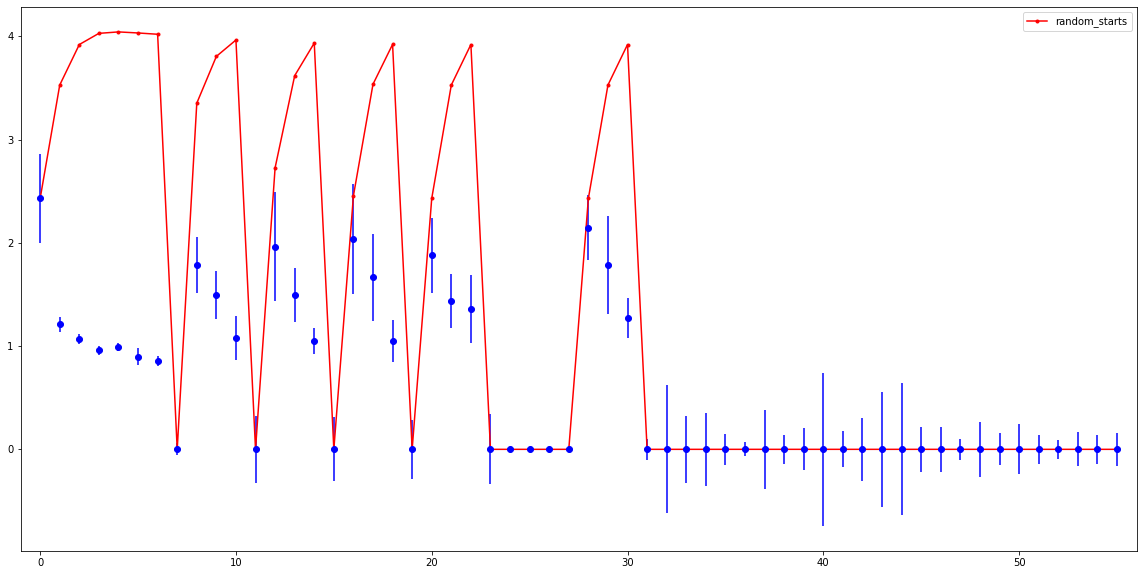



1  ['unknown L2/3; unknown L2/3'] , n=16

initial Q:  6107.0433513227545
shgo : elapsed time 9.5367431640625e-07s 
differential_evolution: elapsed time 71.35319900512695s 
dual_annealing: elapsed time 0.009260892868041992s 
basinhopping: elapsed time 9.5367431640625e-07s 
self adaptive differential evolution: time 9.5367431640625e-07 ; Q  6107.0433513227545
random_start: elapsed time 7.3871519565582275s 
shgo Q = 6107.0433513227545 y
differential_evolution Q = 42.54771590278433 m
dual_annealing Q = 672206.5243323548 c
basinhopping Q = 6107.0433513227545 y
self ajusting differential evolution Q = 6107.0433513227545 r
random_starts Q = 47.57333801781694 g


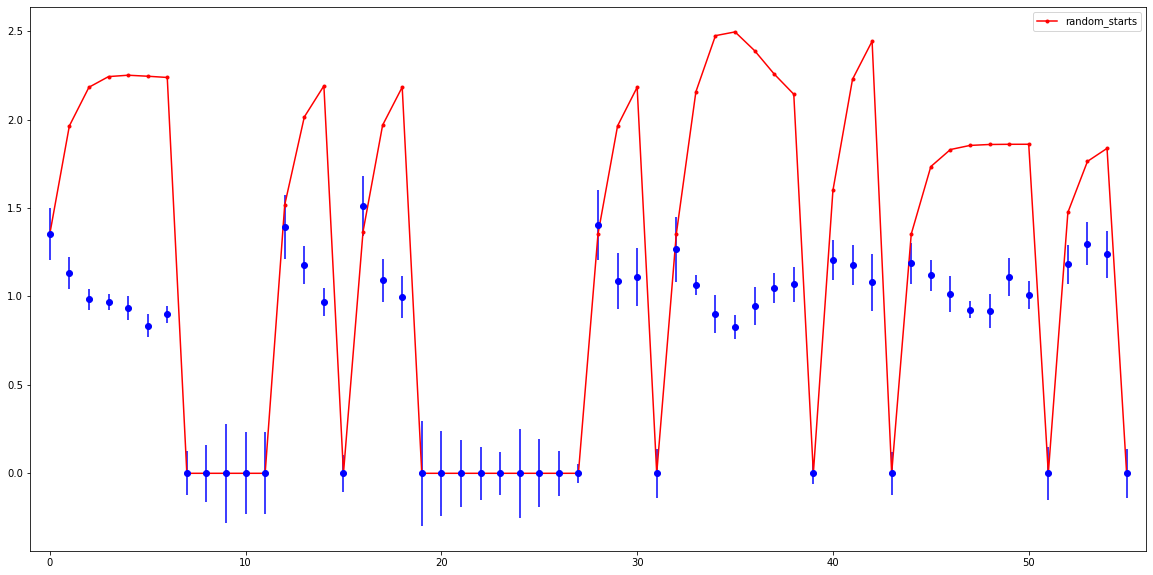

time : 109.14822196960449


ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

In [195]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import scipy.optimize as opt
#from pygmo import 
import pygmo as pg
#from pylab import *


t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping', 'sade', 'random_starts' ]
colors = ['g',   'r',                           'c',          'y',        'm', 'b' ]
nalg = len(algs)

npar=56
#vv = np.arange(8)    # A 1:8 20Hz
vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
#vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5','ibs':0  }

#par['model_type'] = 'tm5_fdr2'  # extended TM model

for i in  range(0,2) : #range(0,len(df9.index)): #range(22,23): #range(len(df9.index)):
    idx = df9.index[i]
    print('\n\n'+str(i)+'  '+df9.loc[idx,'comments']+'\n')
    Ts  = df9.loc[idx,'comments1']
    #ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
    #is_fited_pulses = (abs(ampsa[0])>1e-14)
    
    is_fited_pulses = True
    if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
    #try:
        #par['fited_pulses']=True
        Q2, tt, x, algs, colors, AA = fit_TM_cell(idx,df9,par)
        nalg = len(tt)
    #except:
    else:
        print(Ts)
        Q2 = (10*np.zeros(nalg)).tolist()
        tt = (0*np.zeros(nalg)).tolist()
        x = (0*np.zeros(nalg)).tolist()
        
    Q3 = Q3 + [Q2]
    TT = TT + [tt]
    X = X + [x]
    

    
Q3 = pd.DataFrame(Q3)  
TT = pd.DataFrame(TT) 
t10 = time.time()
print('time : '+ str(t10-t00))


# Save results

Q3.columns = algs
algs2=algs
for ialg, alg in enumerate(algs2): 
    algs2[ialg] = alg + ' , time'
TT.columns = algs2
QT = pd.concat([Q3,TT],axis=1)

X3 = pd.DataFrame(X)
#X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']
X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x']


QTX_extended = pd.concat([df9,QT,X3],axis=1)

QTX_extended.to_hdf('fit_aba_2019_A1_8_fited_pulses_TM_8_syntypes_results','data')

### Tsodyks Markram model 5 parameters + 3 parameters to fit changing depression recovery rate

In [ ]:
TT

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import scipy.optimize as opt
from pygmo import 
# from pylab import *


t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
#vv = np.arange(8)    # A 1:8 20Hz
vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
#vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5' , 'ibs':0 }

par['model_type'] = 'tm5_fdr2'  # extended TM model

for i in  range(0,len(df9.index)): #range(22,23): #range(len(df9.index)):
    idx = df9.index[i]
    print('\n\n'+str(i)+'  '+df9.loc[idx,'comments']+'\n')
    Ts  = df9.loc[idx,'comments1']
    #ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
    #is_fited_pulses = (abs(ampsa[0])>1e-14)
    
    is_fited_pulses = True
    if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
    #try:
        #par['fited_pulses']=True
        Q2, tt, x, algs, colors = fit_TM_cell(idx,df9,par)
        nalg = len(tt)
    #except:
    else:
        print(Ts)
        Q2 = (10*np.zeros(nalg)).tolist()
        tt = (0*np.zeros(nalg)).tolist()
        x = (0*np.zeros(nalg)).tolist()
        
    Q3 = Q3 + [Q2]
    TT = TT + [tt]
    X = X + [x]
    

    
Q3 = pd.DataFrame(Q3)  
TT = pd.DataFrame(TT) 
t10 = time.time()
print('time : '+ str(t10-t00))


# Save results

Q3.columns = algs
algs2=algs
for ialg, alg in enumerate(algs2): 
    algs2[ialg] = alg + ' , time'
TT.columns = algs2
QT = pd.concat([Q3,TT],axis=1)

X3 = pd.DataFrame(X)
#X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']
X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x']


QTX_extended = pd.concat([df9,QT,X3],axis=1)

QTX_extended.to_hdf('fit_aba_2019_A1_8_fited_pulses_TM_8_syntypes_results','data')

# START HERE! But Only: Do Fast fit functions with numba, then fit all!

In [196]:
from numba import jit, float64, int64

dummy_x = np.full((2000,), 1.)
import time

@jit(float64[:,:](float64[:,:],float64[:],float64[:,:],int64),nopython=True)
def  STP_sim2(x, T, init_state, model_type=1 ):
    N       = len(T)
    
    tF      = x[0,:]
    p00     = x[1,:]
    tD      = x[2,:]
    dp      = x[3,:]
    A       = x[4,:]
    
    N1      = len(tF)

    #breakpoint()
    mod_fdr2=False
    if model_type==2:  #tm5_fdr2 should be :check freq. dependent recovery
        tDmin     = x[5,:]
        dd        = x[6,:]
        t_FDR     = x[7,:]
        mod_fdr2=True
        tDmax  = tD
        itDmin = 1/tDmin
        itDmax = 1/tDmax
        #breakpoint()

    mod_smr=False
    if model_type==3:  #tm5+smr should be :check freq. dependent recovery
        t_SMR   = x[8,:]
        dp0     = x[9,:]
        mod_smr=True

    As = np.zeros((N,N1))
    #state = np.zeros((N1,4))

    n = np.full((N1,),1.0)
    p0=p00  #np.full((1,N1),p00) #p00
    p = p0 #p0
    d = np.full((N1,),0.0) #0
    if len(init_state)>0:
        n = init_state[0,:]
        p = init_state[1,:]
        d = init_state[2,:]
        p0= init_state[3,:]
    
    #was_smr=False
    for i in range(0,N):
        if i==0:
            Dt = T[i]
        else:
            Dt = T[i]-T[i-1]

        if mod_fdr2:
            d0=d
            d = d*np.exp(-Dt/t_FDR) 
            n = 1 - (1 - n )*np.exp(-Dt*itDmax -(itDmin -itDmax)*t_FDR*(d0-d))
        else:
            n = 1 - (1 - n )*np.exp(-Dt/tD )

        if mod_smr:
            #was_smr=True
            p01=p0
            p0=p00 + (p0 -p00)*np.exp(-Dt/t_SMR)
            p=p0 +(p -p01)*np.exp(-Dt/tF)
        else:
            p=p0 +(p -p0)*np.exp(-Dt/tF)

        As[i,:]=A*n*p

        n = n*(1-p)
        p = p + dp*(1-p)
        if mod_fdr2:
            d  = d + dd*(1-d) 
        if mod_smr:
            p0  = p0 - dp0*p0  
            
    state = np.concatenate((n,p,d,p0),axis=0).reshape((-1,4)).transpose() #[n,p,d,p0]
    state = np.concatenate((As,state),axis=0)
    #if was_smr:
    #    state = state
    return state


class jit_rosenbrock2:
    def fitness(self,x):
        amps = self.amps
        sig = self.sig
        Ts=self.Ts
        model_type = self.model_type
        N1 = int(x.size/self.dim)
        x = x.reshape((self.dim,N1))
        x1 = np.copy(np.exp(x))
        f = jit_rosenbrock2.QA_TM_aba_synphys(x1,amps,sig,Ts,model_type=model_type) 
        return f.reshape((-1,))
    
    def batch_fitness(self,dvs):
        amps = self.amps
        sig = self.sig
        Ts=self.Ts
        model_type = self.model_type
        x = dvs.reshape((self.dim,-1))
        x1 = np.copy(np.exp(x))
        dvf =  jit_rosenbrock2.QA_TM_aba_synphys(x,amps,sig,Ts,model_type=model_type) 
        
        return dvf.reshape((-1,))
    
    def has_batch_fitness(self):
        return True

    @jit(float64[:,:](float64[:,:],float64[:,:],float64[:,:],float64[:],int64),nopython=True)
    def QA_TM_aba_synphys(x,amps,sig,Ts,model_type=1): #QA_TM_aba_synphys
        fl=0
        if fl==0:
            #x = np.copy(x00).reshape((-1,1))
            
            ams = x[4:7,:]
            #breakpoint()
            if len(x)>7:
                if model_type==2: #'tm5_fdr2':
                    #x2=np.copy(np.delete(x,[5,6],axis=0))
                    x2=np.copy(np.concatenate((x[:5,:],x[7:,:]),axis=0))
                if model_type==3: #'tm5_smr':
                    #x2=np.copy(np.delete(x,[5,6],axis=0))
                    x2=np.copy(np.concatenate((x[:5,:],x[7:,:]),axis=0))

                #x2[5:] = x[7:]
            else:
                x2=np.copy(x[0:5,:])

        n  = [0, 32, 44]
        t2 = [6, 1,  1]
        #T2  =[125, 250, 500, 1000, 2000, 4000]
        eps = 1e-16 #np.finfo(float).eps
        
        N1=x.shape[1]
        N2=amps.shape[1]
        
        z4 = np.arange(4)
        z8 = np.arange(8)
        z0 = np.zeros((0,1))
        
        #A = np.zeros((amps.shape[0],1))
        Q=np.zeros((N2,N1))
        for ii in range(3):
            vv = z8 + n[ii]
            A1e = amps[vv,:]  
            S1e = sig[vv,:]
            if fl==0:
                x2[4,:] = ams[ii,:] # independent amplitudes for each stimulation frequency - to account for rundown etc.

            #vv_nonz = np.nonzero(np.abs(A1e[:])>eps*1e3)[0]
            vv_z = np.abs(A1e[:,0])<eps*1e3
            #print(vv_nonz)
            #if len(vv_nonz)>0:
            if np.sum(vv_z)!=len(A1e):
                # preconditioning:
                states = STP_sim2(x2, Ts[vv],z0,model_type=model_type ) 
                A1=states[:-4,:]
                np0 = states[-4:,:]
                #np0 = np0[1:]

                # first 8 stimuli responces:
                #A1, states = STP_sim2(x2, Ts[vv]+DT0, init_state=np0, model_type=model_type ) 
                A1[vv_z,:] = 0
                #A[vv,:] = A1

                #Q = Q + np.sum((A1e[vv_nonz]-A1[vv_nonz])**2/(S1e[vv_nonz]**2 + eps))
                Q[:] +=  np.sum((A1e-A1)**2/(S1e**2 + eps))
                # recovery responces
                #np0 = [n12[-1], p12[-1], d12[-1]]
                #np0 = states[-1]
                for i3 in range(t2[ii]):
                    vv2 = vv[-1]+1+z4+4*i3
                    A2e = amps[vv2,:] 
                    S2e = sig[vv2,:] 

                    vv_z2 = np.abs(A2e[:,0])<eps*1e3
                    #if len(vv_nonz2)>0:
                    if np.sum(vv_z2)!=len(A2e):
                        states2 = STP_sim2(x2, Ts[vv2], init_state=np0, model_type=model_type )
                        A2=states2[:-4,:]
                        A2[vv_z2,:] = 0

                        #A[vv2,:] = A2

                        #Q = Q + np.sum((A2e[vv_nonz2]-A2[vv_nonz2])**2/(S2e[vv_nonz2]**2 + eps))
                        Q[:] += np.sum((A2e-A2)**2/(S2e**2 + eps))

        return Q #, A #, A3

    #def get_nec(self):
    #    return 1

    #def get_nic(self):
    #    return 1

    def get_bounds(self):
        #return (np.full((self.dim,),-5.),np.full((self.dim,),10.))
        xl=np.full((self.dim,),0.)
        xu=np.full((self.dim,),1.)
        xl[:]=self.xlower
        xu[:]=self.xupper
        return (xl,xu)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def __init__(self,amps,sig,Ts,model_type,xlower,xupper):
        if model_type=='tm5':
            self.dim = 7
            self.model_type = 1 

        elif model_type=='tm4':
            self.dim = 7
            self.model_type = 1 

        elif model_type=='tm5_fdr2':
            self.dim = 10
            self.model_type = 2 

        elif model_type=='tm5_smr':
            self.dim = 12 #12 #len(xlower) #xlower.shape[0]
            self.model_type = 3 # model_type #'tm5'
        
        
        self.amps = amps 
        self.Ts = Ts
        self.sig = sig
        self.DT0 = float(0)
        
        self.xlower = np.log(xlower)
        self.xupper = np.log(xupper)

In [197]:
#np.std(ampsa1, axis=0 )
df9

name  \
pvalb L4; nr5a1 L5          [aba_2019_synphys_pair_97450; pvalb L4; nr5a1 L5]   
unknown L2/3; unknown L2/3  [aba_2019_synphys_pair_78203; unknown L2/3; un...   
sst L2/3; sst L2/3          [aba_2019_synphys_pair_72416; sst L2/3; sst L2/3]   
unknown L2/3; pvalb L2/3    [aba_2019_synphys_pair_90113; unknown L2/3; pv...   
sst L5; sst L5                  [aba_2019_synphys_pair_22739; sst L5; sst L5]   
sim1 L5; pvalb L5            [aba_2019_synphys_pair_90379; sim1 L5; pvalb L5]   
tlx3 L5; fam84b L5          [aba_2019_synphys_pair_84116; tlx3 L5; fam84b L5]   
nr5a1 L2/3; nr5a1 L2/3      [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...   
sst L2/3; sim1 L5            [aba_2019_synphys_pair_80915; sst L2/3; sim1 L5]   
vip L2/3; sst L2/3          [aba_2019_synphys_pair_74057; vip L2/3; sst L2/3]   
pvalb L2/3; sst L2/3        [aba_2019_synphys_pair_92045; pvalb L2/3; sst ...   
sim1 L5; sim1 L5              [aba_2019_synphys_pair_62585; sim1 L5; sim1 L5]   
pvalb L4; nr5a1 L4          [aba_2019_synphys_pair_74339; pvalb L4; nr5a1 L4]   
pvalb L4; pvalb L2/3        [aba_2019_synphys_pair_78262; pvalb L4; pvalb ...   
sst L4; vip L4                  [aba_2019_synphys_pair_85538; sst L4; vip L4]   
vip L2/3; vip L4              [aba_2019_synphys_pair_85664; vip L2/3; vip L4]   
pvalb,sst L5; pvalb L5      [aba_2019_synphys_pair_28099; pvalb,sst L5; pv...   
sst L2/3; vip L2/3          [aba_2019_synphys_pair_67401; sst L2/3; vip L2/3]   
rbp4 L4; rbp4 L4              [aba_2019_synphys_pair_34697; rbp4 L4; rbp4 L4]   
pvalb L6; ntsr1 L6          [aba_2019_synphys_pair_57987; pvalb L6; ntsr1 L6]   
pvalb L2/3; vip L2/3        [aba_2019_synphys_pair_42202; pvalb L2/3; vip ...   
rorb L4; rorb L4              [aba_2019_synphys_pair_55151; rorb L4; rorb L4]   
tlx3 L5; sst L5                [aba_2019_synphys_pair_42553; tlx3 L5; sst L5]   
sst L4; nr5a1 L4              [aba_2019_synphys_pair_73279; sst L4; nr5a1 L4]   
vip L4; sst L5                  [aba_2019_synphys_pair_85546; vip L4; sst L5]   
ntsr1 L6; ntsr1 L6          [aba_2019_synphys_pair_61000; ntsr1 L6; ntsr1 L6]   
sst L5; tlx3 L5                [aba_2019_synphys_pair_42926; sst L5; tlx3 L5]   
pvalb L5; tlx3 L5            [aba_2019_synphys_pair_23389; pvalb L5; tlx3 L5]   
ntsr1 L6; pvalb L6          [aba_2019_synphys_pair_70309; ntsr1 L6; pvalb L6]   
sst L6; sst L6                  [aba_2019_synphys_pair_92558; sst L6; sst L6]   
sst L6; pvalb L5              [aba_2019_synphys_pair_58169; sst L6; pvalb L5]   
tlx3 L5; pvalb L2/3         [aba_2019_synphys_pair_69203; tlx3 L5; pvalb L...   
pvalb L2/3; pvalb L2/3      [aba_2019_synphys_pair_72007; pvalb L2/3; pval...   
pvalb L5; pvalb L5          [aba_2019_synphys_pair_17377; pvalb L5; pvalb L5]   
pvalb L5; sim1 L5            [aba_2019_synphys_pair_26232; pvalb L5; sim1 L5]   
nr5a1 L4; pvalb L4          [aba_2019_synphys_pair_74371; nr5a1 L4; pvalb L4]   
pvalb L6; pvalb L6          [aba_2019_synphys_pair_57717; pvalb L6; pvalb L6]   
nr5a1 L4; vip L4              [aba_2019_synphys_pair_97762; nr5a1 L4; vip L4]   
unknown L2/3; vip L2/3      [aba_2019_synphys_pair_69453; unknown L2/3; vi...   
ntsr1 L6; sst L6              [aba_2019_synphys_pair_56609; ntsr1 L6; sst L6]   
sim1 L5; sst L5                [aba_2019_synphys_pair_92003; sim1 L5; sst L5]   
nr5a1 L4; sst L4              [aba_2019_synphys_pair_89701; nr5a1 L4; sst L4]   
tlx3 L5; tlx3 L5              [aba_2019_synphys_pair_25382; tlx3 L5; tlx3 L5]   

                                    area              synapse_type_2  \
pvalb L4; nr5a1 L5              [L4; L5]          pvalb L4; nr5a1 L5   
unknown L2/3; unknown L2/3  [L2/3; L2/3]  unknown L2/3; unknown L2/3   
sst L2/3; sst L2/3          [L2/3; L2/3]          sst L2/3; sst L2/3   
unknown L2/3; pvalb L2/3    [L2/3; L2/3]    unknown L2/3; pvalb L2/3   
sst L5; sst L5                  [L5; L5]              sst L5; sst L5   
sim1 L5; pvalb L5               [L5; L5]           sim1 L5; pvalb L5   
tlx3

# THIS IS MAIN FIT FOR TM5_smr



0  ['pvalb L5; nr5a1 L4', 'pvalb L; nr5a1 L4', 'pvalb L4; nr5a1 L5'] , n=8

0.09085702896118164
n_local_opt=lbfgs: time 10.68616795539856 ; Q  9.154723044977484
differential evolution: time 9.5367431640625e-07 ; Q  100000.0
self adaptive differential evolution: time 20.704978942871094 ; Q 11.498577511347307,  best x : [1.87962837e+04 4.16208224e-01 1.58484897e+02 2.03399461e-02
 4.37775306e+00 1.24513867e+01 2.01631686e+01 1.25691523e-01
 1.46849990e-01 2.82392769e-01 3.73282477e+02 1.68800433e-03]


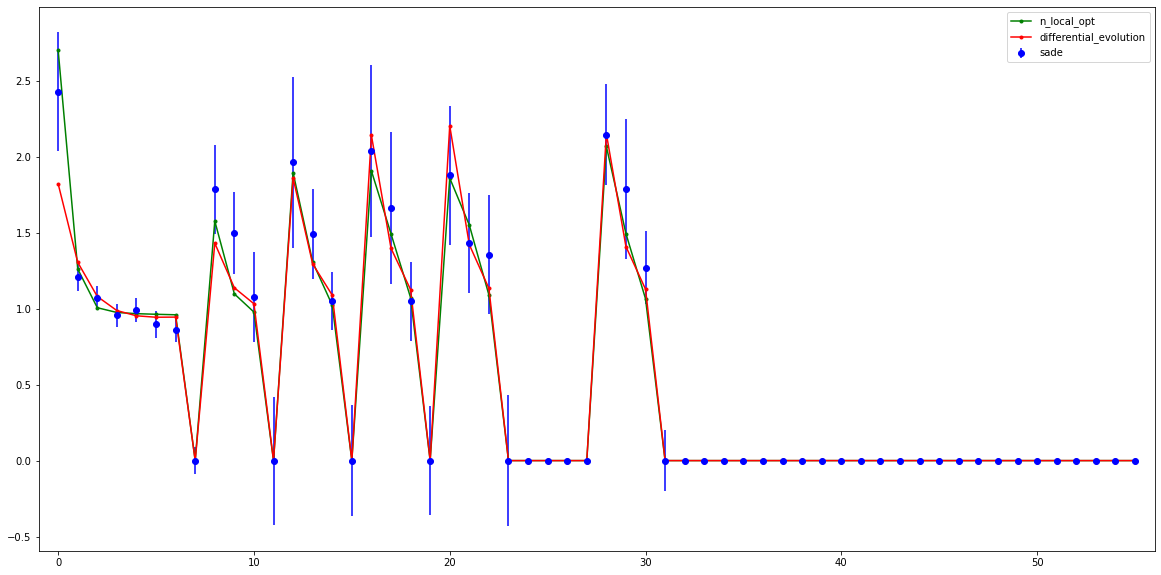

0.14498400688171387
n_local_opt=lbfgs: time 9.760565042495728 ; Q  24.45208333485872
differential evolution: time 3.0994415283203125e-06 ; Q  100000.0
self adaptive differential evolution: time 4.01528000831604 ; Q 27.16946499554891,  best x : [1.30787191e+00 6.29441750e-01 1.15681251e+02 7.55512143e-02
 4.10438500e+00 8.95183523e+01 3.96307500e+00 7.44842363e+02
 4.63925696e-03 3.97175641e+01 1.98473469e+02 1.31865694e-01]


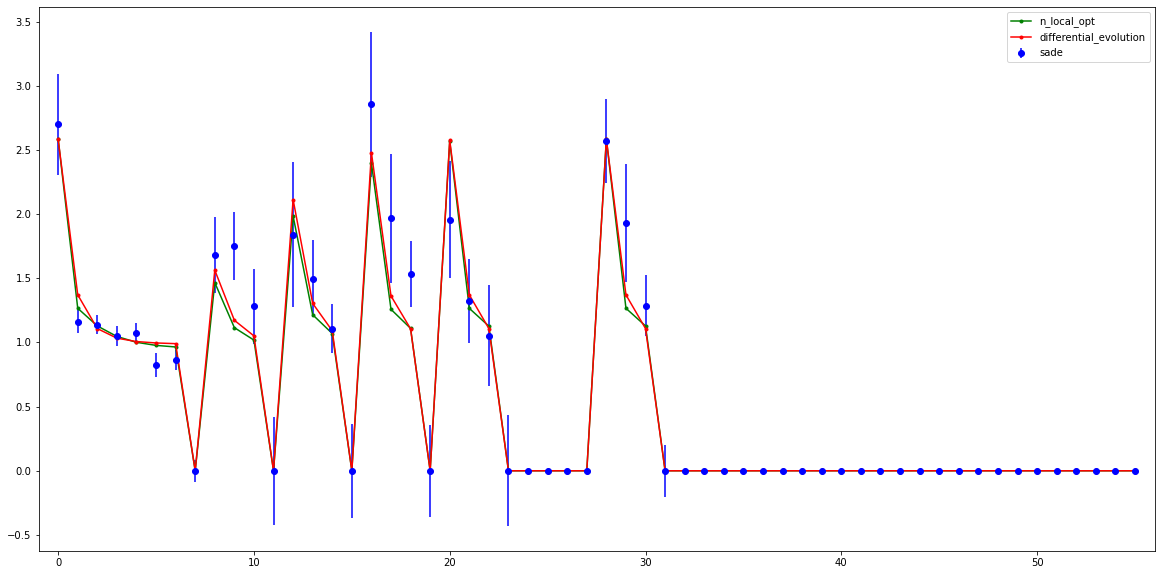

0.0702662467956543
n_local_opt=lbfgs: time 11.546120882034302 ; Q  18.88460646362205
differential evolution: time 9.5367431640625e-07 ; Q  100000.0
self adaptive differential evolution: time 4.6266770362854 ; Q 21.452998203567542,  best x : [1.84071425e+04 3.41368712e-01 1.66025233e+02 1.98885485e-02
 4.93354096e+00 1.94456869e+02 8.18774421e+01 1.34096861e+02
 1.00518339e-02 1.44807805e+04 2.32262428e+02 2.41265101e-03]


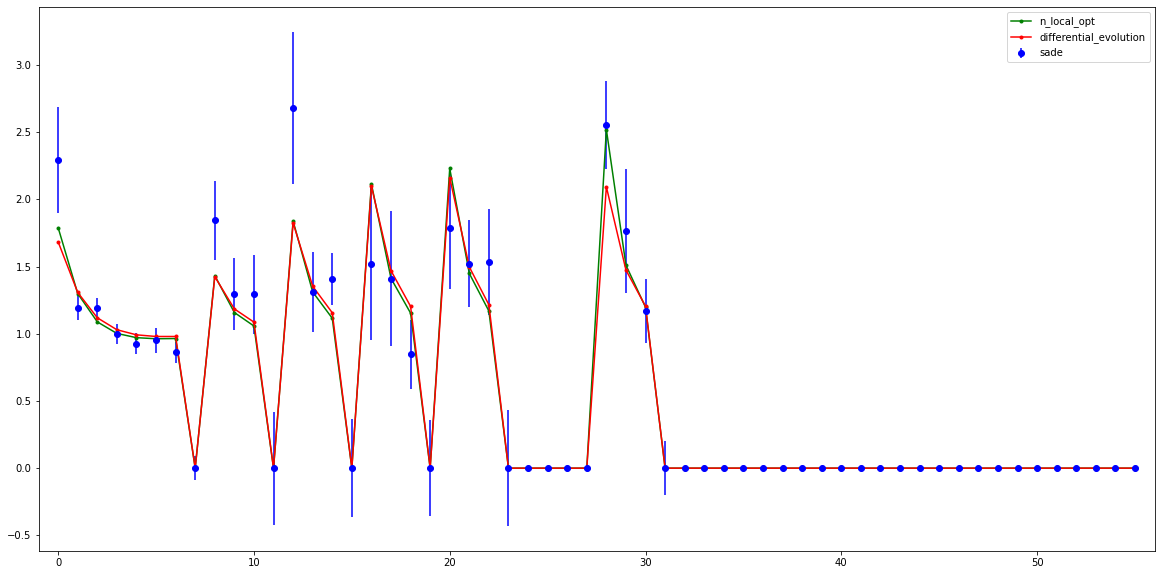

0.10247087478637695
n_local_opt=lbfgs: time 9.15838885307312 ; Q  6.986755998029092
differential evolution: time 9.5367431640625e-07 ; Q  100000.0
self adaptive differential evolution: time 3.7814431190490723 ; Q 8.619216526568742,  best x : [2.90550637e+02 8.16752133e-01 1.28339121e+02 6.70427890e-01
 3.04692072e+00 1.30114376e+02 4.87749191e+01 3.35436411e+01
 2.38530606e-01 5.49329523e+01 1.86391106e+04 2.70140022e-02]


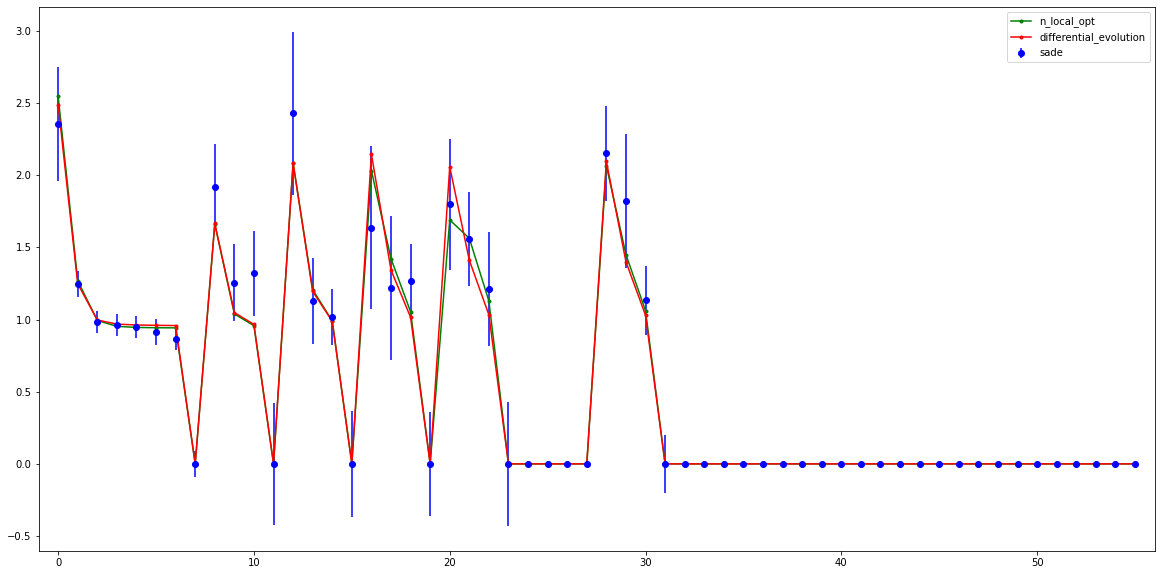

0.0727381706237793
n_local_opt=lbfgs: time 9.032409906387329 ; Q  8.076871091283925
differential evolution: time 1.9073486328125e-06 ; Q  100000.0
self adaptive differential evolution: time 4.349418878555298 ; Q 9.890678268244265,  best x : [3.63825034e+00 4.07539943e-01 1.13974503e+02 4.09314201e-01
 3.84292493e+00 1.72190793e+02 3.63147768e+01 3.42544715e+01
 4.28620225e-03 8.41364665e+02 1.79050955e+00 1.21180470e-03]


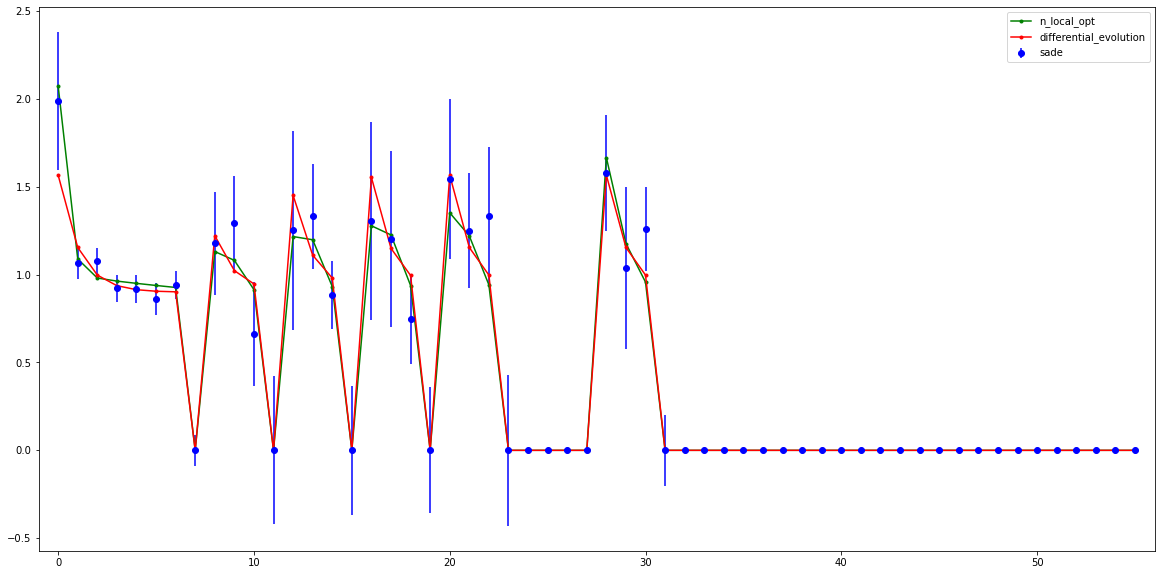

In [198]:
########################## 1
t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
vv = np.arange(7)    # A 1:8 20Hz


vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
##vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5','ibs':0 }

par['model_type'] = 'tm5_smr'  # extended TM model
#par['model_type'] = 'tm5_smr'

#par['model_type'] = 'tm4'


########################## 2
i0=0
idx = df9.index[i0]
print('\n\n'+str(i0)+'  '+df9.loc[idx,'comments']+'\n')
Ts  = df9.loc[idx,'comments1']
#ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
#is_fited_pulses = (abs(ampsa[0])>1e-14)

is_fited_pulses = True
if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):

#try:
    #par['fited_pulses']=True
    Q2 =[]
    tt =[]
    x = []
    ampsa = df9.loc[idx,'stp_mean_fit_bootstrap']
    nbs = int(ampsa.shape[0]/npar)
    nbs=5
    for ibs in range(nbs): #range(nbs):
        
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
        
        par['ibs']=ibs
        #Q4, tt4, x4, algs, colors = fit_TM_cell(idx,df9,par)
        i=idx 




        ########################## 3
        #breakpoint()
        aba_case=False
        if 'aba_case' in par:
            aba_case = par['aba_case']

        model_type='tm5'
        if 'model_type' in par:
            model_type = par['model_type']    

        if par['fited_pulses']==True:
            ampsa = df9.loc[i,'stp_mean_fit_bootstrap']
            siga = df9.loc[i,'stp_sigma_fit_bootstrap']  
            #if abs(ampsa[0])<1e-14:
                #ampsa = df.loc[i,'stp_mean_bootstrap']
                #siga = df.loc[i,'stp_sigma_bootstrap']
        else:
            ampsa = df9.loc[i,'stp_mean_bootstrap']
            siga = df9.loc[i,'stp_sigma_bootstrap']

        Ts = df9.loc[i,'comments1']
        Ts = np.array(Ts[0][:].strip().split()).astype(float)

        #breakpoint()

        #A3 = df.loc[i,'comments']
        #A3i = np.array(A3[0][:].strip().split()).astype(float)
        #A4 = np.ones((len(A3),len(A3i)))
        #for ia3 in range(len(A3)):
        #    A3i = np.array(A3[ia3][:].strip().split()).astype(float)
        #    A4[ia3,:] = A3i
        ##A4.shape 


        ibs  = par['ibs']
        npar = 56
        #amps = ampsa[ibs*npar + np.arange(npar)]
        ampsa1 = ampsa.reshape((-1,npar))
        amps = ampsa1[ibs,:].ravel()

        do_this=1
        if do_this==0:
            #sig  = siga #[(ibs-1)*npar + np.arange(npar)]
            ##A3e  = A4[:,ibs ].ravel()
            siga1 = siga.reshape((-1,npar))
            sig = siga1[ibs,:].ravel()
            
        else:
            #sig = np.std(ampsa1,axis=0).ravel() # reestimate sigma
            sig=pd.DataFrame(ampsa1).std(axis=0).values
        
        DT0 = 25000

        # restrict set of fited data
        vv = par['amplitudes_selected_for_TM_training']
        #vv = np.arange(8)    # A 1:8
        #vv = np.arange(npar) # all
        #vv = np.concatenate([vv,vv+32, vv+44]) # without recovery

        amps0 = amps
        amps = np.zeros(amps.shape)
        amps[vv] = amps0[vv]

             #  tF   p0     tD  dp         A            A1           A2      tDmin  dd   t_FDR t_SMR dp0 
        x0 = [ 100,  0.1,  100, 0.1, amps[0]/0.1, amps[0]/0.1,  amps[0]/0.1, 10,   0.05, 100,  100,  0.02 ]

        x0 = np.array(x0)

        #dxx = np.array([1e3, 20, 1e3, 1e2,  20, 20, 20,  1e1, 20, 1e2 ])
        dxx = np.array([1e3,  10, 1e3, 10,  20, 20, 20,  1e3, 20, 1e3, 1e3, 50 ])

        #breakpoint()
        if model_type=='tm5':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm4':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm5_fdr2':
            x0 = x0[0:10]
            dxx = dxx[0:10]

        if model_type=='tm5_smr':
            x0 = x0    
            dxx = dxx
        #print(x0)
        #Q0, A0 = QA_TM_aba_synphys(x0, amps, sig, Ts,DT0,model_type)
        ##print(x0)
        #print('initial Q: ',str(Q0))

        #           tF      p0    tD        dp           A                A1                  A2              tDmin   dd   tD2
        #xlower = [  0.1,   0.01,   0.1,     0.0001,     amps[0]/1*1e-1,   amps[0]/1*1e-1,     amps[0]/1*1e-1,  1,     1e-3, 1]
        xlower = x0/dxx
        xlower = np.array(xlower).reshape((-1,))
        #xupper = [  1e5,   1,      1e5,     1,          amps[0]/0.01*1e1, amps[0]/0.01*1e1,   amps[0]/0.01*1e1, 100,  1,    1e4]
        #xupper = np.array(xupper)
        xupper = x0*dxx
        xupper = np.array(xupper).reshape((-1,))
        bounds = [] #np.zeros(len(xlower))
        for ibo in range(len(xlower)):
            bounds = bounds + [(xlower[ibo],xupper[ibo])]
        tt=[]

        x0 = np.array(x0).reshape((-1,))
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        pop = pg.population(prob=prob, size = 10)
        
        t1 = time.time()
        for iii in range(1000):
            prob.fitness(x0) 
        t2 = time.time()
        print(t2 - t1) 
        
        
        uda1 = pg.nlopt('lbfgs') #'lbfgs') #'tnewton_precond_restart') #'bobyqa')   #"cobyla")
        uda1.xtol_rel = 1e-12
        algo = pg.algorithm(uda1)        
        t1 = time.time()
        #pop2 = algo.evolve(pop)
        for irep in range(19):
            pop = pg.population(prob=prob, size = 10)
            pop2 = algo.evolve(pop)
            x = pop2.champion_x
            x=np.exp(x)
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            if irep==0:
                x_best = x
                Q_best = Q
            if  Q_best>Q:
                x_best = x
                Q_best = Q
            
        t2 = time.time()
        #x = pop2.champion_x
        #x = np.exp(x)
        x = x_best
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='g')
        #print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])
        print('n_local_opt=lbfgs: time ' + str(t2 - t1), '; Q ',str(Q))
        
  
        do_this=0
        t1 = time.time()
        if do_this==1:
            uda = pg.de(gen = 100, F = 0.8, CR = 0.9, variant = 2, ftol = 1e-6, xtol = 1e-6)
            algo = pg.algorithm(uda)
            #t1 = time.time()
            pop2 = algo.evolve(pop)
            #t2 = time.time()
            x = pop2.champion_x
            x=np.exp(x)
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            plt.plot(np.arange(len(amps)), A, '.-',color='c')
        else:
            Q = 1e5
        t2 = time.time()
        print('differential evolution: time ' + str(t2 - t1), '; Q ',str(Q)) 
        
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        #pop = pg.population(prob=prob, size = 1000)
        uda = pg.de1220(gen = 100, allowed_variants = [2,3,7,10,13,14,15,16], variant_adptv = 1, ftol = 1e-6, xtol = 1e-6, memory = False)
        algo = pg.algorithm(uda)
        archi = pg.archipelago(n=32,algo=algo, prob=prob, pop_size=32)
        t1 = time.time()
        #pop2 = algo.evolve(pop)
        archi.evolve() 
        archi.wait()
        t2 = time.time()
        qq=np.array(archi.get_champions_f())
        xx=np.array(archi.get_champions_x())
        
        x = xx[qq.argmin(),:]
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='r')
        print('self adaptive differential evolution: time ' + str(t2 - t1), '; Q '+str(Q)+',  best x : '+str(x)) 
        
        
        do_this=0
        if do_this==1:
            uda = pg.nsga2(gen = 100, cr = 0.95, eta_c = 10., m = 0.01, eta_m = 50.) 
            algo = pg.algorithm(uda)
            t1 = time.time()
            pop2 = algo.evolve(pop)
            t2 = time.time()
            #x = pop2.champion_x
            #x=np.exp(x)
            x = x_best
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            plt.plot(np.arange(len(amps)), A, '.-',color='m')
            print('Non dominated Sorting Genetic Algorithm (NSGA-II): time ' + str(t2 - t1), '; Q ',str(Q)) 
        
        #algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
        #colors = ['y',   'r',                           'c',          'y',         'g' ]
        A3e=1
        plt.errorbar(np.arange(len(amps)), amps*A3e, yerr=sig*A3e, fmt =  'bo')
        

        #algs_short = ['differential_evolution',  'random_starts' ]
        #algs_short = ['n_local_opt' ,'differential_evolution','sade','nsga2','data']
        algs_short = ['n_local_opt' ,'differential_evolution','sade','data']
        #plt.legend(algs)
        plt.legend(algs_short)

        #fig = plt.gcf()
        #set_position(plt.gca, [10, 10, 100, 500], which='both')
        plt.xlim((min(vv)-1,max(vv)+2)) 
        #thismanager = plt.get_current_fig_manager()
        #thismanager.window.SetPosition((500, 0))
        #plt.hold(False)
        plt.pause(0.5) 

In [146]:
print(uda1.maxeval)
print(uda1.maxtime)
print(uda1.stopval)
print(uda1.xtol_rel)
print(uda1.xtol_abs)
print(uda1.ftol_rel)
print(uda1.ftol_abs)
print(uda1.selection)

0
0
-inf
1e-12
0.0
0.0
0.0
best


# IT SEEMS THIS IS MAIN FIT for model TM4



0  ['pvalb L5; nr5a1 L4', 'pvalb L; nr5a1 L4', 'pvalb L4; nr5a1 L5'] , n=8

1000 times fitness elapsed time:  0.06458187103271484  seconds
n_local_opt: time 2.8165130615234375 ; Q  11.153614207319954  , Q_best  11.153614207319954
n_local_opt: A  [1.94799067 1.2957235  1.05786976 0.97522305 0.94953966 0.94429267
 0.94616115 0.         1.4645171  1.12218269 1.01578837 0.
 1.89725469 1.2597817  1.05874368 0.         2.15526903 1.34189962
 1.08436881 0.         2.20778135 1.35876225 1.08959081 0.
 0.         0.         0.         0.         2.201789   1.35777863
 1.08900311 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
differential evolution: time 0.07422304153442383 ; Q  11.543000895091579
differential evolution: A  [2.1886688  1.30844892 1.05116737 0.97596597 0.95398518 0.94756037
 0.945

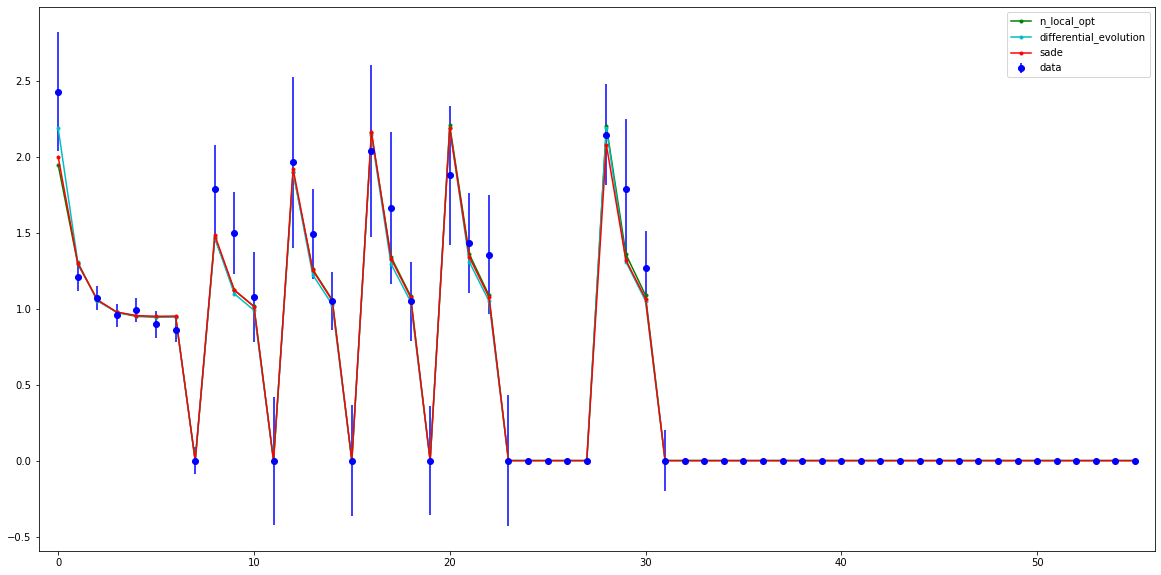

1000 times fitness elapsed time:  0.06328701972961426  seconds
n_local_opt: time 3.1639769077301025 ; Q  27.349704250816547  , Q_best  27.349704250816547
n_local_opt: A  [1.7381697  1.32556673 1.11890256 1.02298724 0.98368894 0.97185252
 0.97256287 0.         1.49880655 1.18348851 1.07006992 0.
 1.98457321 1.3624471  1.1336101  0.         2.33437808 1.49159753
 1.17951735 0.         2.43357387 1.52881509 1.19282974 0.
 0.         0.         0.         0.         2.41891698 1.52717077
 1.19271932 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
differential evolution: time 0.07125210762023926 ; Q  28.464892691402596
differential evolution: A  [2.41361424 1.34147678 1.07893443 1.01464371 0.99890036 0.99504517
 0.99410112 0.         1.60146941 1.14260078 1.03023417 0.
 2.09349616 1.26308706 1.

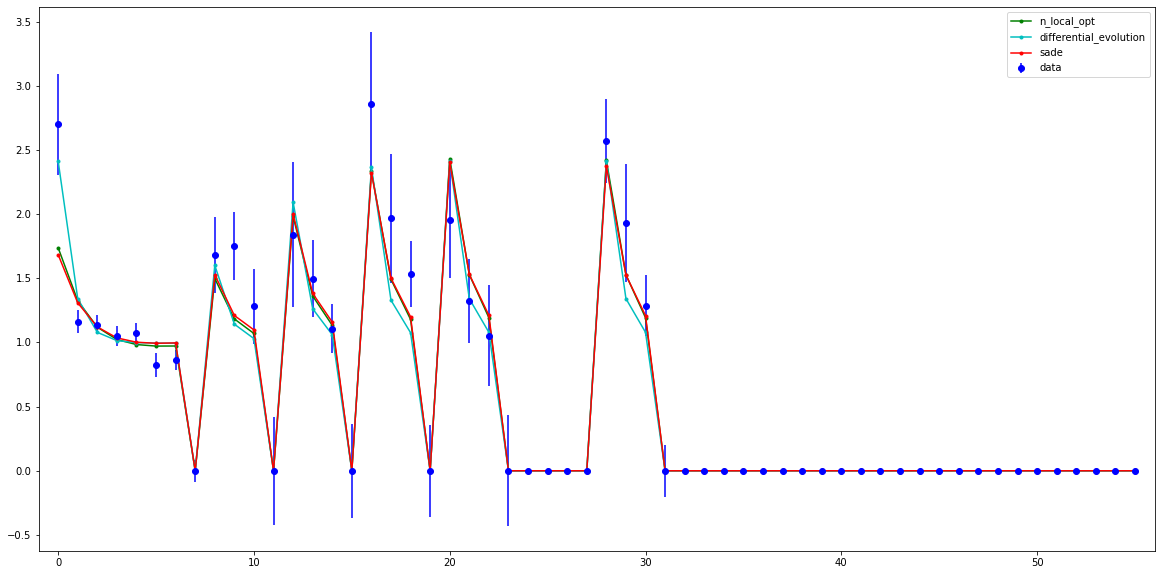

1000 times fitness elapsed time:  0.061354875564575195  seconds
n_local_opt: time 2.6494359970092773 ; Q  19.688727184536518  , Q_best  19.688727184536518
n_local_opt: A  [1.7778505  1.30922707 1.09462151 1.00308368 0.96885276 0.96018522
 0.9623419  0.         1.47930901 1.16428725 1.05478364 0.
 1.93825802 1.32837124 1.11164098 0.         2.24769205 1.43919576
 1.15006314 0.         2.32559662 1.46750004 1.15989048 0.
 0.         0.         0.         0.         2.31315883 1.46556759
 1.15925678 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
differential evolution: time 0.07092571258544922 ; Q  21.424815716609462
differential evolution: A  [1.98888084 1.28230555 1.05873199 0.9914555  0.9738776  0.97178272
 0.97436804 0.         1.51254364 1.13608644 1.03222969 0.
 1.92864709 1.25349435 1

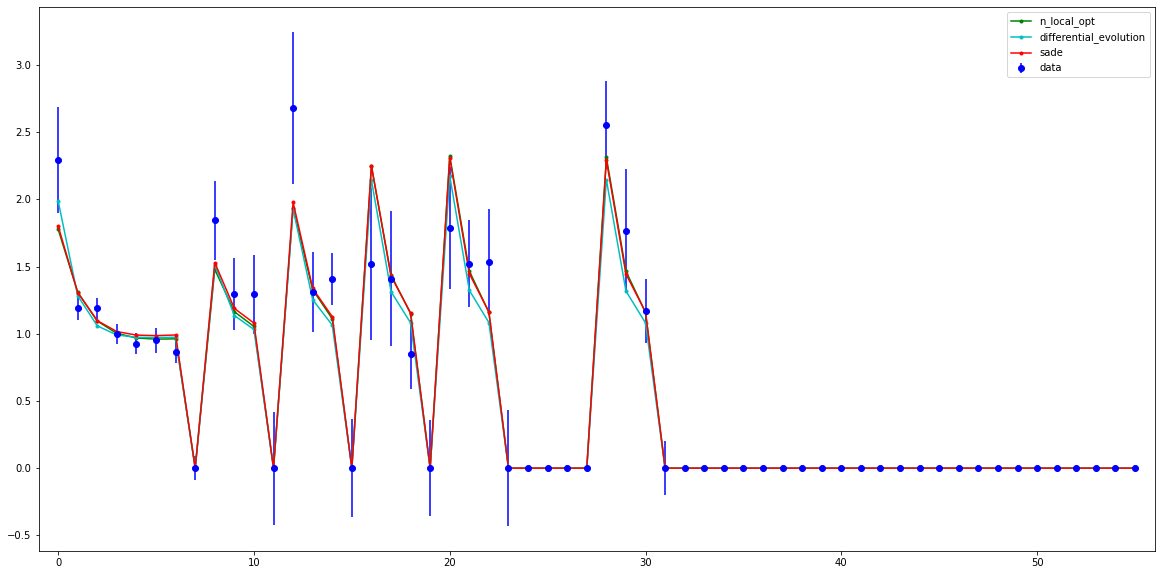

1000 times fitness elapsed time:  0.05975699424743652  seconds
n_local_opt: time 3.3652701377868652 ; Q  10.501659194221002  , Q_best  10.501659194221002
n_local_opt: A  [2.12137948 1.29718616 1.01337635 0.95847141 0.94744316 0.94431532
 0.94319488 0.         1.62467735 1.0330228  0.95651731 0.
 2.04647616 1.15531019 0.97817111 0.         2.16204835 1.25911406
 1.00168031 0.         2.12987509 1.29377385 1.01212881 0.
 0.         0.         0.         0.         2.12137949 1.29718615
 1.01337635 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
differential evolution: time 0.08948922157287598 ; Q  17.29605999663653
differential evolution: A  [1.71276482 1.24743057 1.0293531  0.99006647 0.98359919 0.98242761
 0.98219548 0.         1.46804424 1.09605649 1.00161156 0.
 1.67370119 1.19872148 1.0

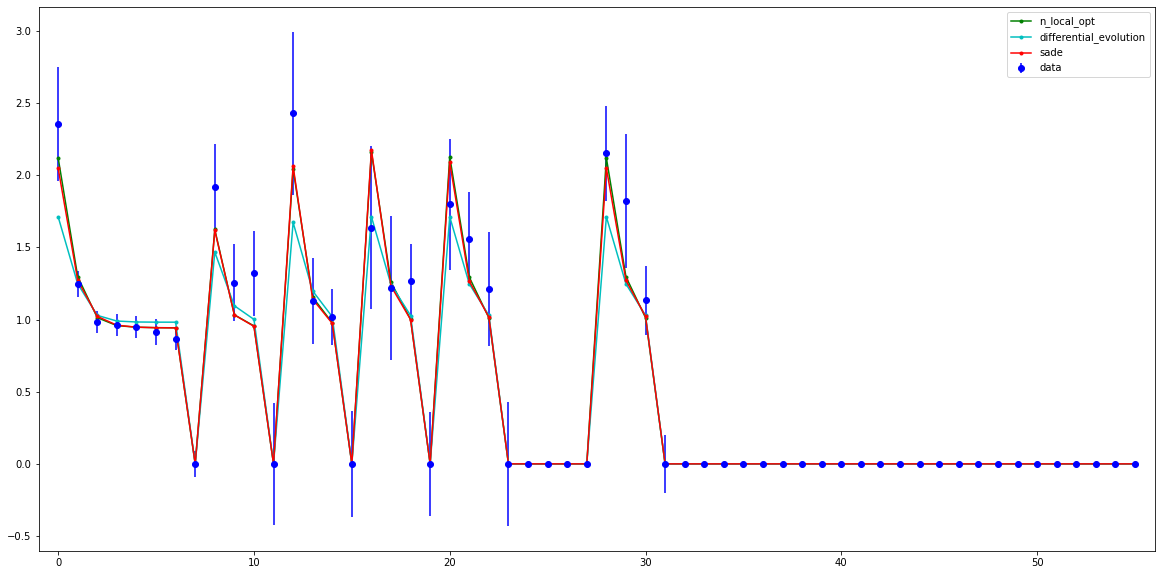

1000 times fitness elapsed time:  0.05960822105407715  seconds
n_local_opt: time 3.019329071044922 ; Q  9.838948746008013  , Q_best  9.838948746008013
n_local_opt: A  [1.56664565 1.15737112 1.00276351 0.94435891 0.92229598 0.91396148
 0.91081304 0.         1.23080687 1.03050461 0.95483839 0.
 1.45702619 1.11596126 0.98712051 0.         1.55496677 1.1529593
 1.0010969  0.         1.56651308 1.15732104 1.00274459 0.
 0.         0.         0.         0.         1.56664565 1.15737112
 1.00276351 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
differential evolution: time 0.06890177726745605 ; Q  10.030649297617881
differential evolution: A  [1.4960161  1.15805856 1.01001645 0.9463523  0.91941426 0.90820885
 0.90365045 0.         1.18493694 1.02052069 0.95078548 0.
 1.38965117 1.10969383 0.9888

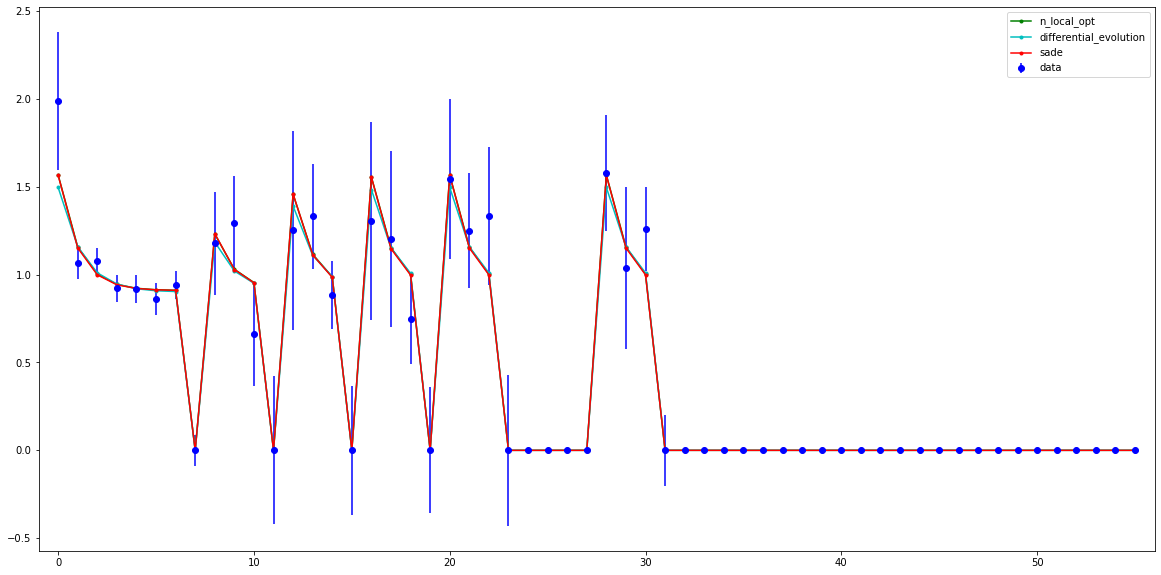

In [201]:
########################## 1
t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
vv = np.arange(7)    # A 1:8 20Hz


vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
##vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5','ibs':0 }

par['model_type'] = 'tm5_smr'  # extended TM model
#par['model_type'] = 'tm5_smr'

par['model_type'] = 'tm4'


########################## 2
i0=0
idx = df9.index[i0]
print('\n\n'+str(i0)+'  '+df9.loc[idx,'comments']+'\n')
Ts  = df9.loc[idx,'comments1']
#ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
#is_fited_pulses = (abs(ampsa[0])>1e-14)

is_fited_pulses = True
if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):

#try:
    #par['fited_pulses']=True
    Q2 =[]
    tt =[]
    x = []
    ampsa = df9.loc[idx,'stp_mean_fit_bootstrap']
    nbs = int(ampsa.shape[0]/npar)
    nbs=5
    for ibs in range(nbs): #range(nbs):
        
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
        
        par['ibs']=ibs
        #Q4, tt4, x4, algs, colors = fit_TM_cell(idx,df9,par)
        i=idx 




        ########################## 3
        #breakpoint()
        aba_case=False
        if 'aba_case' in par:
            aba_case = par['aba_case']

        model_type='tm5'
        if 'model_type' in par:
            model_type = par['model_type']    

        if par['fited_pulses']==True:
            ampsa = df9.loc[i,'stp_mean_fit_bootstrap']
            siga = df9.loc[i,'stp_sigma_fit_bootstrap']  
            #if abs(ampsa[0])<1e-14:
                #ampsa = df.loc[i,'stp_mean_bootstrap']
                #siga = df.loc[i,'stp_sigma_bootstrap']
        else:
            ampsa = df9.loc[i,'stp_mean_bootstrap']
            siga = df9.loc[i,'stp_sigma_bootstrap']

        Ts = df9.loc[i,'comments1']
        Ts = np.array(Ts[0][:].strip().split()).astype(float)

        #breakpoint()

        #A3 = df.loc[i,'comments']
        #A3i = np.array(A3[0][:].strip().split()).astype(float)
        #A4 = np.ones((len(A3),len(A3i)))
        #for ia3 in range(len(A3)):
        #    A3i = np.array(A3[ia3][:].strip().split()).astype(float)
        #    A4[ia3,:] = A3i
        ##A4.shape 


        ibs  = par['ibs']
        npar = 56
        #amps = ampsa[ibs*npar + np.arange(npar)]
        ampsa1 = ampsa.reshape((-1,npar))
        amps = ampsa1[ibs,:].ravel()

        do_this=1
        if do_this==0:
            #sig  = siga #[(ibs-1)*npar + np.arange(npar)]
            ##A3e  = A4[:,ibs ].ravel()
            siga1 = siga.reshape((-1,npar))
            sig = siga1[ibs,:].ravel()
            
        else:
            #sig = np.std(ampsa1,axis=0).ravel() # reestimate sigma
            sig=pd.DataFrame(ampsa1).std(axis=0).values
        
        DT0 = 25000

        # restrict set of fited data
        vv = par['amplitudes_selected_for_TM_training']
        #vv = np.arange(8)    # A 1:8
        #vv = np.arange(npar) # all
        #vv = np.concatenate([vv,vv+32, vv+44]) # without recovery

        amps0 = amps
        amps = np.zeros(amps.shape)
        amps[vv] = amps0[vv]

             #  tF   p0     tD  dp         A            A1           A2      tDmin  dd   t_FDR t_SMR dp0 
        x0 = [ 100,  0.1,  100, 0.1, amps[0]/0.1, amps[0]/0.1,  amps[0]/0.1, 10,   0.05, 100,  100,  0.02 ]

        x0 = np.array(x0)

        #dxx = np.array([1e3, 20, 1e3, 1e2,  20, 20, 20,  1e1, 20, 1e2 ])
        dxx = np.array([1e3,  10, 1e3, 10,  20, 20, 20,  1e3, 20, 1e3, 1e3, 50 ])

        #breakpoint()
        if model_type=='tm5':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm4':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm5_fdr2':
            x0 = x0[0:10]
            dxx = dxx[0:10]

        if model_type=='tm5_smr':
            x0 = x0    
            dxx = dxx
        #print(x0)
        #Q0, A0 = QA_TM_aba_synphys(x0, amps, sig, Ts,DT0,model_type)
        ##print(x0)
        #print('initial Q: ',str(Q0))

        #           tF      p0    tD        dp           A                A1                  A2              tDmin   dd   tD2
        #xlower = [  0.1,   0.01,   0.1,     0.0001,     amps[0]/1*1e-1,   amps[0]/1*1e-1,     amps[0]/1*1e-1,  1,     1e-3, 1]
        xlower = x0/dxx
        xlower = np.array(xlower).reshape((-1,))
        #xupper = [  1e5,   1,      1e5,     1,          amps[0]/0.01*1e1, amps[0]/0.01*1e1,   amps[0]/0.01*1e1, 100,  1,    1e4]
        #xupper = np.array(xupper)
        xupper = x0*dxx
        xupper = np.array(xupper).reshape((-1,))
        bounds = [] #np.zeros(len(xlower))
        for ibo in range(len(xlower)):
            bounds = bounds + [(xlower[ibo],xupper[ibo])]
        tt=[]

        x0 = np.array(x0).reshape((-1,))
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        pop = pg.population(prob=prob, size = 1000)
        
        t1 = time.time()
        for iii in range(1000):
            prob.fitness(x0) 
        t2 = time.time()
        print('1000 times fitness elapsed time: ',t2 - t1,' seconds') 
        
        
#         uda = pg.nlopt('lbfgs') #'tnewton_precond_restart') #'bobyqa')   #"cobyla")
#         algo = pg.algorithm(uda)        
#         t1 = time.time()
#         pop2 = algo.evolve(pop)
#         t2 = time.time()
#         x = pop2.champion_x
#         x=np.exp(x)
        
        uda1 = pg.nlopt('lbfgs') #'lbfgs') #'tnewton_precond_restart') #'bobyqa')   #"cobyla")
        uda1.xtol_rel = 1e-12
        algo = pg.algorithm(uda1)        
        t1 = time.time()
        #pop2 = algo.evolve(pop)
        for irep in range(19):
            pop = pg.population(prob=prob, size = 10)
            pop2 = algo.evolve(pop)
            x = pop2.champion_x
            x=np.exp(x)
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            if irep==0:
                x_best = x
                Q_best = Q
            if  Q_best>Q:
                x_best = x
                Q_best = Q
            
        t2 = time.time()
        #x = pop2.champion_x
        #x = np.exp(x)
        x = x_best
        
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='g')
        #print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])
        print('n_local_opt: time ' + str(t2 - t1), '; Q ',str(Q), ' , Q_best ',str(Q_best))
        #print('n_local_opt: A ',A)
        
  
        
        uda = pg.de(gen = 100, F = 0.8, CR = 0.9, variant = 2, ftol = 1e-6, xtol = 1e-6)
        algo = pg.algorithm(uda)
        t1 = time.time()
        pop2 = algo.evolve(pop)
        t2 = time.time()
        x = pop2.champion_x
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='c')
        print('differential evolution: time ' + str(t2 - t1), '; Q ',str(Q)) 
        #print('differential evolution: A ',A)
        
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        #pop = pg.population(prob=prob, size = 1000)
        uda = pg.de1220(gen = 100, allowed_variants = [2,3,7,10,13,14,15,16], variant_adptv = 1, ftol = 1e-6, xtol = 1e-6, memory = False)
        algo = pg.algorithm(uda)
        archi = pg.archipelago(n=32,algo=algo, prob=prob, pop_size=32)
        t1 = time.time()
        #pop2 = algo.evolve(pop)
        archi.evolve() 
        archi.wait()
        t2 = time.time()
        qq=np.array(archi.get_champions_f())
        xx=np.array(archi.get_champions_x())
        
        x = xx[qq.argmin(),:]
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='r')
        print('self adaptive differential evolution: time ' + str(t2 - t1), '; Q '+str(Q)+',  best x : '+str(x)) 
        
        
        do_this=0
        if do_this==1:
            uda = pg.nsga2(gen = 100, cr = 0.95, eta_c = 10., m = 0.01, eta_m = 50.) 
            algo = pg.algorithm(uda)
            t1 = time.time()
            pop2 = algo.evolve(pop)
            t2 = time.time()
            x = pop2.champion_x
            x=np.exp(x)
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            plt.plot(np.arange(len(amps)), A, '.-',color='m')
            print('Non dominated Sorting Genetic Algorithm (NSGA-II): time ' + str(t2 - t1), '; Q ',str(Q)) 
        
        #algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
        #colors = ['y',   'r',                           'c',          'y',         'g' ]
        A3e=1
        plt.errorbar(np.arange(len(amps)), amps*A3e, yerr=sig*A3e, fmt =  'bo')
        

        #algs_short = ['differential_evolution',  'random_starts' ]
        #algs_short = ['n_local_opt' ,'differential_evolution','sade','nsga2','data']
        algs_short = ['n_local_opt' ,'differential_evolution','sade','data']
        #plt.legend(algs)
        plt.legend(algs_short)

        #fig = plt.gcf()
        #set_position(plt.gca, [10, 10, 100, 500], which='both')
        plt.xlim((min(vv)-1,max(vv)+2)) 
        #thismanager = plt.get_current_fig_manager()
        #thismanager.window.SetPosition((500, 0))
        #plt.hold(False)
        plt.pause(0.5) 

In [99]:
model_type

'tm4'

In [199]:
1000000/60/60/24


11.574074074074074

# THIS CAN BE MAIN FIT?



6  ['unknown L5; unknown L5', 'unknown L5; sim1 L5', 'tlx3 L5; fam84b L5', 'unknown L5; tlx3 L5', 'unknown L5; rorb L5', 'unknown L5; unknown L'] , n=14

0.037574052810668945
n_local_opt: time 0.4505300521850586 ; Q  1.3300728987972177
differential evolution: time 4.778624057769775 ; Q  1.7915414971894712
self adaptive differential evolution: time 4.7862021923065186 ; Q 1.550318034410258,  best x : [5.51891581e+01 4.09188110e-01 1.31441326e+02 3.38161028e-01
 3.69831450e+00 2.10572560e+01 2.71811225e+00 4.00350572e+02
 1.34225515e-01 9.28557223e+02 6.78181750e+03 4.53578574e-03]


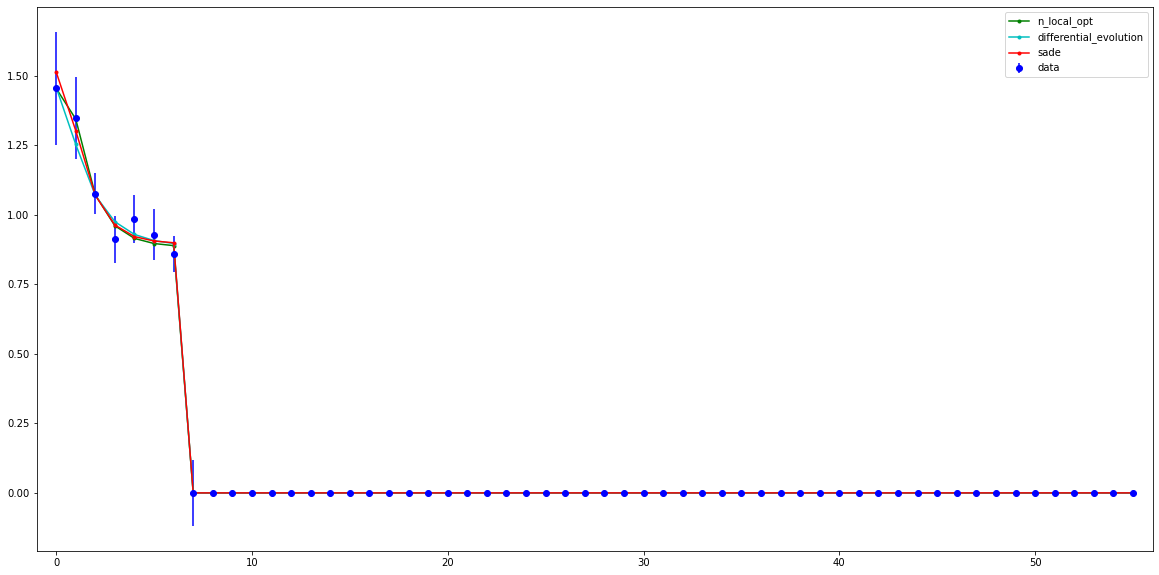

0.04136085510253906
n_local_opt: time 0.13988590240478516 ; Q  8.477929423436237
differential evolution: time 4.111423969268799 ; Q  3.7691567727466144
self adaptive differential evolution: time 3.4199182987213135 ; Q 3.206861282071955,  best x : [9.31664822e+02 3.72712263e-01 1.38488537e+02 4.63284132e-01
 2.98309062e+00 1.47803538e+00 1.77856814e+01 5.55981213e-01
 7.57179319e-02 7.48534072e+01 1.17989373e+02 1.88788286e-02]


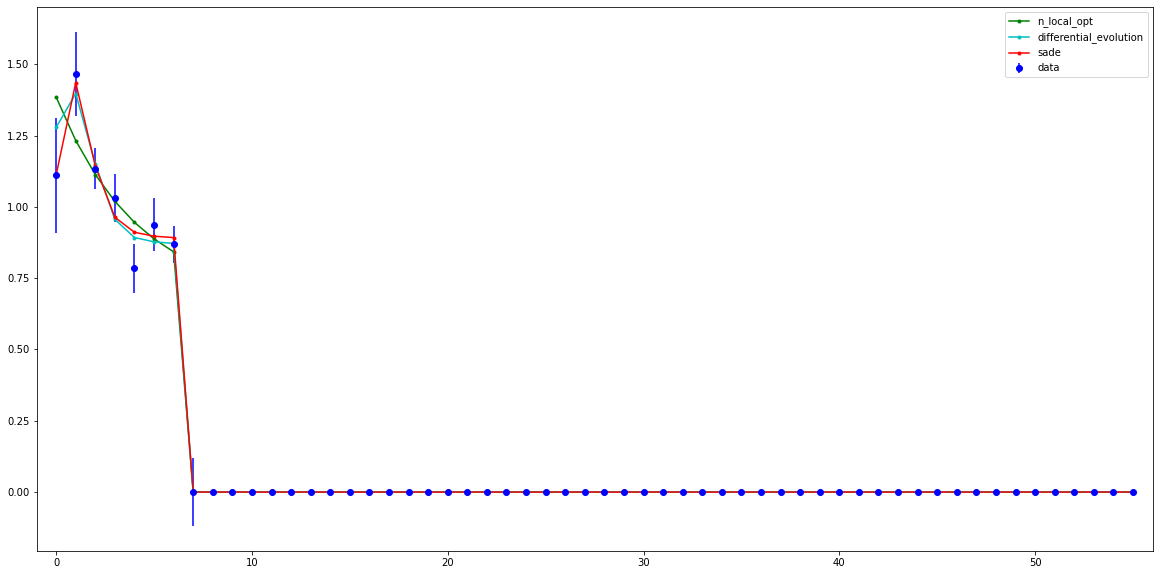

0.06733393669128418
n_local_opt: time 0.9856042861938477 ; Q  3.0453547447317986
differential evolution: time 3.9069912433624268 ; Q  3.7921265345219686
self adaptive differential evolution: time 3.7113590240478516 ; Q 3.6935304116451966,  best x : [1.26122727e-01 4.98172795e-02 1.07809737e+03 8.92589913e-02
 3.15401406e+01 1.49976937e+01 2.68447703e+01 3.17462883e+02
 8.87924533e-03 1.06776607e+02 1.20010292e+02 2.58982211e-01]


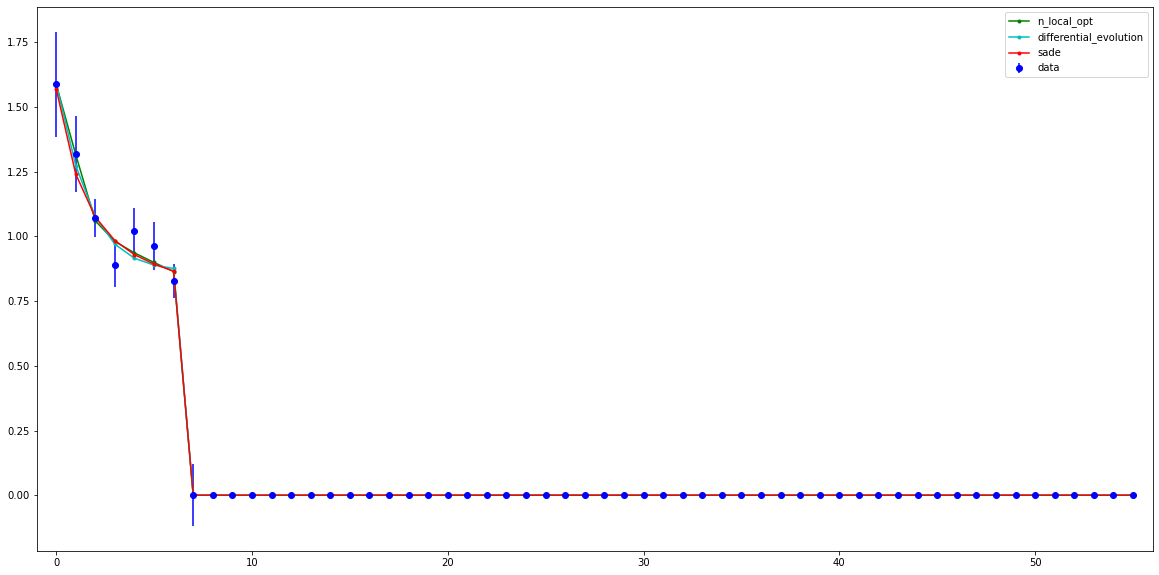

0.036559104919433594
n_local_opt: time 0.2666330337524414 ; Q  4.878974544792674
differential evolution: time 4.094299077987671 ; Q  5.171221203836616
self adaptive differential evolution: time 2.450242042541504 ; Q 5.289085024300666,  best x : [2.08787411e+01 1.58371024e-01 2.15426249e+02 2.65800579e-01
 7.70157474e+00 1.22034856e+00 5.73082771e+01 1.40989893e+02
 2.74408603e-02 1.40411123e+00 2.84748715e+03 5.05459567e-04]


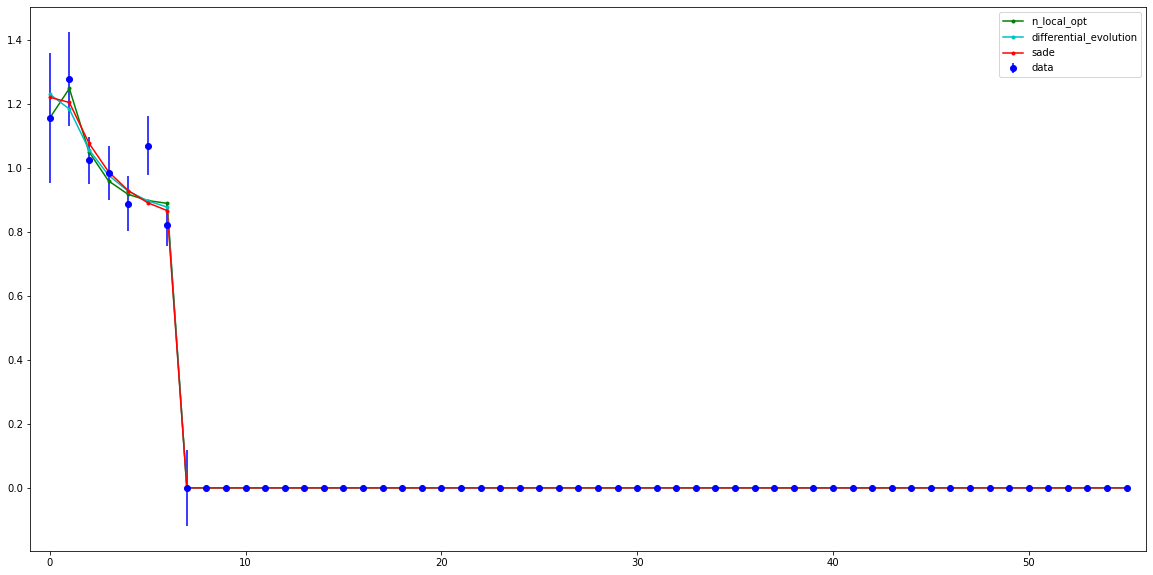

0.037241220474243164
n_local_opt: time 0.5530369281768799 ; Q  1.1498097349260235
differential evolution: time 4.39488410949707 ; Q  1.17595742599393
self adaptive differential evolution: time 2.403676748275757 ; Q 1.1939027438756602,  best x : [2.88087519e+01 6.73488651e-02 2.08052899e+04 1.65361757e-02
 1.85267487e+01 6.10676134e+01 4.45873973e+01 2.97453527e+00
 1.46539934e-02 4.97559860e+00 4.47151056e-01 1.04690320e-02]


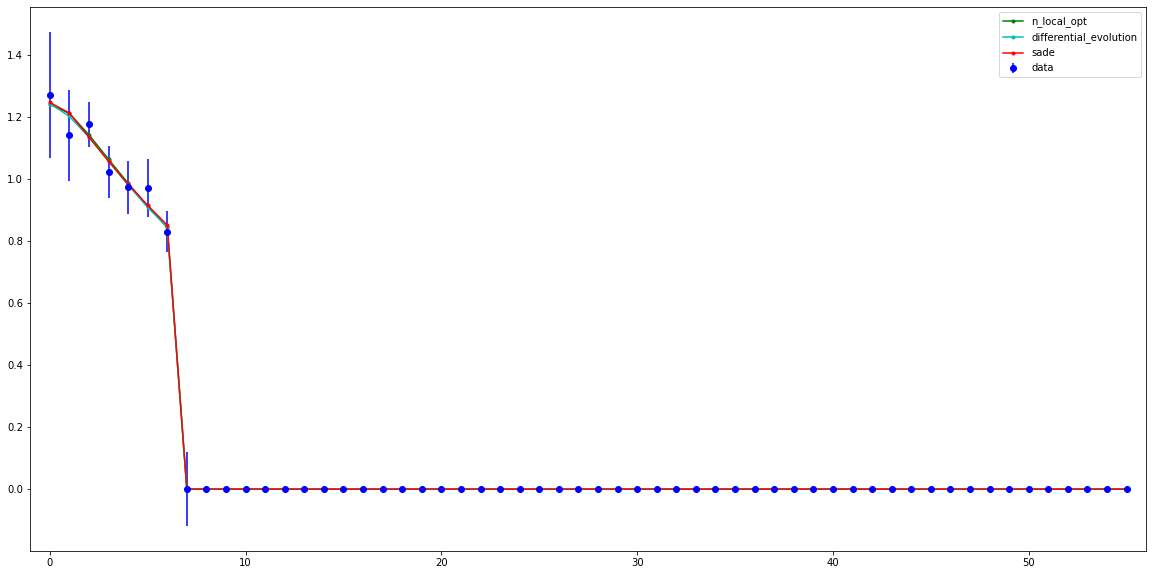

In [202]:
########################## 1
t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
vv = np.arange(7)    # A 1:8 20Hz


vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
##vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5','ibs':0 }

par['model_type'] = 'tm5_smr'  # extended TM model
#par['model_type'] = 'tm5_smr'



########################## 2
i0=6
idx = df9.index[i0]
print('\n\n'+str(i0)+'  '+df9.loc[idx,'comments']+'\n')
Ts  = df9.loc[idx,'comments1']
#ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
#is_fited_pulses = (abs(ampsa[0])>1e-14)

is_fited_pulses = True
if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):

#try:
    #par['fited_pulses']=True
    Q2 =[]
    tt =[]
    x = []
    ampsa = df9.loc[idx,'stp_mean_fit_bootstrap']
    nbs = int(ampsa.shape[0]/npar)
    nbs=5
    for ibs in range(nbs): #range(nbs):
        
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
        
        par['ibs']=ibs
        #Q4, tt4, x4, algs, colors = fit_TM_cell(idx,df9,par)
        i=idx 




        ########################## 3
        #breakpoint()
        aba_case=False
        if 'aba_case' in par:
            aba_case = par['aba_case']

        model_type='tm5'
        if 'model_type' in par:
            model_type = par['model_type']    

        if par['fited_pulses']==True:
            ampsa = df9.loc[i,'stp_mean_fit_bootstrap']
            siga = df9.loc[i,'stp_sigma_fit_bootstrap']  
            #if abs(ampsa[0])<1e-14:
                #ampsa = df.loc[i,'stp_mean_bootstrap']
                #siga = df.loc[i,'stp_sigma_bootstrap']
        else:
            ampsa = df9.loc[i,'stp_mean_bootstrap']
            siga = df9.loc[i,'stp_sigma_bootstrap']

        Ts = df9.loc[i,'comments1']
        Ts = np.array(Ts[0][:].strip().split()).astype(float)

        #breakpoint()

        #A3 = df.loc[i,'comments']
        #A3i = np.array(A3[0][:].strip().split()).astype(float)
        #A4 = np.ones((len(A3),len(A3i)))
        #for ia3 in range(len(A3)):
        #    A3i = np.array(A3[ia3][:].strip().split()).astype(float)
        #    A4[ia3,:] = A3i
        ##A4.shape 


        ibs  = par['ibs']
        npar = 56
        #amps = ampsa[ibs*npar + np.arange(npar)]
        ampsa1 = ampsa.reshape((-1,npar))
        amps = ampsa1[ibs,:].ravel()

        do_this=1
        if do_this==0:
            #sig  = siga #[(ibs-1)*npar + np.arange(npar)]
            ##A3e  = A4[:,ibs ].ravel()
            siga1 = siga.reshape((-1,npar))
            sig = siga1[ibs,:].ravel()
            
        else:
            #sig = np.std(ampsa1,axis=0).ravel() # reestimate sigma
            sig=pd.DataFrame(ampsa1).std(axis=0).values
        
        DT0 = 25000

        # restrict set of fited data
        vv = par['amplitudes_selected_for_TM_training']
        #vv = np.arange(8)    # A 1:8
        #vv = np.arange(npar) # all
        #vv = np.concatenate([vv,vv+32, vv+44]) # without recovery

        amps0 = amps
        amps = np.zeros(amps.shape)
        amps[vv] = amps0[vv]

             #  tF   p0     tD  dp         A            A1           A2      tDmin  dd   t_FDR t_SMR dp0 
        x0 = [ 100,  0.1,  100, 0.1, amps[0]/0.1, amps[0]/0.1,  amps[0]/0.1, 10,   0.05, 100,  100,  0.02 ]

        x0 = np.array(x0)

        #dxx = np.array([1e3, 20, 1e3, 1e2,  20, 20, 20,  1e1, 20, 1e2 ])
        dxx = np.array([1e3,  10, 1e3, 10,  20, 20, 20,  1e3, 20, 1e3, 1e3, 50 ])

        #breakpoint()
        if model_type=='tm5':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm4':
            x0 = x0[0:7]
            dxx = dxx[0:7]

        if model_type=='tm5_fdr2':
            x0 = x0[0:10]
            dxx = dxx[0:10]

        if model_type=='tm5_smr':
            x0 = x0    
            dxx = dxx
        #print(x0)
        #Q0, A0 = QA_TM_aba_synphys(x0, amps, sig, Ts,DT0,model_type)
        ##print(x0)
        #print('initial Q: ',str(Q0))

        #           tF      p0    tD        dp           A                A1                  A2              tDmin   dd   tD2
        #xlower = [  0.1,   0.01,   0.1,     0.0001,     amps[0]/1*1e-1,   amps[0]/1*1e-1,     amps[0]/1*1e-1,  1,     1e-3, 1]
        xlower = x0/dxx
        xlower = np.array(xlower).reshape((-1,))
        #xupper = [  1e5,   1,      1e5,     1,          amps[0]/0.01*1e1, amps[0]/0.01*1e1,   amps[0]/0.01*1e1, 100,  1,    1e4]
        #xupper = np.array(xupper)
        xupper = x0*dxx
        xupper = np.array(xupper).reshape((-1,))
        bounds = [] #np.zeros(len(xlower))
        for ibo in range(len(xlower)):
            bounds = bounds + [(xlower[ibo],xupper[ibo])]
        tt=[]

        x0 = np.array(x0).reshape((-1,))
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        pop = pg.population(prob=prob, size = 1000)
        
        t1 = time.time()
        for iii in range(1000):
            prob.fitness(x0) 
        t2 = time.time()
        print(t2 - t1) 
        
        
        uda = pg.nlopt('lbfgs') #'tnewton_precond_restart') #'bobyqa')   #"cobyla")
        algo = pg.algorithm(uda)        
        t1 = time.time()
        pop2 = algo.evolve(pop)
        t2 = time.time()
        x = pop2.champion_x
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='g')
        #print(algs[ii]+ ' Q = '+str(Q)+' '+colors[ii])
        print('n_local_opt: time ' + str(t2 - t1), '; Q ',str(Q))
        
  
        
        uda = pg.de(gen = 100, F = 0.8, CR = 0.9, variant = 2, ftol = 1e-6, xtol = 1e-6)
        algo = pg.algorithm(uda)
        t1 = time.time()
        pop2 = algo.evolve(pop)
        t2 = time.time()
        x = pop2.champion_x
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='c')
        print('differential evolution: time ' + str(t2 - t1), '; Q ',str(Q)) 
        
        
        prob = pg.problem(jit_rosenbrock2(amps.reshape((-1,1)),sig.reshape((-1,1)),Ts,model_type,xlower,xupper))
        #pop = pg.population(prob=prob, size = 1000)
        uda = pg.de1220(gen = 100, allowed_variants = [2,3,7,10,13,14,15,16], variant_adptv = 1, ftol = 1e-6, xtol = 1e-6, memory = False)
        algo = pg.algorithm(uda)
        archi = pg.archipelago(n=32,algo=algo, prob=prob, pop_size=32)
        t1 = time.time()
        #pop2 = algo.evolve(pop)
        archi.evolve() 
        archi.wait()
        t2 = time.time()
        qq=np.array(archi.get_champions_f())
        xx=np.array(archi.get_champions_x())
        
        x = xx[qq.argmin(),:]
        x=np.exp(x)
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='r')
        print('self adaptive differential evolution: time ' + str(t2 - t1), '; Q '+str(Q)+',  best x : '+str(x)) 
        
        
        do_this=0
        if do_this==1:
            uda = pg.nsga2(gen = 100, cr = 0.95, eta_c = 10., m = 0.01, eta_m = 50.) 
            algo = pg.algorithm(uda)
            t1 = time.time()
            pop2 = algo.evolve(pop)
            t2 = time.time()
            x = pop2.champion_x
            x=np.exp(x)
            Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
            plt.plot(np.arange(len(amps)), A, '.-',color='m')
            print('Non dominated Sorting Genetic Algorithm (NSGA-II): time ' + str(t2 - t1), '; Q ',str(Q)) 
        
        #algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
        #colors = ['y',   'r',                           'c',          'y',         'g' ]
        A3e=1
        plt.errorbar(np.arange(len(amps)), amps*A3e, yerr=sig*A3e, fmt =  'bo')
        

        #algs_short = ['differential_evolution',  'random_starts' ]
        #algs_short = ['n_local_opt' ,'differential_evolution','sade','nsga2','data']
        algs_short = ['n_local_opt' ,'differential_evolution','sade','data']
        #plt.legend(algs)
        plt.legend(algs_short)

        #fig = plt.gcf()
        #set_position(plt.gca, [10, 10, 100, 500], which='both')
        plt.xlim((min(vv)-1,max(vv)+2)) 
        #thismanager = plt.get_current_fig_manager()
        #thismanager.window.SetPosition((500, 0))
        #plt.hold(False)
        plt.pause(0.5) 

# DO NOT RUN THIS

In [83]:
import time
import numpy as np
import pygmo as pg
from numba import jit, float64
dummy_x = np.full((2000,), 1.)

class jit_rosenbrock:
    def fitness(self,x):
        return jit_rosenbrock._fitness(x)
    @jit #(float64[:](float64[:]),nopython=True)
    def _fitness(x):
        retval = np.zeros((1,))
        for i in range(len(x) - 1):
            tmp1 = (x[i + 1]-x[i]*x[i])
            tmp2 = (1.-x[i])
            retval[0] += 100.*tmp1*tmp1+tmp2*tmp2
        return retval
    def get_bounds(self):
        return (np.full((self.dim,),-5.),np.full((self.dim,),10.))
    def __init__(self,dim):
        self.dim = dim
prob_jit = pg.problem(jit_rosenbrock(2000))
start_time = time.time(); [prob_jit.fitness(dummy_x) for i in range(100)]; print(time.time() - start_time) 

0.24950289726257324


In [84]:
type(prob_jit.fitness(dummy_x))

numpy.ndarray

In [85]:
from numba import jit, float64
class jit_rosenbrock2:
    def fitness(self,x):
        return jit_rosenbrock2._fitness(x)
    @jit(float64[:](float64[:]),nopython=True)
    def _fitness(x):
        retval = np.zeros((1,))
        for i in range(len(x) - 1):
            tmp1 = (x[i + 1]-x[i]*x[i])
            tmp2 = (1.-x[i])
            retval[0] += 100.*tmp1*tmp1+tmp2*tmp2
        return retval
    def get_bounds(self):
        return (np.full((self.dim,),-5.),np.full((self.dim,),10.))
    def __init__(self,dim):
        self.dim = dim
prob_jit2 = pg.problem(jit_rosenbrock2(2000))
start_time = time.time(); [prob_jit2.fitness(dummy_x) for i in range(1000)]; print(time.time() - start_time) 



0.02787494659423828


In [86]:
'nr5a1 L4; vip L4'

'nr5a1 L4; vip L4'

In [87]:
df9.loc[df9.index.str.contains('nr5a1'),:]

name  \
nr5a1 L2/3; nr5a1 L2/3  [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...   
pvalb L4; nr5a1 L5      [aba_2019_synphys_pair_97450; pvalb L4; nr5a1 L5]   
sst L4; nr5a1 L4          [aba_2019_synphys_pair_73279; sst L4; nr5a1 L4]   
pvalb L4; nr5a1 L4      [aba_2019_synphys_pair_74339; pvalb L4; nr5a1 L4]   
nr5a1 L4; sst L4          [aba_2019_synphys_pair_89701; nr5a1 L4; sst L4]   
nr5a1 L4; vip L4          [aba_2019_synphys_pair_97762; nr5a1 L4; vip L4]   
nr5a1 L4; pvalb L4      [aba_2019_synphys_pair_74371; nr5a1 L4; pvalb L4]   

                                area          synapse_type_2  \
nr5a1 L2/3; nr5a1 L2/3  [L2/3; L2/3]  nr5a1 L2/3; nr5a1 L2/3   
pvalb L4; nr5a1 L5          [L4; L5]      pvalb L4; nr5a1 L5   
sst L4; nr5a1 L4            [L4; L4]        sst L4; nr5a1 L4   
pvalb L4; nr5a1 L4          [L4; L4]      pvalb L4; nr5a1 L4   
nr5a1 L4; sst L4            [L4; L4]        nr5a1 L4; sst L4   
nr5a1 L4; vip L4            [L4; L4]        nr5a1 L4; vip L4   
nr5a1 L4; pvalb L4          [L4; L4]      nr5a1 L4; pvalb L4   

                                                                stp_freq  \
nr5a1 L2/3; nr5a1 L2/3  [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
pvalb L4; nr5a1 L5      [50.0 x 8_An/A1, 7.91 x 1_An/A1, 50.0 x 4_An/A1]   
sst L4; nr5a1 L4        [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
pvalb L4; nr5a1 L4      [50.0 x 8_An/A1, 7.81 x 1_An/A1, 50.0 x 4_An/A1]   
nr5a1 L4; sst L4        [20.0 x 8_An/A1, 3.98 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1 L4; vip L4        [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   
nr5a1 L4; pvalb L4      [20.0 x 8_An/A1, 3.95 x 1_An/A1, 20.0 x 4_An/A1]   

                                                               stp_mean_1  \
nr5a1 L2/3; nr5a1 L2/3  [[[[5.20272884859949e-12, 7.02658480543716e-12...   
pvalb L4; nr5a1 L5      [[[[-0.000279230408729111, -0.0015574098478622...   
sst L4; nr5a1 L4        [[[[-1.06699934717427e-11, -8.81900324566579e-...   
pvalb L4; nr5a1 L4      [[[[-0.000550761796700806, -0.0002319912140221...   
nr5a1 L4; sst L4        [[[[4.06675697836392e-12, 3.4105514694406e-12,...   
nr5a1 L4; vip L4        [[[[9.3060277328699e-12, 4.39914026172878e-12,...   
nr5a1 L4; pvalb L4      [[[[-3.35254331994045e-13, 6.00544555971788e-1...   

                       stp_sigma  \
nr5a1 L2/3; nr5a1 L2/3   [[nan]]   
pvalb L4; nr5a1 L5       [[nan]]   
sst L4; nr5a1 L4         [[nan]]   
pvalb L4; nr5a1 L4       [[nan]]   
nr5a1 L4; sst L4         [[nan]]   
nr5a1 L4; vip L4         [[nan]]   
nr5a1 L4; pvalb L4       [[nan]]   

                                                                 comments  \
nr5a1 L2/3; nr5a1 L2/3  ['nr5a1 L4; nr5a1 L4', 'nr5a1 L2/3; nr5a1 L2/3...   
pvalb L4; nr5a1 L5      ['pvalb L5; nr5a1 L4', 'pvalb L; nr5a1 L4', 'p...   
sst L4; nr5a1 L4                               ['sst L4; nr5a1 L4'] , n=5   
pvalb L4; nr5a1 L4                           ['pvalb L4; nr5a1 L4'] , n=7   
nr5a1 L4; sst L4        ['unknown L2/3; sst L2/3', 'nr5a1 L4; sst L4',...   
nr5a1 L4; vip L4        ['nr5a1 L4; vip L4', 'tlx3 L5; vip L5', 'unkno...   
nr5a1 L4; pvalb L4      ['nr5a1 L4; pvalb L4', 'nr5a1 L4; pvalb L5'] ,...   

                                                                comments1  \
nr5a1 L2/3; nr5a1 L2/3  [0    50   100   150   200   250   300   350  ...   
pvalb L4; nr5a1 L5      [0    50   100   150   200   250   300   350  ...   
sst L4; nr5a1 L4        [0    50   100   150   200   250   300   350  ...   
pvalb L4; nr5a1 L4      [0    50   100   150   200   250   300   350  ...   
nr5a1 L4; sst L4        [0    50   100   150   200   250   300   350  ...   
nr5a1 L4; vip L4        [0    50   100   150   200   250   300   350  ...   
nr5a1 L4; pvalb L4      [0    50   100   150   200   250   300   350  ...   

                                                      numbers_of_currents  \
nr5a1 L2/3; nr5a1 L2/3  [25   25    5    5    5    5    5    5    5   ...   
pvalb L4; nr5a1 L5      [23   23    

# ITS NOT MAIN FIT HERE! 
### Tsodyks Markram model 5 parameters + 2 parameters to fit 2 phase changing release probability 



0  ['nr5a1 L4; vip L4', 'tlx3 L5; vip L5', 'unknown L5; vip L5'] , n=5

initial Q:  466.57437905271655
shgo : elapsed time 9.5367431640625e-07s 
differential_evolution: elapsed time 87.10254406929016s 
dual_annealing: elapsed time 0.010574817657470703s 
basinhopping: elapsed time 1.9073486328125e-06s 
self adaptive differential evolution: time 7.152557373046875e-07 ; Q  466.57437905271655
random_start: elapsed time 8.731947183609009s 
shgo Q = 466.57437905271655 y
differential_evolution Q = 1.371633647151935 m
dual_annealing Q = 1998.9839581271372 c
basinhopping Q = 466.57437905271655 y
self ajusting differential evolution Q = 466.57437905271655 r
random_starts Q = 1.3486705423644327 g


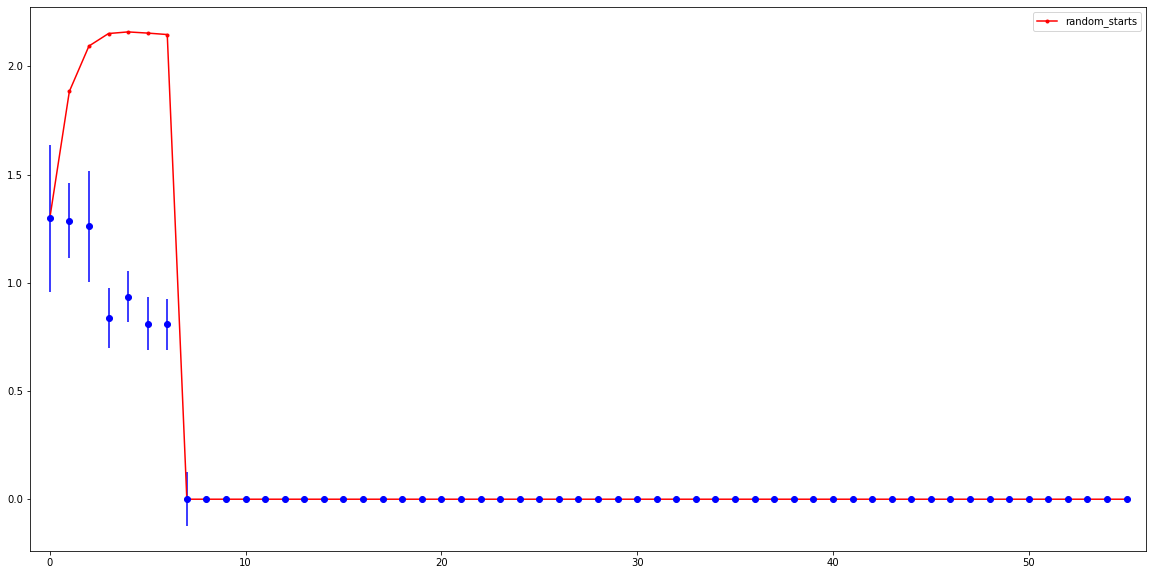

best x: [array([1.00000000e+02, 1.00000000e-01, 1.00000000e+02, 1.00000000e-01,
       1.29771997e+01, 1.29771997e+01, 1.29771997e+01, 1.00000000e+01,
       5.00000000e-02, 1.00000000e+02, 1.00000000e+02, 2.00000000e-02]), array([6.15493698e+03, 6.53021137e-01, 2.81174726e+04, 8.36401152e-01,
       1.86433215e+01, 3.35949665e+01, 1.45261825e+02, 9.73154108e+03,
       8.44993515e-01, 7.86860497e+04, 7.62261655e+04, 2.57154563e-01]), array([3.24726643e+02, 3.92791246e-01, 1.80472611e+02, 1.32453831e-01,
       3.26527730e+00, 3.49630288e+00, 3.73179189e+01, 3.37724497e+01,
       1.35895617e-01, 9.85314833e+04, 4.99813945e+01, 5.71967112e-01])]
initial Q:  230.20514771845615
shgo : elapsed time 9.5367431640625e-07s 
differential_evolution: elapsed time 222.96726393699646s 
dual_annealing: elapsed time 0.006308794021606445s 
basinhopping: elapsed time 0.0s 
self adaptive differential evolution: time 2.1457672119140625e-06 ; Q  230.20514771845615
random_start: elapsed time 22.0522859096

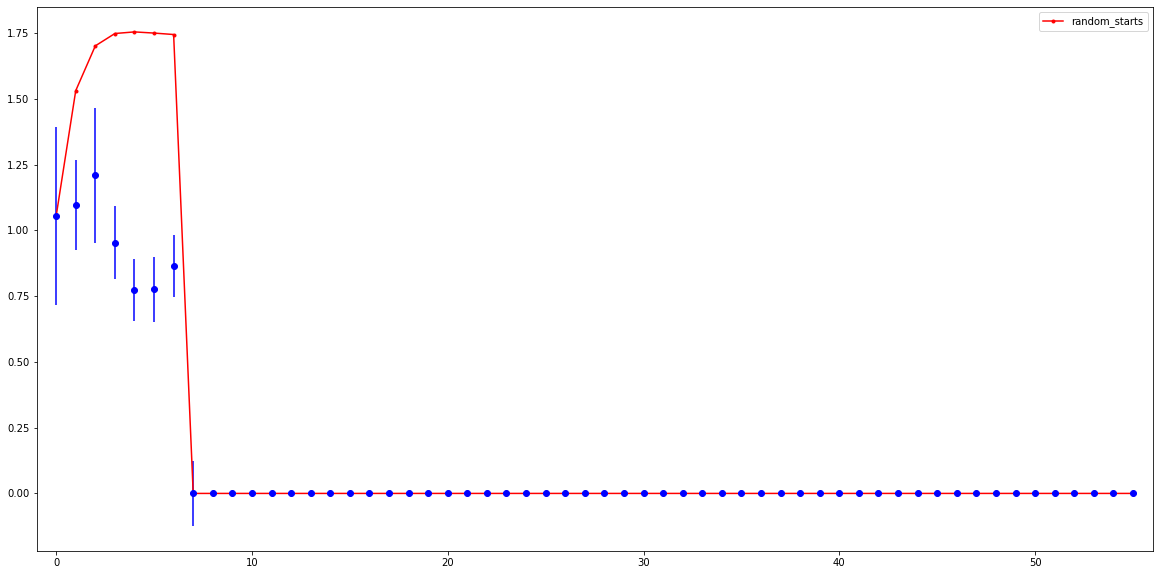

best x: [array([1.00000000e+02, 1.00000000e-01, 1.00000000e+02, 1.00000000e-01,
       1.05457111e+01, 1.05457111e+01, 1.05457111e+01, 1.00000000e+01,
       5.00000000e-02, 1.00000000e+02, 1.00000000e+02, 2.00000000e-02]), array([1.02279668e+04, 5.98292126e-01, 7.01327213e+04, 5.39340066e-02,
       2.15485589e+01, 1.63045361e+02, 2.09862200e+02, 9.59888264e+03,
       4.75569044e-01, 5.15749192e+04, 1.18874311e+03, 7.59264943e-01]), array([1.30921156e+04, 3.03265442e-01, 1.82423025e+02, 2.11568111e-01,
       3.30158331e+00, 1.55955743e+01, 1.14190728e+00, 7.46122261e-02,
       3.33949953e-02, 4.22419140e+02, 4.07365163e+03, 7.30848359e-01])]
initial Q:  223.49757234938693
shgo : elapsed time 0.0s 
differential_evolution: elapsed time 88.57547116279602s 
dual_annealing: elapsed time 0.005844831466674805s 
basinhopping: elapsed time 0.0s 
self adaptive differential evolution: time 0.0 ; Q  223.49757234938693
random_start: elapsed time 9.432634830474854s 
shgo Q = 223.49757234938693 y

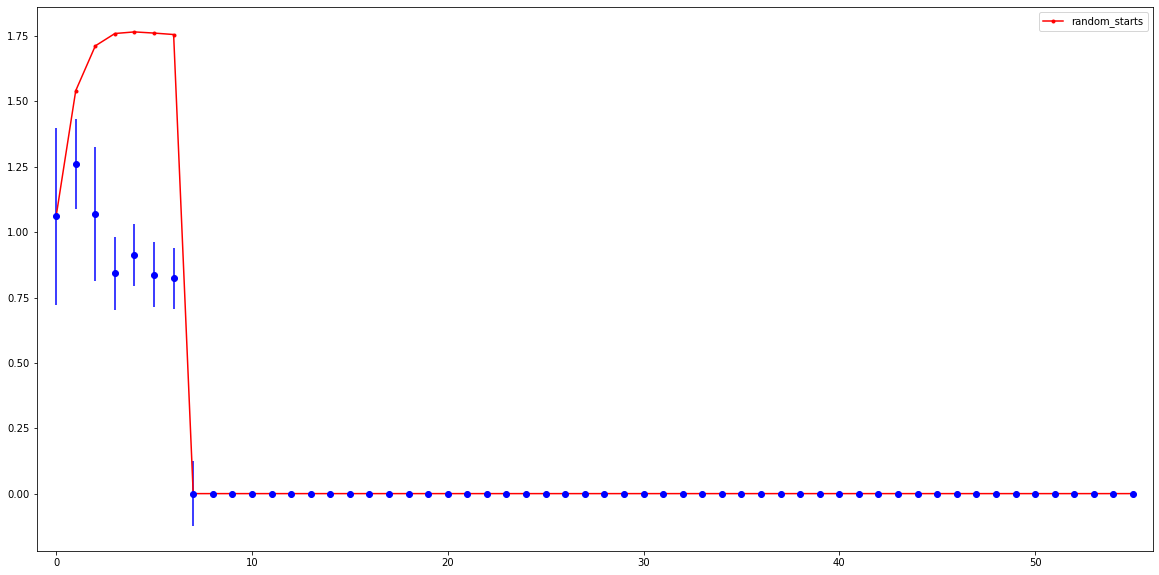

best x: [array([1.00000000e+02, 1.00000000e-01, 1.00000000e+02, 1.00000000e-01,
       1.06131654e+01, 1.06131654e+01, 1.06131654e+01, 1.00000000e+01,
       5.00000000e-02, 1.00000000e+02, 1.00000000e+02, 2.00000000e-02]), array([3.61456664e+04, 4.50918028e-01, 9.85948721e+04, 4.25726437e-01,
       1.70215537e+01, 1.94645182e+01, 1.79894544e+02, 5.66522375e+03,
       7.56606679e-01, 4.65742851e+04, 8.28683487e+04, 5.77471408e-01]), array([1.78668887e+01, 4.77423471e-02, 3.09759583e+02, 6.84382822e-01,
       2.23053848e+01, 7.00758364e-01, 2.41569951e+01, 4.51770411e+03,
       1.97977778e-01, 7.20134565e+03, 2.65699970e+03, 6.51707204e-01])]
initial Q:  241.1222172350806
shgo : elapsed time 9.5367431640625e-07s 
differential_evolution: elapsed time 95.32631802558899s 
dual_annealing: elapsed time 0.005224943161010742s 
basinhopping: elapsed time 1.1920928955078125e-06s 
self adaptive differential evolution: time 9.5367431640625e-07 ; Q  241.1222172350806
random_start: elapsed time 

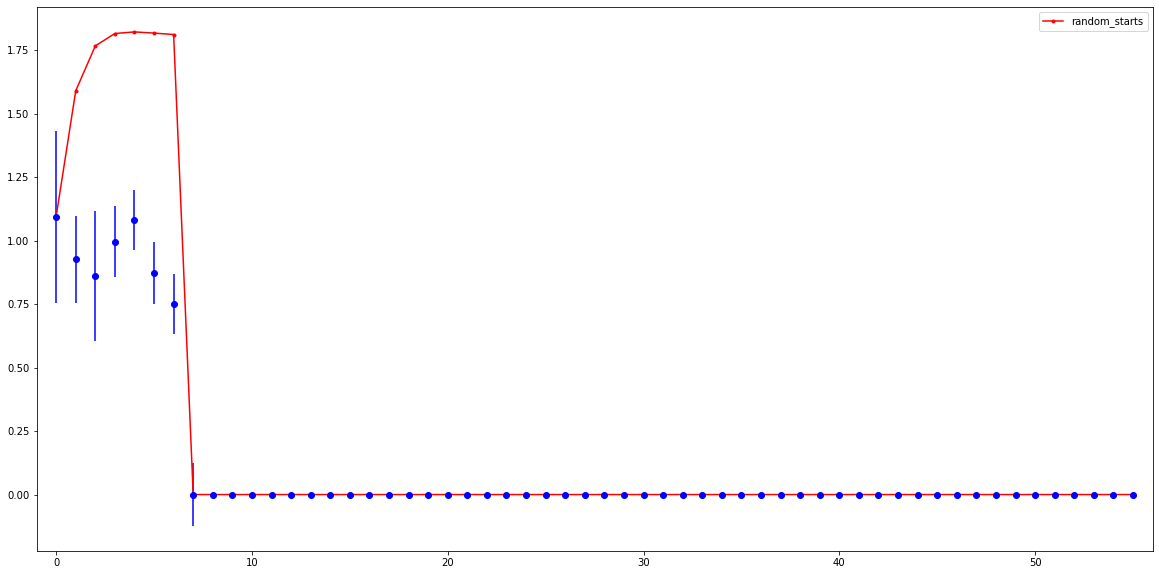

best x: [array([1.00000000e+02, 1.00000000e-01, 1.00000000e+02, 1.00000000e-01,
       1.09539942e+01, 1.09539942e+01, 1.09539942e+01, 1.00000000e+01,
       5.00000000e-02, 1.00000000e+02, 1.00000000e+02, 2.00000000e-02]), array([1.34770216e+04, 5.52997813e-01, 8.83340332e+04, 9.50870744e-01,
       4.66061166e+01, 1.78262306e+02, 6.07978241e+01, 2.60970681e+03,
       7.31548777e-02, 2.80851343e+04, 6.42771237e+04, 7.60563123e-01]), array([6.67038973e+04, 9.49178948e-02, 1.56486218e+04, 2.51550429e-02,
       9.11855885e+00, 3.96849998e+01, 1.22700329e+00, 4.16893996e+03,
       4.10022960e-03, 1.59609179e+01, 2.89424604e+03, 4.43412018e-01])]
initial Q:  148.34652430988083
shgo : elapsed time 7.152557373046875e-07s 
differential_evolution: elapsed time 537.7341990470886s 
dual_annealing: elapsed time 0.006314992904663086s 
basinhopping: elapsed time 9.5367431640625e-07s 
self adaptive differential evolution: time 9.5367431640625e-07 ; Q  148.34652430988083
random_start: elapsed time

KeyboardInterrupt: 

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import scipy.optimize as opt
import pygmo as pg
import pandas as pd
#from pylab import *
#class sphere_function:
#    def fitness(self, x):
#        return [sum(x*x)]
#
#     def get_bounds(self):
#        return ([-1,-1],[1,1])

#prob = pg.problem(sphere_function())


t00 = time.time()
Q3 =[]
TT =[]
X = []
A3=[]
Idc=[]
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
#vv = np.arange(8)    # A 1:8 20Hz
vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
#vv = np.concatenate([vv,vv+32, vv+44]) # without recovery

#par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
#       'model_type' : 'tm5','ibs':0 }

par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':False, 'figure':0,
       'model_type' : 'tm5','ibs':0, 'dont_plot':0 }

par['model_type'] = 'tm5_smr'  # extended TM model
#par['model_type'] = 'tm5_smr'


for i in  [0]: #range(len(df9.index)): # #range(39,40): #range(22,23): #range(len(df9.index)):
    idx = 'nr5a1 L4; vip L4' #df9.index[i] #'nr5a1 L4; vip L4' #df9.index[i]
    print('\n\n'+str(i)+'  '+df9.loc[idx,'comments']+'\n')
    Ts  = df9.loc[idx,'comments1']
    #ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
    #is_fited_pulses = (abs(ampsa[0])>1e-14)
    
    is_fited_pulses = True
    if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):

    #try:
        #par['fited_pulses']=True
        Q2 =[]
        A2=[]
        tt =[]
        x = []
        ampsa = df9.loc[idx,'stp_mean_fit_bootstrap']
        nbs = int(ampsa.shape[0]/npar)
        nbs=10
        for ibs in range(nbs):

            if ibs>3:
                par['dont_plot']=1
            else:
                par['dont_plot']=0
                fig, ax = plt.subplots(figsize=(20, 10))
            par['figure']=fig
            par['ibs']=ibs
            Q4, tt4, x4, algs, colors, A4 = fit_TM_cell(idx,df9,par)
            nalg = len(tt)
            
            print('best x: '+str(x4))
        
            Q2 = Q2 + [Q4]
            tt = tt + [tt4]
            x = x + [x4]
            A2 = A2+[A4]
    #except:
    else:
        print(Ts)
        Q2 = (10*np.zeros(nalg)).tolist()
        tt = (0*np.zeros(nalg)).tolist()
        x = (0*np.zeros(nalg)).tolist()
        
    Q3 = Q3 + [Q2]
    TT = TT + [tt]
    X = X + [x]
    Idc = Idc + [idx]
    A3 = A3+[A2]
    

    
#Q3 = pd.DataFrame(Q3)  
#TT = pd.DataFrame(TT) 
t10 = time.time()
print('time : '+ str(t10-t00))


# Save results

#Q3.columns = algs
#algs2=algs
#for ialg, alg in enumerate(algs2): 
#    algs2[ialg] = alg + ' , time'
#TT.columns = algs2
#QT = pd.concat([Q3,TT],axis=1)

#X3 = pd.DataFrame(X)
##X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']
#X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x']

#QT = pd.concat([QT,X3],axis=1)
#QT.index = df9.index

##QTX = pd.concat([df9,QT],axis=1)
#QTX_extended = pd.concat([df9,QT],axis=1)

#QTX_extended.to_hdf('fit_aba_2019_A1_8_fited_pulses_TM_SMP0_syntypes_results','data')

Xa1=[]
Xa2=[]
Xa3=[]
for i in range(len(X)):
    Xi = np.array(X[i])
    Xa1 = Xa1 +[Xi[:,0,:]]
    Xa2 = Xa2 +[Xi[:,1,:]]
    Xa3 = Xa3 +[Xi[:,2,:]]
    
Aa1=[]
Aa2=[]
Aa3=[]
for i in range(len(A3)):
    Ai = np.array(A3[i])
    Aa1 = Aa1 +[Ai[:,0,:]]
    Aa2 = Aa2 +[Ai[:,1,:]]
    Aa3 = Aa3 +[Ai[:,2,:]]    
    
X3 = pd.DataFrame([Xa1,Xa2,Xa3]).T    
#X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']
X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x']
X3.index = np.array(Idc) #df9.index[0:len(X3.index)]

QTX_extended = pd.concat([df9,X3],axis=1)

#QTX_extended.to_hdf('fit_aba_2019_mean_fited_pulses_TM_SMP0_50bs_syntypes_results','data')



In [89]:
def  STP_sim3(x, T, init_state=None, model_type='tm5' ):

    N    = len(T)
    tF      = x[0] #.astype(float)
    p00     = x[1]
    tD      = x[2] #.astype(float)
    dp      = x[3]
    A       = 1 #x[4] # simplify A
    
    #breakpoint()
    mod_fdr2=False
    if model_type=='tm5_fdr2':  # should be :check freq. dependent recovery
        tDmin     = x[5]
        dd        = x[6]
        t_FDR     = x[7]
        mod_fdr2=True
        tDmax  = tD
        itDmin = 1/tDmin
        itDmax = 1/tDmax
        #breakpoint()
        
    mod_smr=False
    if model_type=='tm5_smr':  # should be :check freq. dependent recovery
        t_SMR   = x[8]
        dp0     = x[9]
        mod_smr=True
        #p00  = p00

    As = np.zeros((N,))
    state = np.zeros((N,4))

   
    if init_state is None :
        n = 1
        p0=p00
        p = p0
        d = 0
    else:
        n = init_state[0]
        p = init_state[1]
        d = init_state[2]
        p0= init_state[3]

    
    for i in range(0,N):
        if i==0:
            Dt = T[i]
        else:
            Dt = T[i]-T[i-1]
        
        if mod_fdr2:
            d0=d
            d = d*np.exp(-Dt/t_FDR) 
            n = 1 - (1 - n )*np.exp(-Dt*itDmax -(itDmin -itDmax)*t_FDR*(d0-d))
        else:
            n = 1 - (1 - n )*np.exp(-Dt/tD )
            
        if mod_smr:
            p01=p0
            p0=p00 + (p0 -p00)*np.exp(-Dt/t_SMR)
            p=p0 +(p -p01)*np.exp(-Dt/tF)
        else:
            p=p0 +(p -p0)*np.exp(-Dt/tF)
            

        As[i]=A*n*p
       
        n = n*(1-p)
        p = p + dp*(1-p)
        if mod_fdr2:
            d  = d + dd*(1-d) 
        if mod_smr:
            p0  = p0 - dp0*p0    
 
        state[i] = [n,p,d,p0]

    #return As, ns2, ps2, dpp0, p0, tF, tD, A
    return As, state

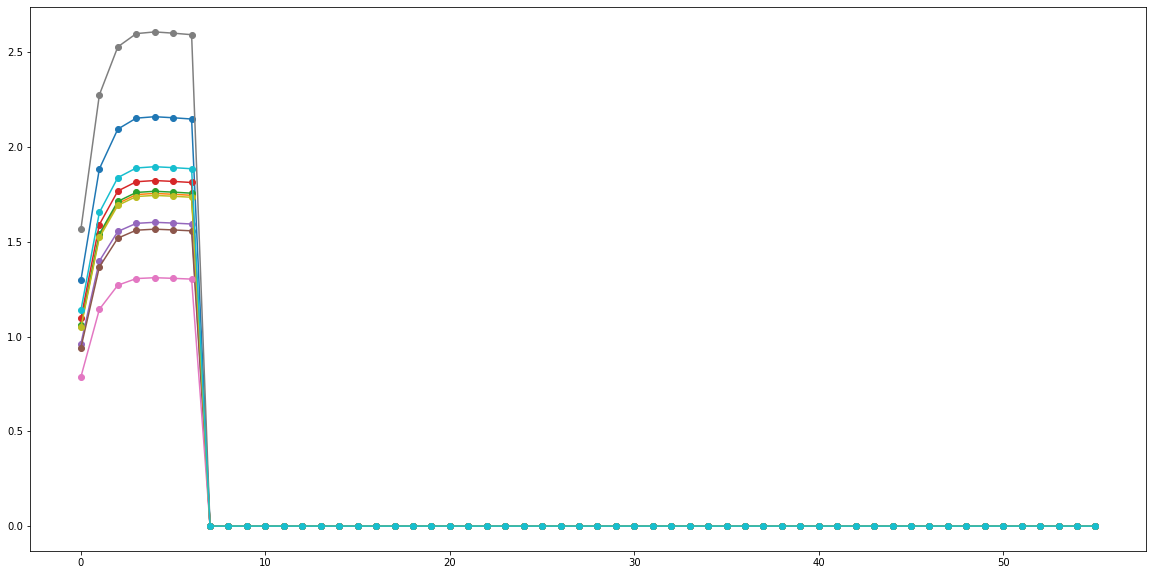

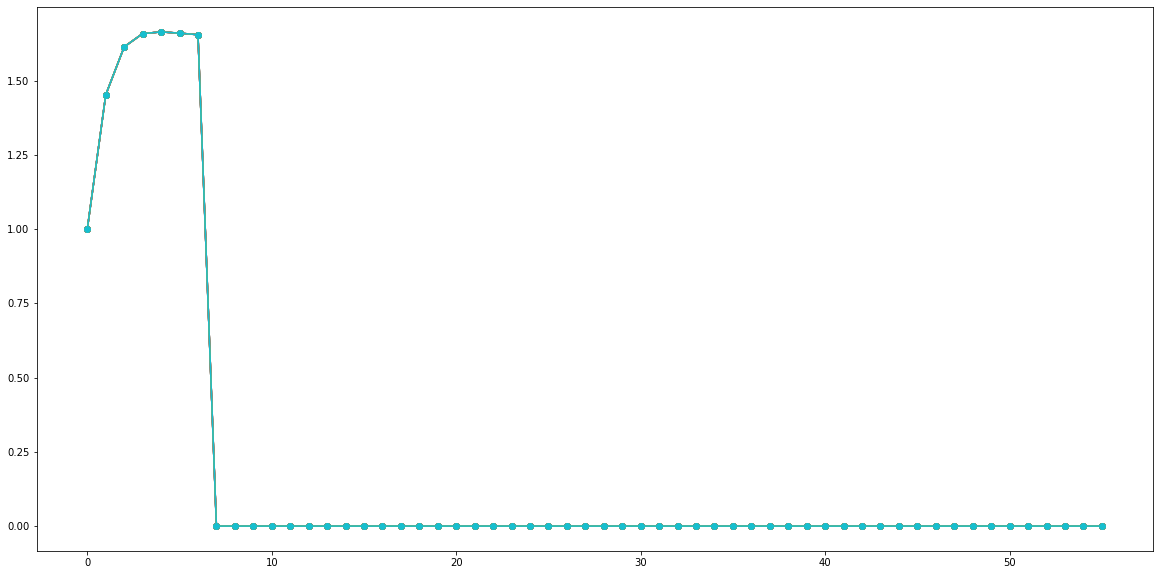

In [90]:
Aa1=[]
Aa2=[]
Aa3=[]
for i in range(len(A3)):
    Ai = np.array(A3[i])
    Aa1 = Aa1 +[Ai[:,0,:]]
    Aa2 = Aa2 +[Ai[:,1,:]]
    Aa3 = Aa3 +[Ai[:,2,:]]    
A5 = pd.DataFrame([Aa1,Aa2,Aa3]).T   
fig, ax = plt.subplots(figsize=(20, 10))
aa=Aa1[0].T
aa=aa
plt.plot(aa,'o-',figure=fig)
fig, ax = plt.subplots(figsize=(20, 10))
aa=Aa1[0].T
aa=aa/aa[0,:].reshape((1,-11))
plt.plot(aa,'o-',figure=fig)

(0, 1.6)

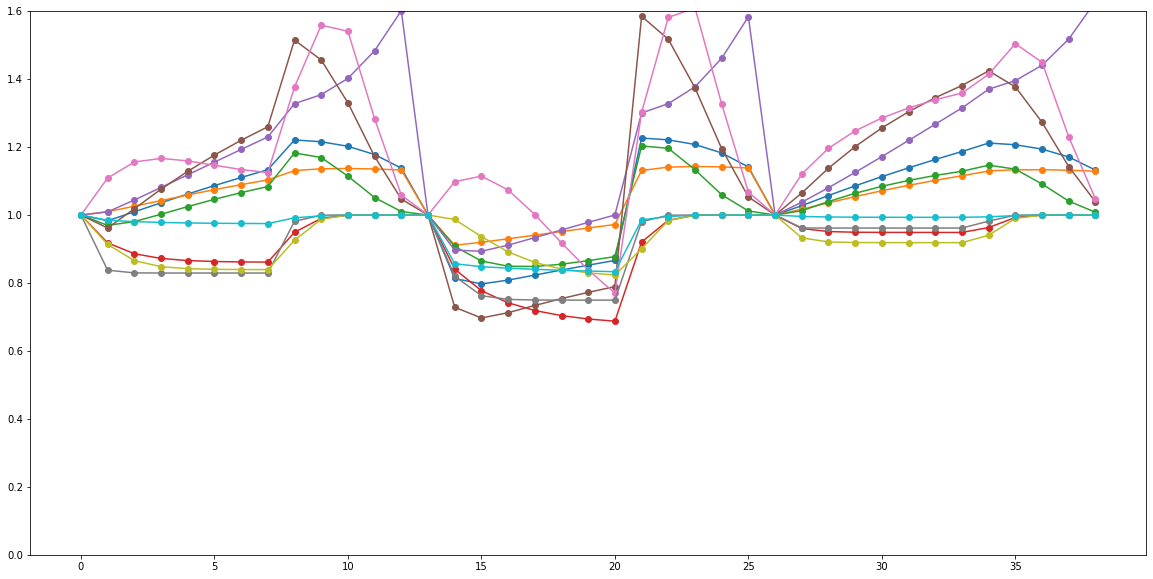

In [826]:
# transform labels from TM to An:A1
fs = [20, 50, 10] # Hz
N = 8
Trec = [125, 250, 500, 1000, 2000]
DT0 = 25000
xs = Xa1[0]

l_pre_post2=1
xs  =np.delete(xs, [5,6],axis=1)
As=np.zeros((l_pre_post2,0))
As2=np.zeros((xs.shape[0],0))
if 1:
    for f in fs:
        T = np.arange(N)*1000/f

        As2f = np.zeros((xs.shape[0],N+len(Trec)))
        for i2 in range(xs.shape[0]):
            as2, sts2 = STP_sim3(xs[i2,:],T,model_type = 'tm5_smr')
            
            As2f[i2,0:N] = as2
            for ri in range(len(Trec)):
                as2r, sts2r = STP_sim3(xs[i2,:], [Trec[ri]], init_state=sts2[-1], model_type='tm5_smr' ) 
                As2f[i2,N+ri] = as2r
                
        As2 = np.concatenate([As2,As2f],axis=1)

    As2 = As2/As2[:,0].reshape((-1,1))

import matplotlib.pyplot as plt    
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(As2[:,:].transpose(),'o-',figure=fig)
plt.ylim((0,1.6))

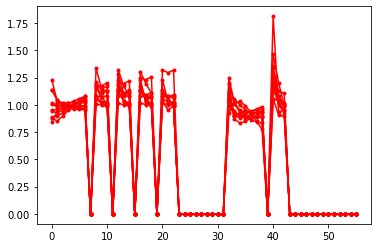

In [814]:
Xa1[0]
for i in range(Xa1[0].shape[0]):
        #x=np.exp(x)
        x = Xa1[0][i,:]
        Q, A = QA_TM_aba_synphys(x, amps, sig, Ts,DT0,model_type)
        plt.plot(np.arange(len(amps)), A, '.-',color='r')

###  Tsodyks Markram model 5 parameters



0  ['unknown L5; unknown L5', 'unknown L5; sim1 L5', 'tlx3 L5; fam84b L5', 'unknown L5; tlx3 L5', 'unknown L5; rorb L5', 'unknown L5; unknown L']

initial Q:  33.60584835669463
shgo : elapsed time 2.384185791015625e-07s 


/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in square
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in true_divide
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in double_scalars
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in double_scalars
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in true_divide
/home/stepaniu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in double_scalars


KeyboardInterrupt: 

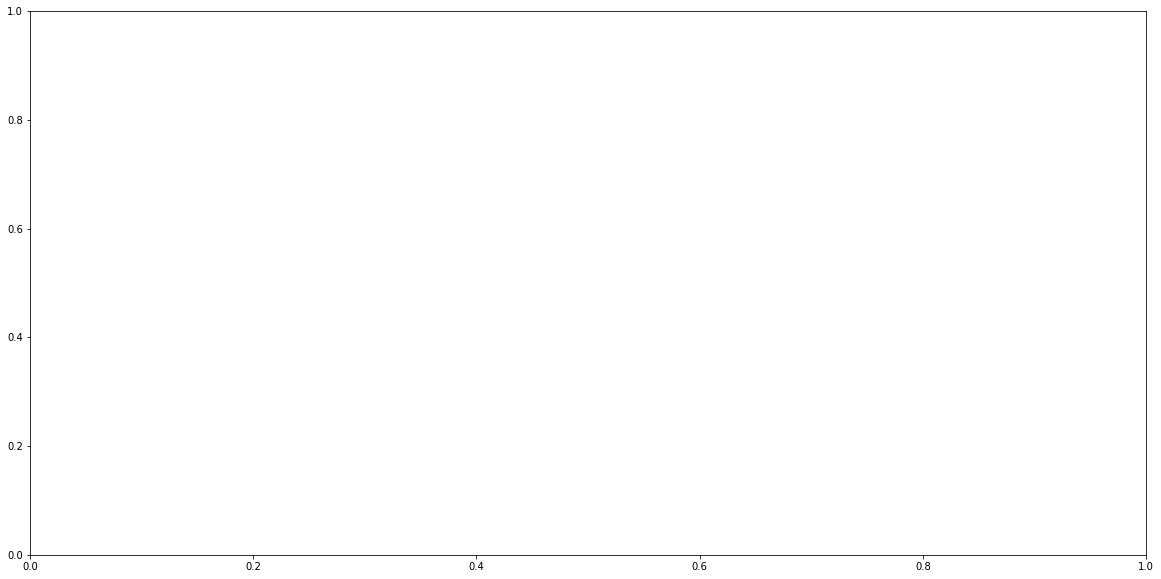

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import scipy.optimize as opt
#from pylab import *


t00 = time.time()
Q3 =[]
TT =[]
X = []
algs = ['shgo', 'differential_evolution','dual_annealing','basinhopping',  'random_starts' ]
colors = ['g',   'r',                           'c',          'y',         'b' ]
nalg = len(algs)

npar=56
#vv = np.arange(8)    # A 1:8 20Hz
vv = np.arange(npar) # all
vv = np.delete(vv,np.array([8,12,16,20,24,28,32,40,44,52,56])-1)
#vv = np.concatenate([vv,vv+32, vv+44]) # without recovery
par = {'fited_pulses':True, 'amplitudes_selected_for_TM_training':vv, 'aba_case':True, 'figure':0,
       'model_type' : 'tm5' }

#par['model_type'] = 'TM_5_changing_tD'

for i in  range(len(df9.index)): #range(22,23): #range(len(df9.index)):
    idx = df9.index[i]
    print('\n\n'+str(i)+'  '+df9.loc[idx,'comments']+'\n')
    Ts  = df9.loc[idx,'comments1']
    #ampsa = df.loc[idx,'stp_mean_fit_bootstrap']
    #is_fited_pulses = (abs(ampsa[0])>1e-14)
    
    is_fited_pulses = True
    if (len(Ts)!=0)&((par['fited_pulses']==False)|is_fited_pulses):
        fig, ax = plt.subplots(figsize=(20, 10))
        par['figure']=fig
    #try:
        #par['fited_pulses']=True
        Q2, tt, x, algs, colors = fit_TM_cell(idx,df9,par)
        nalg = len(tt)
    #except:
    else:
        print(Ts)
        Q2 = (10*np.zeros(nalg)).tolist()
        tt = (0*np.zeros(nalg)).tolist()
        x = (0*np.zeros(nalg)).tolist()
        
    Q3 = Q3 + [Q2]
    TT = TT + [tt]
    X = X + [x]
    

    
Q3 = pd.DataFrame(Q3)  
TT = pd.DataFrame(TT) 
t10 = time.time()
print('time : '+ str(t10-t00))

In [213]:
# Save results

Q3.columns = algs
algs2=algs
for ialg, alg in enumerate(algs2): 
    algs2[ialg] = alg + ' , time'
TT.columns = algs2
QT = pd.concat([Q3,TT],axis=1)

X3 = pd.DataFrame(X)
#X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x', 'shgo best x', 'basinhopping best x']
X3.columns = ['differential_evolution best x', 'dual_annealing best x', 'random_starts best x']

QT = pd.concat([QT,X3],axis=1)
QT.index = df9.index

QTX = pd.concat([df9,QT],axis=1)

QTX.to_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results2','data')

/home/stepaniu/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'numpy.str_' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/home/stepaniu/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'numpy.str_', sort order is undefined for incomparable objects
  result = result.union(other)
/home/stepaniu/anaconda3/lib/python3.7/site-packages/pandas/io/pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1] [items->None]

  f(store)
/home/stepaniu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block

In [215]:
QTX.loc[QTX.index[0],'comments']

"['unknown L5; unknown L5', 'unknown L5; sim1 L5', 'tlx3 L5; fam84b L5', 'unknown L5; tlx3 L5', 'unknown L5; rorb L5', 'unknown L5; unknown L']"

In [292]:
QTX=pd.read_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results')

ValueError: cannot set WRITEABLE flag to True of this array

### miscelleneous:

In [296]:


QTX.shape

(86, 27)

In [300]:
QTX2 = QTX.iloc[0:43,0:14]
QTX3 = QTX.iloc[43:,14:]
QTX3.index = QTX2.index
QTX2 = pd.concat([QTX2, QTX3],axis=1)

In [301]:
QTX2

name  \
tlx3 L5; fam84b L5          [aba_2019_synphys_pair_84116; tlx3 L5; fam84b L5]   
nr5a1 L2/3; nr5a1 L2/3      [aba_2019_synphys_pair_77886; nr5a1 L2/3; nr5a...   
tlx3 L5; pvalb L2/3         [aba_2019_synphys_pair_69203; tlx3 L5; pvalb L...   
rbp4 L4; rbp4 L4              [aba_2019_synphys_pair_34697; rbp4 L4; rbp4 L4]   
pvalb L6; pvalb L6          [aba_2019_synphys_pair_57717; pvalb L6; pvalb L6]   
pvalb L2/3; vip L2/3        [aba_2019_synphys_pair_42202; pvalb L2/3; vip ...   
sst L4; vip L4                  [aba_2019_synphys_pair_85538; sst L4; vip L4]   
sst L6; sst L6                  [aba_2019_synphys_pair_92558; sst L6; sst L6]   
unknown L2/3; vip L2/3      [aba_2019_synphys_pair_69453; unknown L2/3; vi...   
ntsr1 L6; ntsr1 L6          [aba_2019_synphys_pair_61000; ntsr1 L6; ntsr1 L6]   
nr5a1 L4; vip L4              [aba_2019_synphys_pair_97762; nr5a1 L4; vip L4]   
unknown L2/3; unknown L2/3  [aba_2019_synphys_pair_78203; unknown L2/3; un...   
vip L2/3; vip L4              [aba_2019_synphys_pair_85664; vip L2/3; vip L4]   
sst L6; pvalb L5              [aba_2019_synphys_pair_58169; sst L6; pvalb L5]   
vip L2/3; sst L2/3          [aba_2019_synphys_pair_74057; vip L2/3; sst L2/3]   
unknown L2/3; pvalb L2/3    [aba_2019_synphys_pair_90113; unknown L2/3; pv...   
ntsr1 L6; pvalb L6          [aba_2019_synphys_pair_70309; ntsr1 L6; pvalb L6]   
pvalb L5; tlx3 L5            [aba_2019_synphys_pair_23389; pvalb L5; tlx3 L5]   
pvalb L4; nr5a1 L4          [aba_2019_synphys_pair_74339; pvalb L4; nr5a1 L4]   
sim1 L5; pvalb L5            [aba_2019_synphys_pair_90379; sim1 L5; pvalb L5]   
pvalb L2/3; sst L2/3        [aba_2019_synphys_pair_92045; pvalb L2/3; sst ...   
sst L4; nr5a1 L4              [aba_2019_synphys_pair_73279; sst L4; nr5a1 L4]   
pvalb L2/3; pvalb L2/3      [aba_2019_synphys_pair_72007; pvalb L2/3; pval...   
rorb L4; rorb L4              [aba_2019_synphys_pair_55151; rorb L4; rorb L4]   
pvalb L4; pvalb L2/3        [aba_2019_synphys_pair_78262; pvalb L4; pvalb ...   
ntsr1 L6; sst L6              [aba_2019_synphys_pair_56609; ntsr1 L6; sst L6]   
vip L4; sst L5                  [aba_2019_synphys_pair_85546; vip L4; sst L5]   
pvalb L4; nr5a1 L5          [aba_2019_synphys_pair_97450; pvalb L4; nr5a1 L5]   
sst L2/3; vip L2/3          [aba_2019_synphys_pair_67401; sst L2/3; vip L2/3]   
nr5a1 L4; sst L4              [aba_2019_synphys_pair_89701; nr5a1 L4; sst L4]   
pvalb L5; sim1 L5            [aba_2019_synphys_pair_26232; pvalb L5; sim1 L5]   
sst L2/3; sim1 L5            [aba_2019_synphys_pair_80915; sst L2/3; sim1 L5]   
sst L5; tlx3 L5                [aba_2019_synphys_pair_42926; sst L5; tlx3 L5]   
sim1 L5; sst L5                [aba_2019_synphys_pair_92003; sim1 L5; sst L5]   
pvalb L5; pvalb L5          [aba_2019_synphys_pair_17377; pvalb L5; pvalb L5]   
pvalb L6; ntsr1 L6          [aba_2019_synphys_pair_57987; pvalb L6; ntsr1 L6]   
sst L2/3; sst L2/3          [aba_2019_synphys_pair_72416; sst L2/3; sst L2/3]   
tlx3 L5; sst L5                [aba_2019_synphys_pair_42553; tlx3 L5; sst L5]   
pvalb,sst L5; pvalb L5      [aba_2019_synphys_pair_28099; pvalb,sst L5; pv...   
sim1 L5; sim1 L5              [aba_2019_synphys_pair_62585; sim1 L5; sim1 L5]   
sst L5; sst L5                  [aba_2019_synphys_pair_22739; sst L5; sst L5]   
nr5a1 L4; pvalb L4          [aba_2019_synphys_pair_74371; nr5a1 L4; pvalb L4]   
tlx3 L5; tlx3 L5              [aba_2019_synphys_pair_25382; tlx3 L5; tlx3 L5]   

                                    area              synapse_type_2  \
tlx3 L5; fam84b L5              [L5; L5]          tlx3 L5; fam84b L5   
nr5a1 L2/3; nr5a1 L2/3      [L2/3; L2/3]      nr5a1 L2/3; nr5a1 L2/3   
tlx3 L5; pvalb L2/3           [L5; L2/3]         tlx3 L5; pvalb L2/3   
rbp4 L4; rbp4 L4                [L4; L4]            rbp4 L4; rbp4 L4   
pvalb L6; pvalb L6              [L6; L6]          pvalb L6; pvalb L6   
pvalb L2/3; vip L2/3        [L2/3; L2/3]        pvalb L2/3; vip L2/3   
sst 

In [308]:
QTX2.to_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results2','data')
#QTX2 = QTX2.reset_index()
#QTX2.to_feather('fit_aba_2019_A1_8_fited_pulses_syntypes_results2')

/home/stepaniu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['index', 'name', 'area', 'synapse_type_2', 'stp_freq', 'stp_mean_1', 'stp_sigma', 'comments', 'comments1', 'numbers_of_currents', 'references', 'stp_mean_bootstrap', 'stp_sigma_bootstrap', 'stp_mean_fit_bootstrap', 'stp_sigma_fit_bootstrap', 'differential_evolution best x', 'dual_annealing best x', 'random_starts best x']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [311]:
np.__version__

'1.17.2'

In [320]:
import tables
#import numpy as np
#import pandas as pd
tables.__version__

'3.4.4'

In [321]:
import importlib
importlib.reload(tables)
tables.__version__

'3.4.4'

In [317]:
QTX2=pd.read_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results2')
#QTX2=pd.read_feather('fit_aba_2019_A1_8_fited_pulses_syntypes_results2')

ValueError: cannot set WRITEABLE flag to True of this array

In [319]:
tables.__version__

'3.4.4'

In [314]:
import numpy as np
import pandas as pd
QTX2.to_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results2','data')
QTX2=pd.read_hdf('fit_aba_2019_A1_8_fited_pulses_syntypes_results2')

ValueError: cannot set WRITEABLE flag to True of this array